In [1]:
from PIL import Image
import tqdm
import os
import time
import collections

import torch
import torchvision
assert torch.cuda.is_available()
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

AMOUNT = None
BATCH_SIZE = 220
VAL_SIZE = 0.2
IM_SIZE = (32, 32)
DEVICE = 'cuda:0'

----------------
## Создание Custom Dataset  и DataLoader
Объект класса ImageDataset подгружает файл с нужным изображением при вызове метода \__getitem__.

Работа происходит в цветовом пространстве HSV:
- hue - оттенок (image[0]),
- saturation - насыщенность (image[1]),
- value - значение яркости (image[2])

Яркость будет неизменным и опорным значением для модели, по которому будут рассчитываться два оставшихся параметра, влияющих на цвет.


In [2]:
def dataset_preparation(in_path, out_path, im_size):
    ''' перезаписывает файлы в другую папку + resize '''
    files_list = os.listdir(in_path)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    for file_n in tqdm.tqdm(files_list):
        with Image.open(in_path+file_n) as file:
            file.resize(im_size).save(out_path+file_n)

class ImageDataset(torch.utils.data.Dataset):
    ''' 
    Формат файлов: png или jpg
    amount - временное решение по ограничению кол-ва обучающих данных
    '''
    
    def __init__(self, path, transforms, amount = None, to_hsv = True):
        self.transforms = transforms
        self.to_hsv = to_hsv
        self.path = path
        
        is_image_filter = lambda value:('png' in value) or ('jpg' in value) or ('JPEG' in value)
        self.f_names = list(filter(is_image_filter, os.listdir(path)))[:amount]
        self.len = len(self.f_names)
        
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        with Image.open(self.path + self.f_names[index]) as file:
            image = self.transforms(file.convert('HSV')) 
            return image[2].unsqueeze(0), image[:2]     # unsqueeze на случай реализации vgg16
                                                        # image shape - [hue, sat, val], return [newax, h, s]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean = 0.5, std=0.5)
])
# dataset_preparation(in_path = 'imagenet_val/',
#                     out_path = 'im_dataset/',
#                     im_size = IM_SIZE)
dataset = ImageDataset(path = 'im_dataset/', transforms = transforms, amount = AMOUNT)

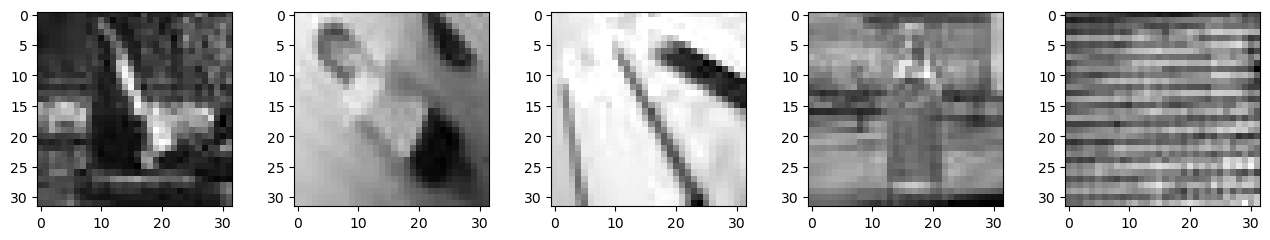

In [3]:
%matplotlib inline
_, ax = plt.subplots(1, 5, figsize = (13, 5))
plt.tight_layout()
for i in range(5):
    ax[i].imshow(dataset[i][0].permute(1, 2, 0), cmap = 'gray')

In [4]:
def val_split(dataset, val_size):
    ''' val_size задается в диапазоне 0..1 '''
    val_length = int(np.round(len(dataset) * val_size))
    val_idx = range(val_length)
    train_idx = range(val_length, len(dataset))
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    return train_sampler, val_sampler

train_sampler, val_sampler = val_split(dataset, val_size = VAL_SIZE)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler, drop_last = True)
val_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = val_sampler, drop_last = True)

---------------------------------------
## Архитектура модели
VGG в качестве feature extractor

In [5]:
class StylerNet(torch.nn.Module):
    ''' '''
    
    def __init__(self, optim):
        super(StylerNet, self).__init__()

        feature_extractor = torchvision.models.vgg16(pretrained = True)
        self.l1_encoder = torch.nn.Sequential(
            collections.OrderedDict({
                'conv1': feature_extractor.features[:5],
                'conv2': feature_extractor.features[5:10],
                'conv3': feature_extractor.features[10:17],
                'conv4': feature_extractor.features[17:30]
            })
        )
        for param in self.l1_encoder.parameters():
            param.requires_grad = False
        
        self.l2_decoder = torch.nn.Sequential(
            collections.OrderedDict({
                'convTranspose1': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(256)
                ),
                'convTranspose2': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(128),
                ),
                'convTranspose3': torch.nn.Sequential(            
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(64),
                ),
                'convTranspose4': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(32),
                ),
                'convOut': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1),
                    torch.nn.BatchNorm2d(2),
                    torch.nn.Tanh(),
                    torch.nn.ReLU()
                )
            })    
        )
        self.loss_fn = torch.nn.BCELoss()
        self.optim = optim(self.parameters(), lr = .001, weight_decay=0.1)
        
    def forward(self, x):
        x = torch.cat([x, x, x], axis=1)
        x1 = self.l1_encoder.conv1(x)          # (, 64, 64, 64)
        x2 = self.l1_encoder.conv2(x1)         # (, 128, 32, 32)
        x3 = self.l1_encoder.conv3(x2)         # (, 256, 16, 16)
        x4 = self.l1_encoder.conv4(x3)         # (, 512, 8, 8)
        
        x = self.l2_decoder.convTranspose1(x4) # ( , 512, 16, 16)
        x = self.l2_decoder.convTranspose2(x)  # ( , 256, 32, 32)
        x = self.l2_decoder.convTranspose3(x)  # ( , 128, 64, 64)
        x = self.l2_decoder.convTranspose4(x)  # ( , 32, 128, 128)
        
        x = self.l2_decoder.convOut(x)
        return x
    
    def calc_loss(self, outputs, targets):
        return self.loss_fn(outputs, targets)
            
    def predict(self, inputs):
        topillow = torchvision.transforms.ToPILImage('HSV')
        image = topillow(torch.hstack([self(inputs.to(DEVICE)), inputs.to(DEVICE)])[0])
        return image
    def checkpoint(self, direction, epoch):
        torch.save(self.state_dict, direction + f'model_{epoch}')
    def load_checkpoint(self, direction, epoch):
        self.load_state_dict(torch.load(direction + f'model_{epoch}')())

--------------
## Обучение

In [6]:
def train_model3(model, train_loader, epochs = 1, device = DEVICE):
    model.to(device)
    model.train()
    
    # для val_loss
    calc_loss = torch.nn.MSELoss()
    topillow = torchvision.transforms.ToPILImage('HSV')
    image = next(iter(train_loader))     # image shape   [[s, h], v]
    
    point = np.ceil(len(train_loader) / 10)
    loss = np.array([])
    
    for epoch in range(epochs):
        model.to(device)
        start_time = time.time()
        print(f'Epoch {epoch}/{epochs}: <', end = '')
        
        for i, (inputs, targets) in enumerate(train_loader):
            model.optim.zero_grad()
            model_outs = model(inputs.to(device))
            model_loss = model.calc_loss(model_outs, targets.to(device))
            model_loss.backward()
            model.optim.step()
            
            
            if not i % point:
                print('=', end = '')
                
        print(f'> ------- model loss = {model_loss}, time = {np.round(time.time() - start_time)}s')
        
        loss = np.append(loss, model_loss.detach().to('cpu').numpy())
        
        
        if not epoch % 5:
            model.checkpoint('checkpoints/', epoch)
            
            # расчет validation loss    
            with torch.no_grad():                  
                val_loss = 0
                for i, (inputs, targets) in enumerate(val_loader):
                    outputs = model(inputs.to(device))
                    val_loss += calc_loss(outputs, targets.to(device))
#                 val_loss = val_loss / i
                print(f'\nValidation loss = {val_loss}')
                
                # визуальный вывод
                fake_im = model.predict(image[0])
                real_im = topillow(torch.hstack((image[1], image[0]))[0])
                _, ax = plt.subplots(1, 3, figsize = (10, 2))
                plt.tight_layout()
                ax[0].set_title('fake image')
                ax[0].imshow(fake_im)
                ax[1].set_title('real image')
                ax[1].imshow(real_im)
                ax[2].set_title('losses')
                ax[2].plot(loss, label = 'model loss')
                ax[2].legend()
                plt.show()
                

    return loss

In [9]:
model = StylerNet(optim = torch.optim.Adam)
model_params_amount = (sum(p.numel() for p in model.parameters()))
print(f'Количество параметров модели: {model_params_amount}')

Количество параметров модели: 19417830


Epoch 0/1000: <=> ------- model loss = 5.257472991943359, time = 1.0s

Validation loss = 0


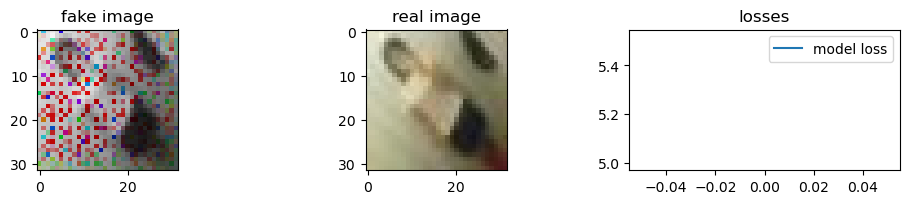

Epoch 1/1000: <=> ------- model loss = 5.245985984802246, time = 0.0s
Epoch 2/1000: <=> ------- model loss = 5.223422527313232, time = 0.0s
Epoch 3/1000: <=> ------- model loss = 5.2511420249938965, time = 0.0s
Epoch 4/1000: <=> ------- model loss = 5.193225860595703, time = 0.0s
Epoch 5/1000: <=> ------- model loss = 5.099187850952148, time = 0.0s

Validation loss = 0


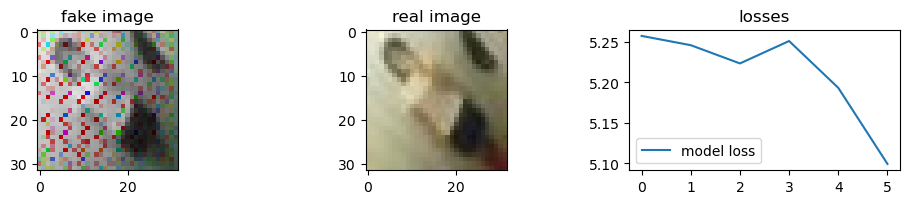

Epoch 6/1000: <=> ------- model loss = 5.066803455352783, time = 0.0s
Epoch 7/1000: <=> ------- model loss = 4.980365753173828, time = 0.0s
Epoch 8/1000: <=> ------- model loss = 4.91185188293457, time = 0.0s
Epoch 9/1000: <=> ------- model loss = 4.855341911315918, time = 0.0s
Epoch 10/1000: <=> ------- model loss = 4.779013156890869, time = 0.0s

Validation loss = 0


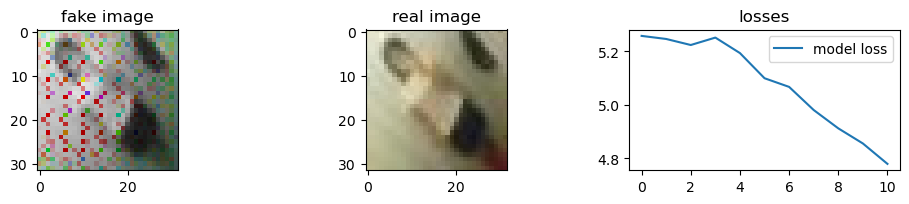

Epoch 11/1000: <=> ------- model loss = 4.700553894042969, time = 0.0s
Epoch 12/1000: <=> ------- model loss = 4.616765975952148, time = 0.0s
Epoch 13/1000: <=> ------- model loss = 4.551617622375488, time = 0.0s
Epoch 14/1000: <=> ------- model loss = 4.498412132263184, time = 0.0s
Epoch 15/1000: <=> ------- model loss = 4.442490100860596, time = 0.0s

Validation loss = 0


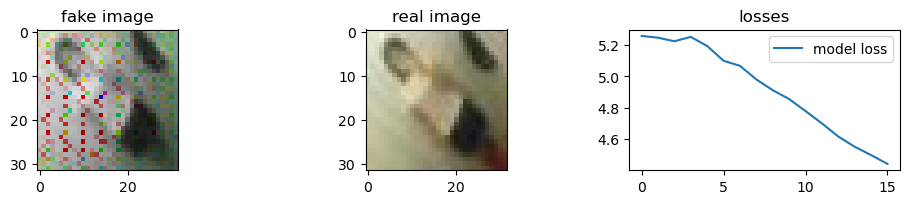

Epoch 16/1000: <=> ------- model loss = 4.380101680755615, time = 0.0s
Epoch 17/1000: <=> ------- model loss = 4.3427734375, time = 0.0s
Epoch 18/1000: <=> ------- model loss = 4.271162986755371, time = 0.0s
Epoch 19/1000: <=> ------- model loss = 4.206090927124023, time = 0.0s
Epoch 20/1000: <=> ------- model loss = 4.151532173156738, time = 0.0s

Validation loss = 0


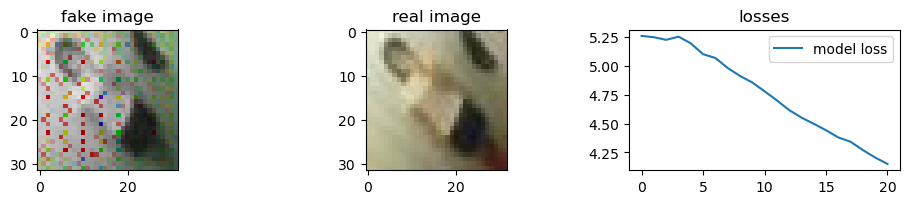

Epoch 21/1000: <=> ------- model loss = 4.106242656707764, time = 0.0s
Epoch 22/1000: <=> ------- model loss = 4.0645575523376465, time = 0.0s
Epoch 23/1000: <=> ------- model loss = 4.0260210037231445, time = 0.0s
Epoch 24/1000: <=> ------- model loss = 3.9992339611053467, time = 0.0s
Epoch 25/1000: <=> ------- model loss = 3.9562630653381348, time = 0.0s

Validation loss = 0


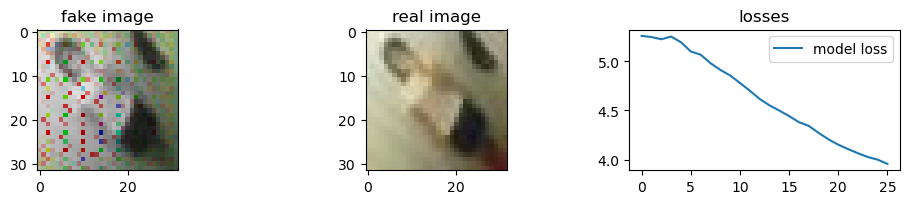

Epoch 26/1000: <=> ------- model loss = 3.9278993606567383, time = 0.0s
Epoch 27/1000: <=> ------- model loss = 3.904170036315918, time = 0.0s
Epoch 28/1000: <=> ------- model loss = 3.864481210708618, time = 0.0s
Epoch 29/1000: <=> ------- model loss = 3.838070869445801, time = 0.0s
Epoch 30/1000: <=> ------- model loss = 3.8228678703308105, time = 0.0s

Validation loss = 0


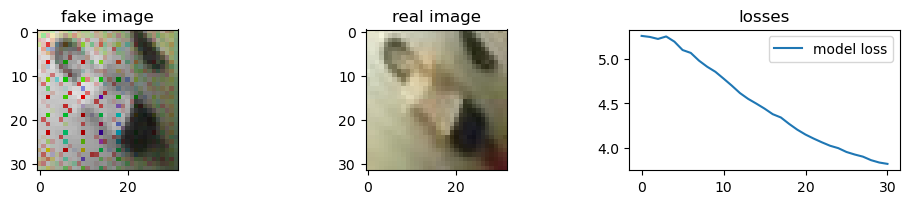

Epoch 31/1000: <=> ------- model loss = 3.787132740020752, time = 0.0s
Epoch 32/1000: <=> ------- model loss = 3.7594854831695557, time = 0.0s
Epoch 33/1000: <=> ------- model loss = 3.740415573120117, time = 0.0s
Epoch 34/1000: <=> ------- model loss = 3.7261195182800293, time = 0.0s
Epoch 35/1000: <=> ------- model loss = 3.706698179244995, time = 0.0s

Validation loss = 0


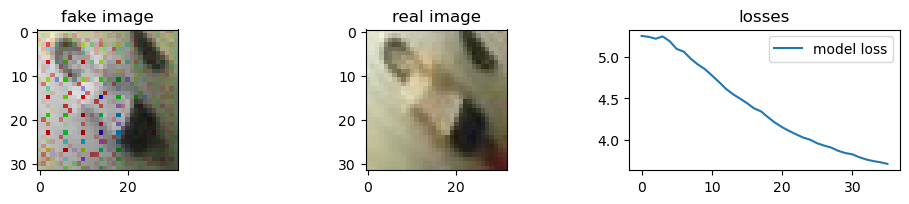

Epoch 36/1000: <=> ------- model loss = 3.6885151863098145, time = 0.0s
Epoch 37/1000: <=> ------- model loss = 3.6734886169433594, time = 0.0s
Epoch 38/1000: <=> ------- model loss = 3.6545543670654297, time = 0.0s
Epoch 39/1000: <=> ------- model loss = 3.6260976791381836, time = 0.0s
Epoch 40/1000: <=> ------- model loss = 3.599837303161621, time = 0.0s

Validation loss = 0


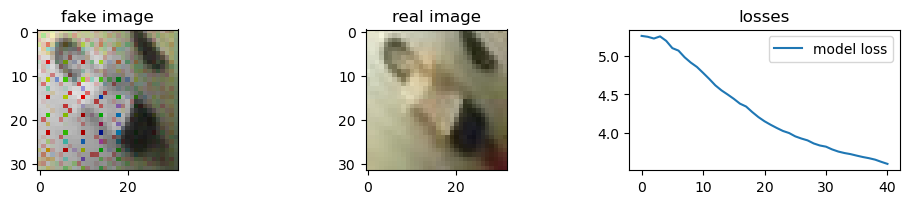

Epoch 41/1000: <=> ------- model loss = 3.589599609375, time = 0.0s
Epoch 42/1000: <=> ------- model loss = 3.570331335067749, time = 0.0s
Epoch 43/1000: <=> ------- model loss = 3.5571956634521484, time = 0.0s
Epoch 44/1000: <=> ------- model loss = 3.531432867050171, time = 0.0s
Epoch 45/1000: <=> ------- model loss = 3.5133280754089355, time = 0.0s

Validation loss = 0


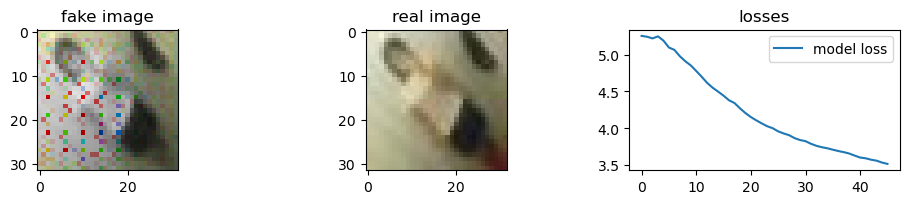

Epoch 46/1000: <=> ------- model loss = 3.5029549598693848, time = 0.0s
Epoch 47/1000: <=> ------- model loss = 3.503615140914917, time = 0.0s
Epoch 48/1000: <=> ------- model loss = 3.493699312210083, time = 0.0s
Epoch 49/1000: <=> ------- model loss = 3.4837534427642822, time = 0.0s
Epoch 50/1000: <=> ------- model loss = 3.4647703170776367, time = 0.0s

Validation loss = 0


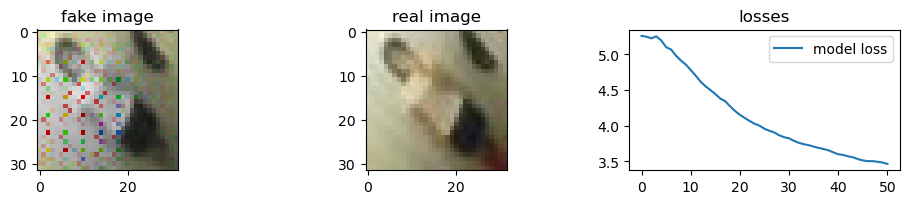

Epoch 51/1000: <=> ------- model loss = 3.4467577934265137, time = 0.0s
Epoch 52/1000: <=> ------- model loss = 3.431253433227539, time = 0.0s
Epoch 53/1000: <=> ------- model loss = 3.4263651371002197, time = 0.0s
Epoch 54/1000: <=> ------- model loss = 3.387612819671631, time = 0.0s
Epoch 55/1000: <=> ------- model loss = 3.3785600662231445, time = 0.0s

Validation loss = 0


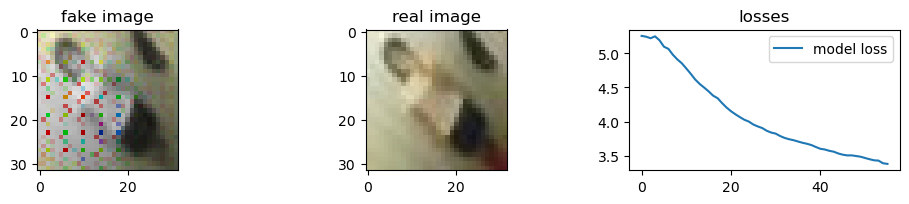

Epoch 56/1000: <=> ------- model loss = 3.3481154441833496, time = 0.0s
Epoch 57/1000: <=> ------- model loss = 3.312007427215576, time = 0.0s
Epoch 58/1000: <=> ------- model loss = 3.2942750453948975, time = 0.0s
Epoch 59/1000: <=> ------- model loss = 3.2785682678222656, time = 0.0s
Epoch 60/1000: <=> ------- model loss = 3.248821496963501, time = 0.0s

Validation loss = 0


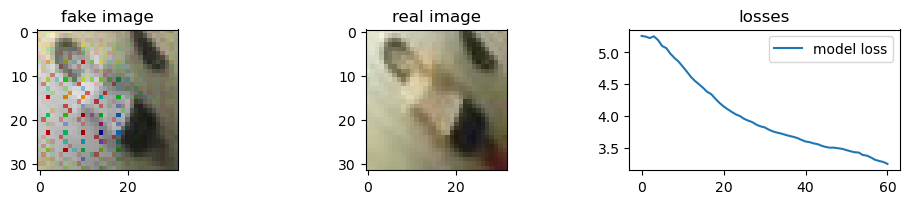

Epoch 61/1000: <=> ------- model loss = 3.2140092849731445, time = 0.0s
Epoch 62/1000: <=> ------- model loss = 3.196070671081543, time = 0.0s
Epoch 63/1000: <=> ------- model loss = 3.166078567504883, time = 0.0s
Epoch 64/1000: <=> ------- model loss = 3.1427979469299316, time = 0.0s
Epoch 65/1000: <=> ------- model loss = 3.0642313957214355, time = 0.0s

Validation loss = 0


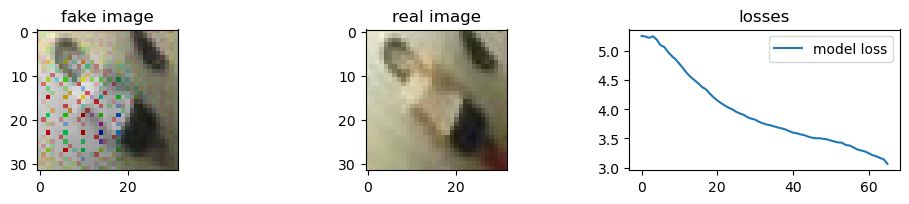

Epoch 66/1000: <=> ------- model loss = 3.006321907043457, time = 0.0s
Epoch 67/1000: <=> ------- model loss = 2.9443929195404053, time = 0.0s
Epoch 68/1000: <=> ------- model loss = 2.9090657234191895, time = 0.0s
Epoch 69/1000: <=> ------- model loss = 2.8892393112182617, time = 0.0s
Epoch 70/1000: <=> ------- model loss = 2.8726820945739746, time = 0.0s

Validation loss = 0


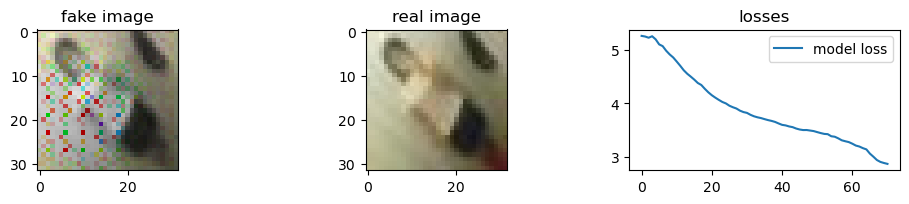

Epoch 71/1000: <=> ------- model loss = 2.860872745513916, time = 0.0s
Epoch 72/1000: <=> ------- model loss = 2.8274807929992676, time = 0.0s
Epoch 73/1000: <=> ------- model loss = 2.789790391921997, time = 0.0s
Epoch 74/1000: <=> ------- model loss = 2.7798187732696533, time = 0.0s
Epoch 75/1000: <=> ------- model loss = 2.7484421730041504, time = 0.0s

Validation loss = 0


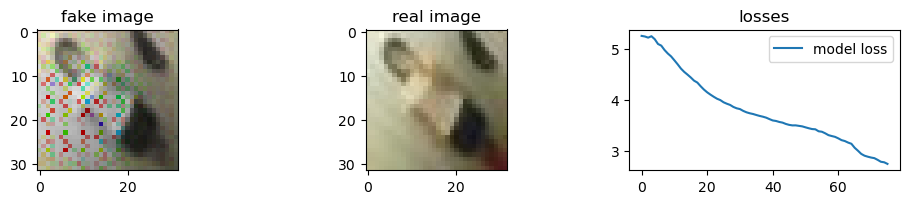

Epoch 76/1000: <=> ------- model loss = 2.716015577316284, time = 0.0s
Epoch 77/1000: <=> ------- model loss = 2.701329231262207, time = 0.0s
Epoch 78/1000: <=> ------- model loss = 2.6888551712036133, time = 0.0s
Epoch 79/1000: <=> ------- model loss = 2.6701135635375977, time = 0.0s
Epoch 80/1000: <=> ------- model loss = 2.6620562076568604, time = 0.0s

Validation loss = 0


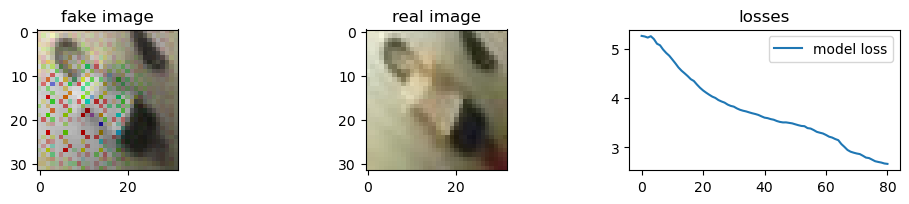

Epoch 81/1000: <=> ------- model loss = 2.6536121368408203, time = 0.0s
Epoch 82/1000: <=> ------- model loss = 2.6284842491149902, time = 0.0s
Epoch 83/1000: <=> ------- model loss = 2.6044187545776367, time = 0.0s
Epoch 84/1000: <=> ------- model loss = 2.587641716003418, time = 0.0s
Epoch 85/1000: <=> ------- model loss = 2.581535577774048, time = 0.0s

Validation loss = 0


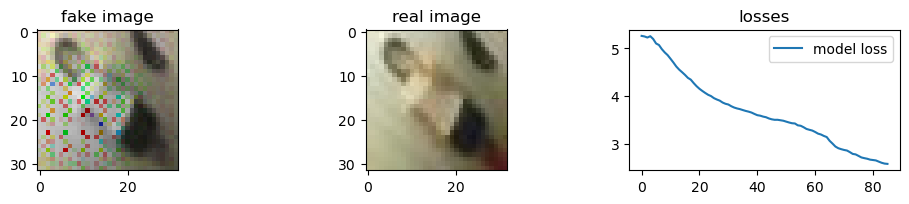

Epoch 86/1000: <=> ------- model loss = 2.5667386054992676, time = 0.0s
Epoch 87/1000: <=> ------- model loss = 2.5451040267944336, time = 0.0s
Epoch 88/1000: <=> ------- model loss = 2.5123517513275146, time = 0.0s
Epoch 89/1000: <=> ------- model loss = 2.498671054840088, time = 0.0s
Epoch 90/1000: <=> ------- model loss = 2.4671430587768555, time = 0.0s

Validation loss = 0


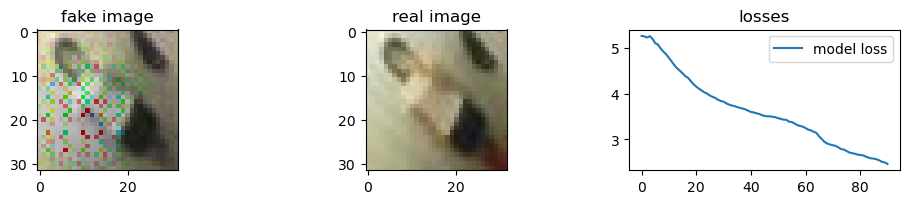

Epoch 91/1000: <=> ------- model loss = 2.4455137252807617, time = 0.0s
Epoch 92/1000: <=> ------- model loss = 2.416245937347412, time = 0.0s
Epoch 93/1000: <=> ------- model loss = 2.403500556945801, time = 0.0s
Epoch 94/1000: <=> ------- model loss = 2.3865277767181396, time = 0.0s
Epoch 95/1000: <=> ------- model loss = 2.3635072708129883, time = 0.0s

Validation loss = 0


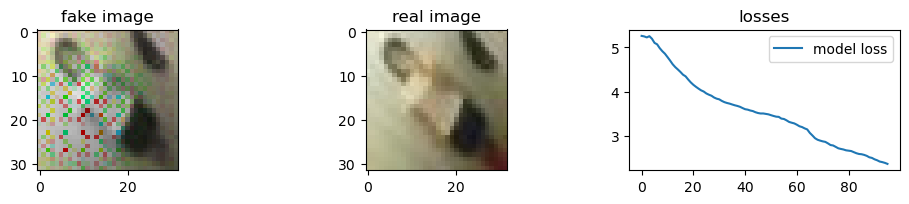

Epoch 96/1000: <=> ------- model loss = 2.3523714542388916, time = 0.0s
Epoch 97/1000: <=> ------- model loss = 2.3318498134613037, time = 0.0s
Epoch 98/1000: <=> ------- model loss = 2.32381010055542, time = 0.0s
Epoch 99/1000: <=> ------- model loss = 2.2957234382629395, time = 0.0s
Epoch 100/1000: <=> ------- model loss = 2.28269100189209, time = 0.0s

Validation loss = 0


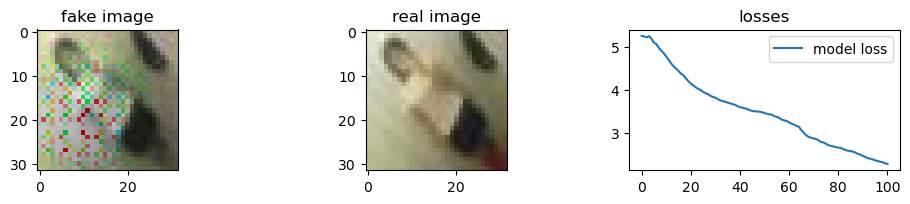

Epoch 101/1000: <=> ------- model loss = 2.252681255340576, time = 0.0s
Epoch 102/1000: <=> ------- model loss = 2.2110531330108643, time = 0.0s
Epoch 103/1000: <=> ------- model loss = 2.1807940006256104, time = 0.0s
Epoch 104/1000: <=> ------- model loss = 2.1789603233337402, time = 0.0s
Epoch 105/1000: <=> ------- model loss = 2.1646196842193604, time = 0.0s

Validation loss = 0


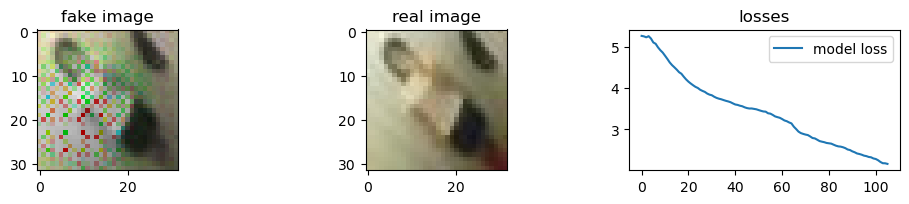

Epoch 106/1000: <=> ------- model loss = 2.1540708541870117, time = 0.0s
Epoch 107/1000: <=> ------- model loss = 2.1338062286376953, time = 0.0s
Epoch 108/1000: <=> ------- model loss = 2.1114501953125, time = 0.0s
Epoch 109/1000: <=> ------- model loss = 2.098011016845703, time = 0.0s
Epoch 110/1000: <=> ------- model loss = 2.0863728523254395, time = 0.0s

Validation loss = 0


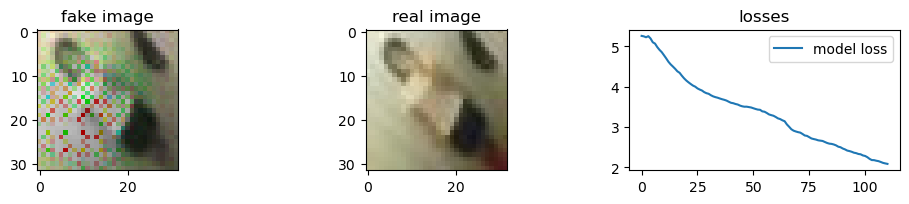

Epoch 111/1000: <=> ------- model loss = 2.0821754932403564, time = 0.0s
Epoch 112/1000: <=> ------- model loss = 2.0706725120544434, time = 0.0s
Epoch 113/1000: <=> ------- model loss = 2.0652623176574707, time = 0.0s
Epoch 114/1000: <=> ------- model loss = 2.0598573684692383, time = 0.0s
Epoch 115/1000: <=> ------- model loss = 2.0469002723693848, time = 0.0s

Validation loss = 0


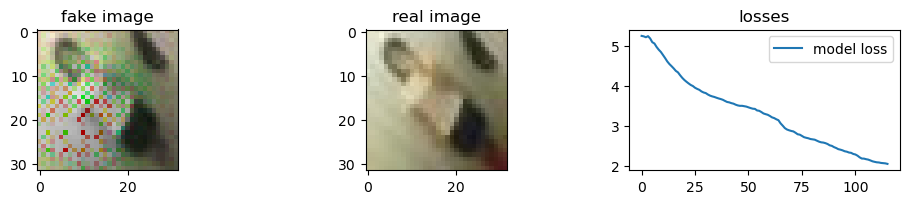

Epoch 116/1000: <=> ------- model loss = 2.0350558757781982, time = 0.0s
Epoch 117/1000: <=> ------- model loss = 2.0341458320617676, time = 0.0s
Epoch 118/1000: <=> ------- model loss = 2.017787456512451, time = 0.0s
Epoch 119/1000: <=> ------- model loss = 2.006430149078369, time = 0.0s
Epoch 120/1000: <=> ------- model loss = 1.9957714080810547, time = 0.0s

Validation loss = 0


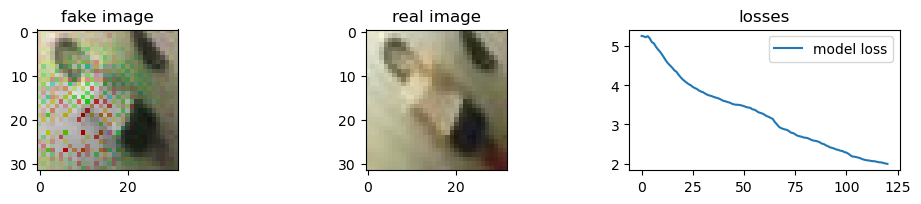

Epoch 121/1000: <=> ------- model loss = 1.9794284105300903, time = 0.0s
Epoch 122/1000: <=> ------- model loss = 1.9603462219238281, time = 0.0s
Epoch 123/1000: <=> ------- model loss = 1.9514316320419312, time = 0.0s
Epoch 124/1000: <=> ------- model loss = 1.943237543106079, time = 0.0s
Epoch 125/1000: <=> ------- model loss = 1.9368295669555664, time = 0.0s

Validation loss = 0


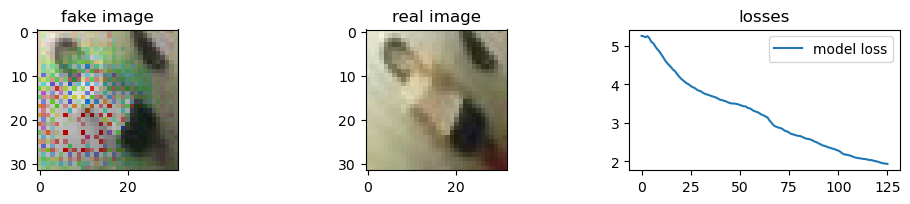

Epoch 126/1000: <=> ------- model loss = 1.9304275512695312, time = 0.0s
Epoch 127/1000: <=> ------- model loss = 1.9375946521759033, time = 0.0s
Epoch 128/1000: <=> ------- model loss = 1.9459309577941895, time = 0.0s
Epoch 129/1000: <=> ------- model loss = 1.9492467641830444, time = 0.0s
Epoch 130/1000: <=> ------- model loss = 1.9410884380340576, time = 0.0s

Validation loss = 0


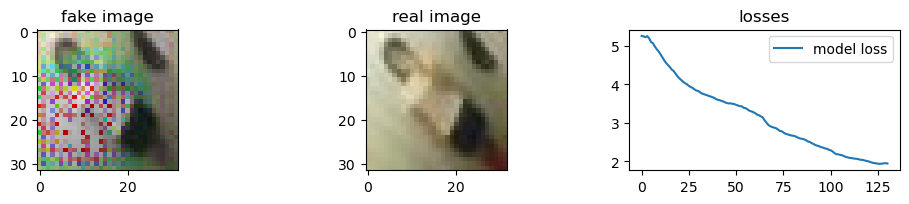

Epoch 131/1000: <=> ------- model loss = 1.9182956218719482, time = 0.0s
Epoch 132/1000: <=> ------- model loss = 1.9118363857269287, time = 0.0s
Epoch 133/1000: <=> ------- model loss = 1.904829740524292, time = 0.0s
Epoch 134/1000: <=> ------- model loss = 1.8737902641296387, time = 0.0s
Epoch 135/1000: <=> ------- model loss = 1.8700990676879883, time = 0.0s

Validation loss = 0


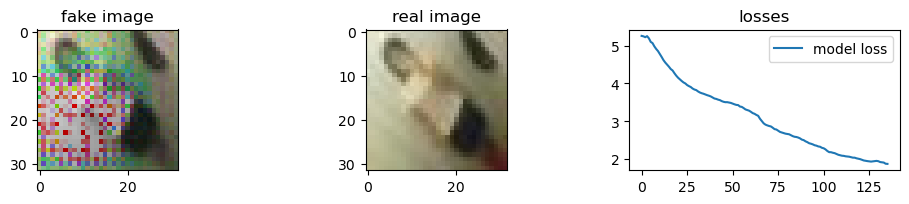

Epoch 136/1000: <=> ------- model loss = 1.8520925045013428, time = 0.0s
Epoch 137/1000: <=> ------- model loss = 1.8320324420928955, time = 0.0s
Epoch 138/1000: <=> ------- model loss = 1.8286550045013428, time = 0.0s
Epoch 139/1000: <=> ------- model loss = 1.8235031366348267, time = 0.0s
Epoch 140/1000: <=> ------- model loss = 1.8131558895111084, time = 0.0s

Validation loss = 0


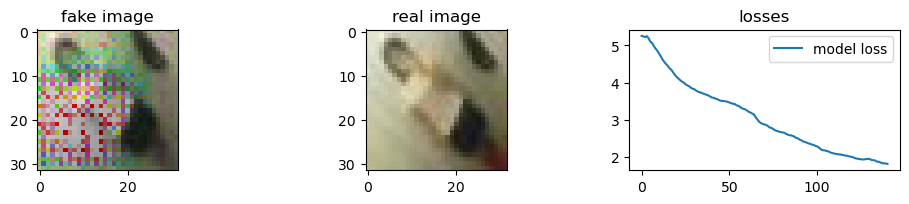

Epoch 141/1000: <=> ------- model loss = 1.8147664070129395, time = 0.0s
Epoch 142/1000: <=> ------- model loss = 1.801621437072754, time = 0.0s
Epoch 143/1000: <=> ------- model loss = 1.7986879348754883, time = 0.0s
Epoch 144/1000: <=> ------- model loss = 1.7826539278030396, time = 0.0s
Epoch 145/1000: <=> ------- model loss = 1.7614920139312744, time = 0.0s

Validation loss = 0


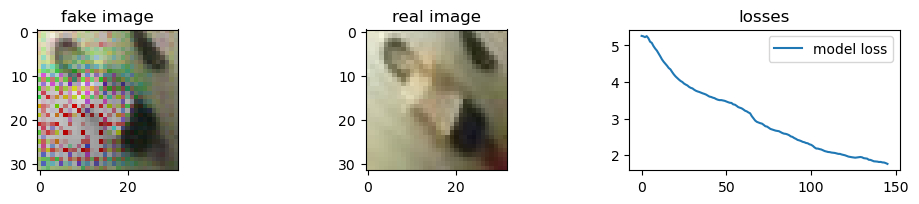

Epoch 146/1000: <=> ------- model loss = 1.728088617324829, time = 0.0s
Epoch 147/1000: <=> ------- model loss = 1.7155437469482422, time = 0.0s
Epoch 148/1000: <=> ------- model loss = 1.6852684020996094, time = 0.0s
Epoch 149/1000: <=> ------- model loss = 1.7229738235473633, time = 0.0s
Epoch 150/1000: <=> ------- model loss = 1.6977715492248535, time = 0.0s

Validation loss = 0


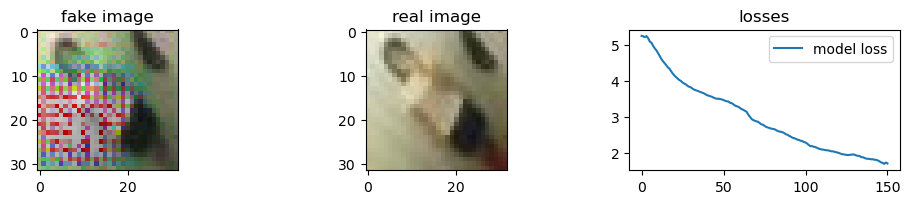

Epoch 151/1000: <=> ------- model loss = 1.7171075344085693, time = 0.0s
Epoch 152/1000: <=> ------- model loss = 1.7153533697128296, time = 0.0s
Epoch 153/1000: <=> ------- model loss = 1.7395811080932617, time = 0.0s
Epoch 154/1000: <=> ------- model loss = 1.74379563331604, time = 0.0s
Epoch 155/1000: <=> ------- model loss = 1.7367041110992432, time = 0.0s

Validation loss = 0


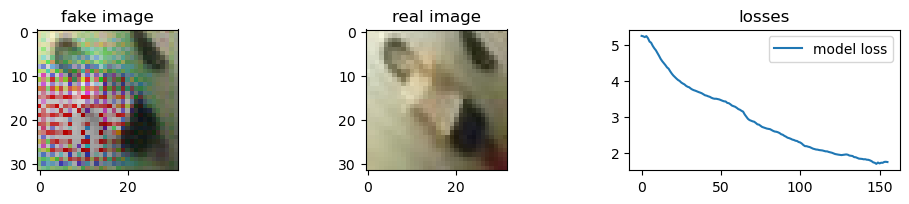

Epoch 156/1000: <=> ------- model loss = 1.722619891166687, time = 0.0s
Epoch 157/1000: <=> ------- model loss = 1.718022108078003, time = 0.0s
Epoch 158/1000: <=> ------- model loss = 1.7155606746673584, time = 0.0s
Epoch 159/1000: <=> ------- model loss = 1.6926897764205933, time = 0.0s
Epoch 160/1000: <=> ------- model loss = 1.6777178049087524, time = 0.0s

Validation loss = 0


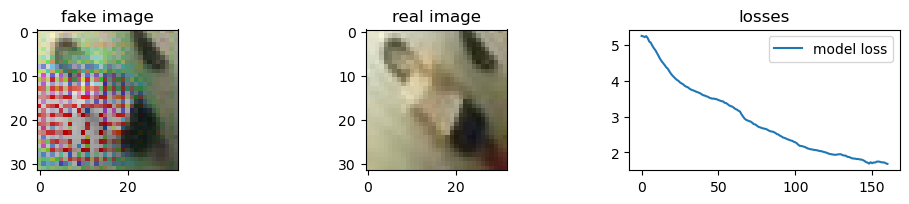

Epoch 161/1000: <=> ------- model loss = 1.6778473854064941, time = 0.0s
Epoch 162/1000: <=> ------- model loss = 1.6573859453201294, time = 0.0s
Epoch 163/1000: <=> ------- model loss = 1.6320888996124268, time = 0.0s
Epoch 164/1000: <=> ------- model loss = 1.6248289346694946, time = 0.0s
Epoch 165/1000: <=> ------- model loss = 1.6203155517578125, time = 0.0s

Validation loss = 0


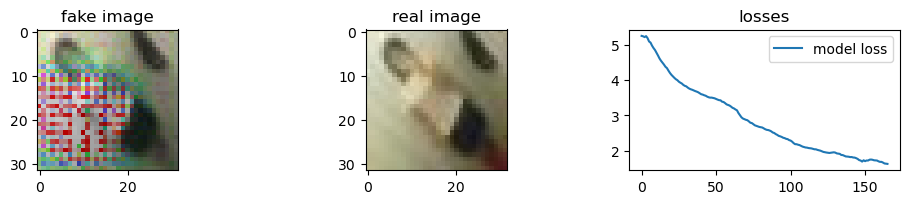

Epoch 166/1000: <=> ------- model loss = 1.6119720935821533, time = 0.0s
Epoch 167/1000: <=> ------- model loss = 1.6119720935821533, time = 0.0s
Epoch 168/1000: <=> ------- model loss = 1.6113330125808716, time = 0.0s
Epoch 169/1000: <=> ------- model loss = 1.6110429763793945, time = 0.0s
Epoch 170/1000: <=> ------- model loss = 1.6083111763000488, time = 0.0s

Validation loss = 0


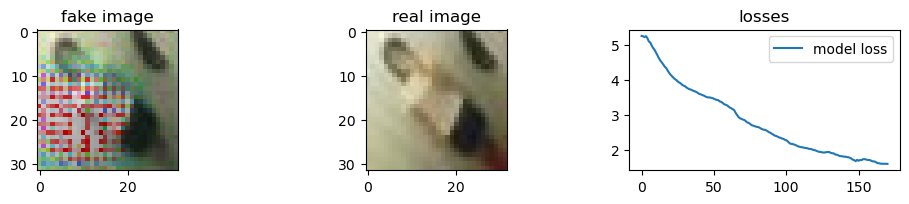

Epoch 171/1000: <=> ------- model loss = 1.6085779666900635, time = 0.0s
Epoch 172/1000: <=> ------- model loss = 1.605914831161499, time = 0.0s
Epoch 173/1000: <=> ------- model loss = 1.6032383441925049, time = 0.0s
Epoch 174/1000: <=> ------- model loss = 1.6006686687469482, time = 0.0s
Epoch 175/1000: <=> ------- model loss = 1.6021077632904053, time = 0.0s

Validation loss = 0


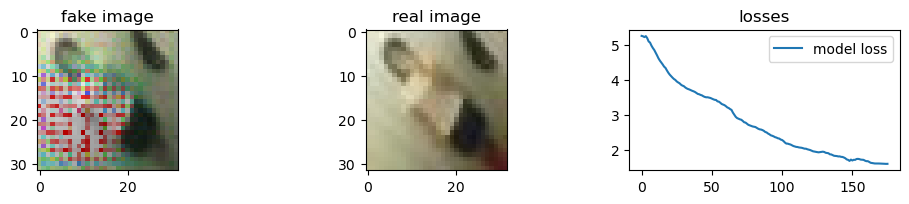

Epoch 176/1000: <=> ------- model loss = 1.599698543548584, time = 0.0s
Epoch 177/1000: <=> ------- model loss = 1.5916321277618408, time = 0.0s
Epoch 178/1000: <=> ------- model loss = 1.5973351001739502, time = 0.0s
Epoch 179/1000: <=> ------- model loss = 1.5949727296829224, time = 0.0s
Epoch 180/1000: <=> ------- model loss = 1.5953682661056519, time = 0.0s

Validation loss = 0


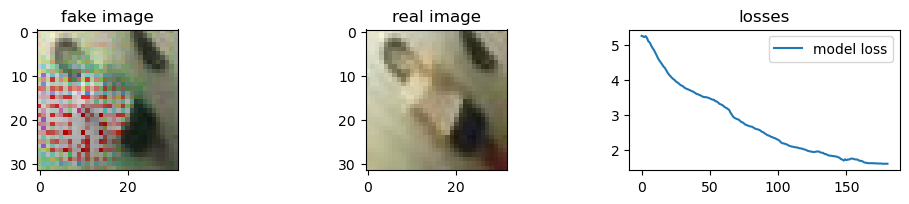

Epoch 181/1000: <=> ------- model loss = 1.5942500829696655, time = 0.0s
Epoch 182/1000: <=> ------- model loss = 1.5695185661315918, time = 0.0s
Epoch 183/1000: <=> ------- model loss = 1.559948205947876, time = 0.0s
Epoch 184/1000: <=> ------- model loss = 1.5621130466461182, time = 0.0s
Epoch 185/1000: <=> ------- model loss = 1.5605456829071045, time = 0.0s

Validation loss = 0


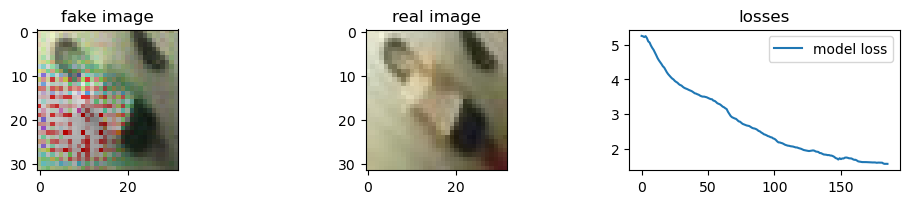

Epoch 186/1000: <=> ------- model loss = 1.559621810913086, time = 0.0s
Epoch 187/1000: <=> ------- model loss = 1.5557353496551514, time = 0.0s
Epoch 188/1000: <=> ------- model loss = 1.5373082160949707, time = 0.0s
Epoch 189/1000: <=> ------- model loss = 1.519791841506958, time = 0.0s
Epoch 190/1000: <=> ------- model loss = 1.5166592597961426, time = 0.0s

Validation loss = 0


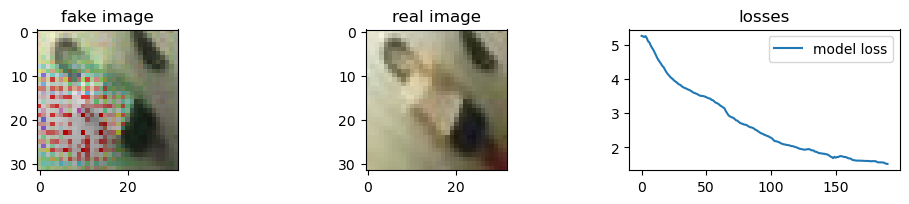

Epoch 191/1000: <=> ------- model loss = 1.5160869359970093, time = 0.0s
Epoch 192/1000: <=> ------- model loss = 1.515506625175476, time = 0.0s
Epoch 193/1000: <=> ------- model loss = 1.5147013664245605, time = 0.0s
Epoch 194/1000: <=> ------- model loss = 1.5138095617294312, time = 0.0s
Epoch 195/1000: <=> ------- model loss = 1.5034544467926025, time = 0.0s

Validation loss = 0


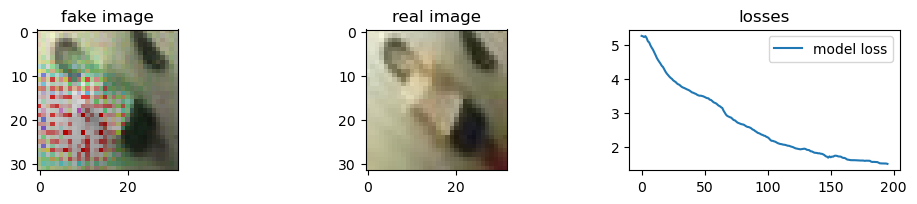

Epoch 196/1000: <=> ------- model loss = 1.4998328685760498, time = 0.0s
Epoch 197/1000: <=> ------- model loss = 1.490088939666748, time = 0.0s
Epoch 198/1000: <=> ------- model loss = 1.4889881610870361, time = 0.0s
Epoch 199/1000: <=> ------- model loss = 1.4880414009094238, time = 0.0s
Epoch 200/1000: <=> ------- model loss = 1.4819118976593018, time = 0.0s

Validation loss = 0


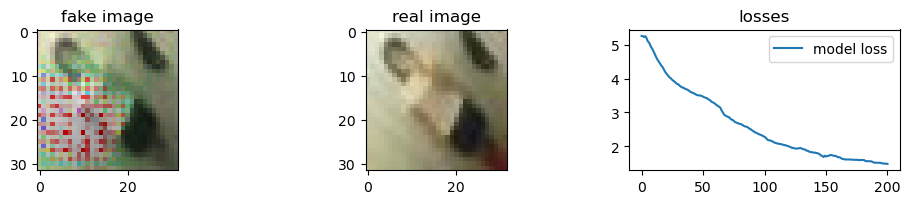

Epoch 201/1000: <=> ------- model loss = 1.4810118675231934, time = 0.0s
Epoch 202/1000: <=> ------- model loss = 1.4801864624023438, time = 0.0s
Epoch 203/1000: <=> ------- model loss = 1.476991891860962, time = 0.0s
Epoch 204/1000: <=> ------- model loss = 1.476250171661377, time = 0.0s
Epoch 205/1000: <=> ------- model loss = 1.4756170511245728, time = 0.0s

Validation loss = 0


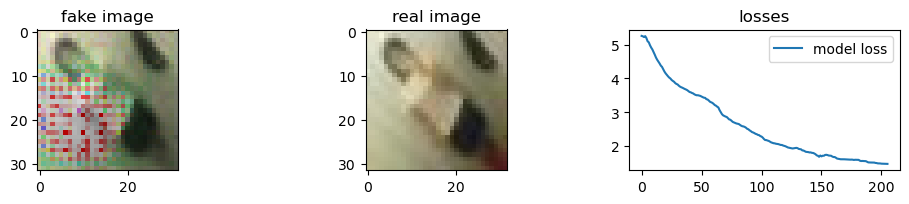

Epoch 206/1000: <=> ------- model loss = 1.478055715560913, time = 0.0s
Epoch 207/1000: <=> ------- model loss = 1.4774731397628784, time = 0.0s
Epoch 208/1000: <=> ------- model loss = 1.4768942594528198, time = 0.0s
Epoch 209/1000: <=> ------- model loss = 1.476318359375, time = 0.0s
Epoch 210/1000: <=> ------- model loss = 1.4757699966430664, time = 0.0s

Validation loss = 0


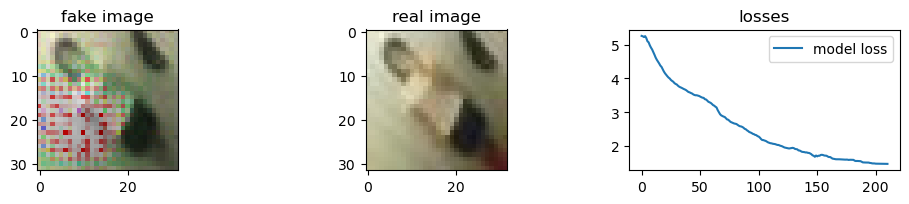

Epoch 211/1000: <=> ------- model loss = 1.4752376079559326, time = 0.0s
Epoch 212/1000: <=> ------- model loss = 1.4747107028961182, time = 0.0s
Epoch 213/1000: <=> ------- model loss = 1.4741902351379395, time = 0.0s
Epoch 214/1000: <=> ------- model loss = 1.4736862182617188, time = 0.0s
Epoch 215/1000: <=> ------- model loss = 1.469983458518982, time = 0.0s

Validation loss = 0


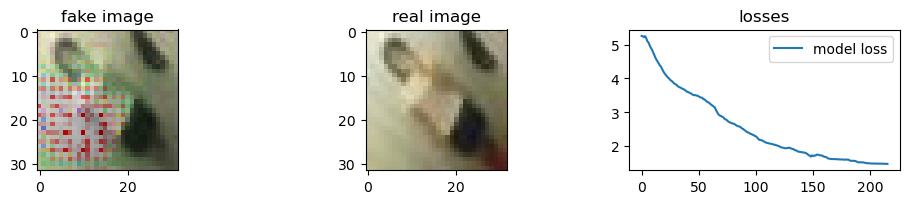

Epoch 216/1000: <=> ------- model loss = 1.4694143533706665, time = 0.0s
Epoch 217/1000: <=> ------- model loss = 1.4689708948135376, time = 0.0s
Epoch 218/1000: <=> ------- model loss = 1.4685611724853516, time = 0.0s
Epoch 219/1000: <=> ------- model loss = 1.4681700468063354, time = 0.0s
Epoch 220/1000: <=> ------- model loss = 1.467783808708191, time = 0.0s

Validation loss = 0


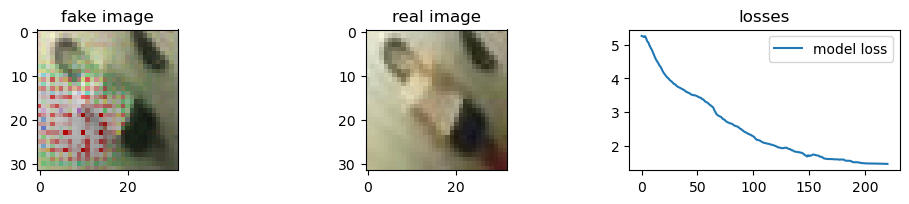

Epoch 221/1000: <=> ------- model loss = 1.4673962593078613, time = 0.0s
Epoch 222/1000: <=> ------- model loss = 1.4670120477676392, time = 0.0s
Epoch 223/1000: <=> ------- model loss = 1.466637134552002, time = 0.0s
Epoch 224/1000: <=> ------- model loss = 1.4662736654281616, time = 0.0s
Epoch 225/1000: <=> ------- model loss = 1.4659268856048584, time = 0.0s

Validation loss = 0


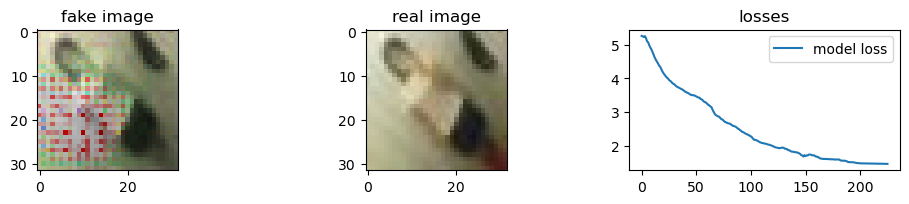

Epoch 226/1000: <=> ------- model loss = 1.4655938148498535, time = 0.0s
Epoch 227/1000: <=> ------- model loss = 1.4652750492095947, time = 0.0s
Epoch 228/1000: <=> ------- model loss = 1.4649673700332642, time = 0.0s
Epoch 229/1000: <=> ------- model loss = 1.4646670818328857, time = 0.0s
Epoch 230/1000: <=> ------- model loss = 1.4643747806549072, time = 0.0s

Validation loss = 0


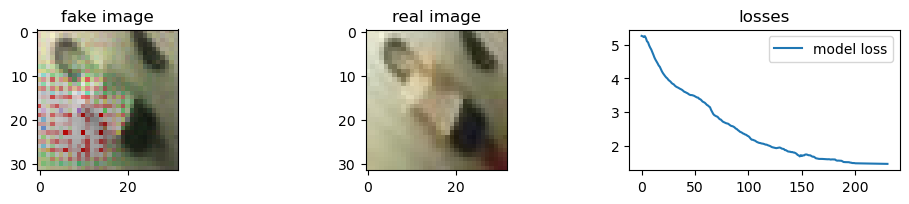

Epoch 231/1000: <=> ------- model loss = 1.4640886783599854, time = 0.0s
Epoch 232/1000: <=> ------- model loss = 1.4638042449951172, time = 0.0s
Epoch 233/1000: <=> ------- model loss = 1.4635225534439087, time = 0.0s
Epoch 234/1000: <=> ------- model loss = 1.4632445573806763, time = 0.0s
Epoch 235/1000: <=> ------- model loss = 1.4629744291305542, time = 0.0s

Validation loss = 0


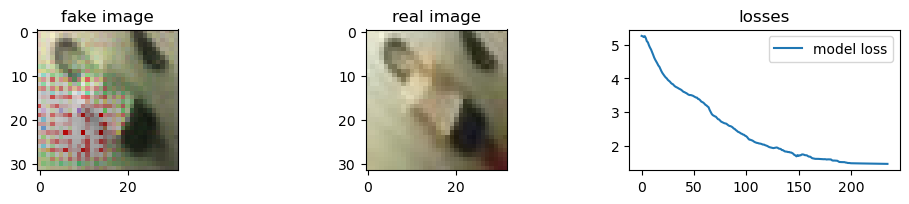

Epoch 236/1000: <=> ------- model loss = 1.4627113342285156, time = 0.0s
Epoch 237/1000: <=> ------- model loss = 1.4624571800231934, time = 0.0s
Epoch 238/1000: <=> ------- model loss = 1.4622102975845337, time = 0.0s
Epoch 239/1000: <=> ------- model loss = 1.4619684219360352, time = 0.0s
Epoch 240/1000: <=> ------- model loss = 1.459423303604126, time = 0.0s

Validation loss = 0


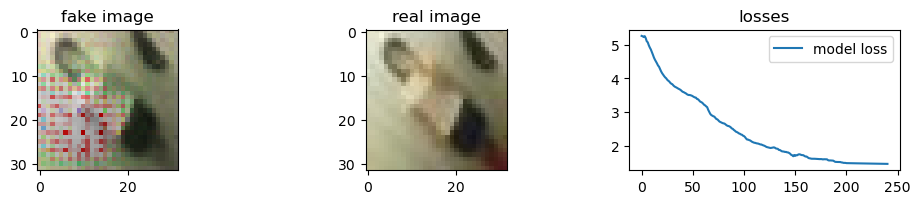

Epoch 241/1000: <=> ------- model loss = 1.4591134786605835, time = 0.0s
Epoch 242/1000: <=> ------- model loss = 1.4588698148727417, time = 0.0s
Epoch 243/1000: <=> ------- model loss = 1.4586374759674072, time = 0.0s
Epoch 244/1000: <=> ------- model loss = 1.45841383934021, time = 0.0s
Epoch 245/1000: <=> ------- model loss = 1.458198070526123, time = 0.0s

Validation loss = 0


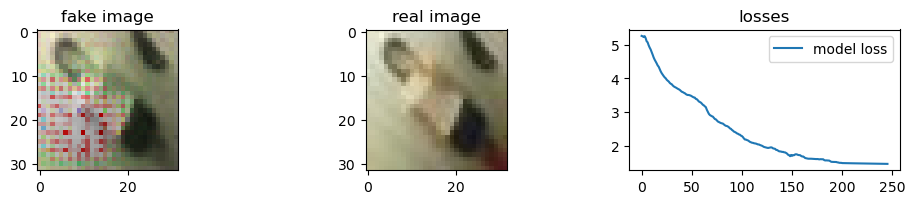

Epoch 246/1000: <=> ------- model loss = 1.4579887390136719, time = 0.0s
Epoch 247/1000: <=> ------- model loss = 1.45778489112854, time = 0.0s
Epoch 248/1000: <=> ------- model loss = 1.4575860500335693, time = 0.0s
Epoch 249/1000: <=> ------- model loss = 1.4540023803710938, time = 0.0s
Epoch 250/1000: <=> ------- model loss = 1.4537031650543213, time = 0.0s

Validation loss = 0


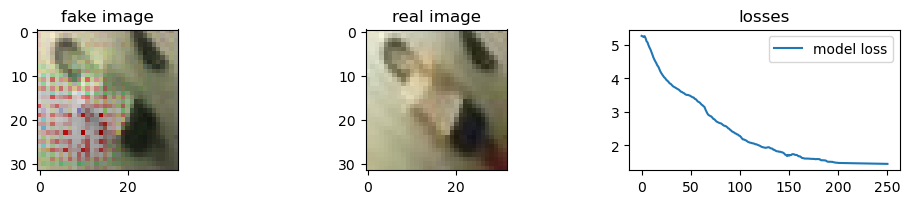

Epoch 251/1000: <=> ------- model loss = 1.4534897804260254, time = 0.0s
Epoch 252/1000: <=> ------- model loss = 1.453292727470398, time = 0.0s
Epoch 253/1000: <=> ------- model loss = 1.4531004428863525, time = 0.0s
Epoch 254/1000: <=> ------- model loss = 1.4529075622558594, time = 0.0s
Epoch 255/1000: <=> ------- model loss = 1.4489504098892212, time = 0.0s

Validation loss = 0


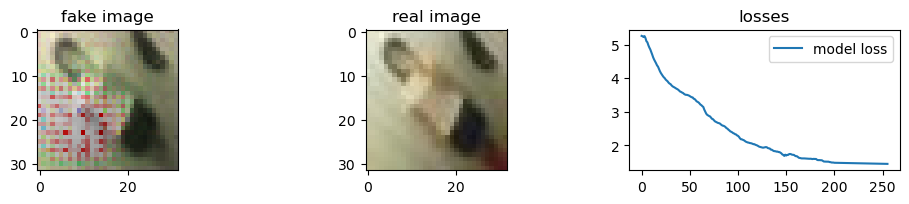

Epoch 256/1000: <=> ------- model loss = 1.4444339275360107, time = 0.0s
Epoch 257/1000: <=> ------- model loss = 1.4441101551055908, time = 0.0s
Epoch 258/1000: <=> ------- model loss = 1.4438912868499756, time = 0.0s
Epoch 259/1000: <=> ------- model loss = 1.4436912536621094, time = 0.0s
Epoch 260/1000: <=> ------- model loss = 1.4434996843338013, time = 0.0s

Validation loss = 0


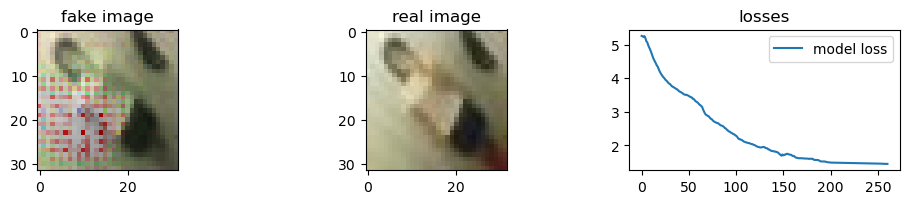

Epoch 261/1000: <=> ------- model loss = 1.4358844757080078, time = 0.0s
Epoch 262/1000: <=> ------- model loss = 1.435628890991211, time = 0.0s
Epoch 263/1000: <=> ------- model loss = 1.4408388137817383, time = 0.0s
Epoch 264/1000: <=> ------- model loss = 1.4407329559326172, time = 0.0s
Epoch 265/1000: <=> ------- model loss = 1.4404692649841309, time = 0.0s

Validation loss = 0


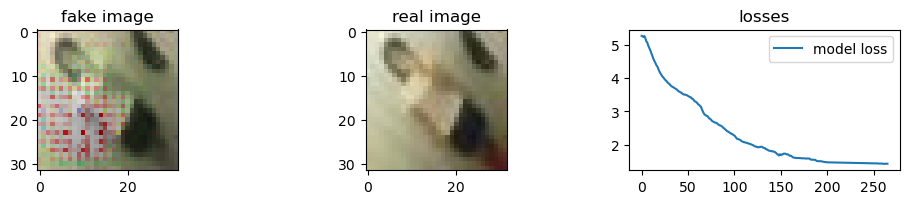

Epoch 266/1000: <=> ------- model loss = 1.4374866485595703, time = 0.0s
Epoch 267/1000: <=> ------- model loss = 1.4371767044067383, time = 0.0s
Epoch 268/1000: <=> ------- model loss = 1.4290343523025513, time = 0.0s
Epoch 269/1000: <=> ------- model loss = 1.4247753620147705, time = 0.0s
Epoch 270/1000: <=> ------- model loss = 1.4148329496383667, time = 0.0s

Validation loss = 0


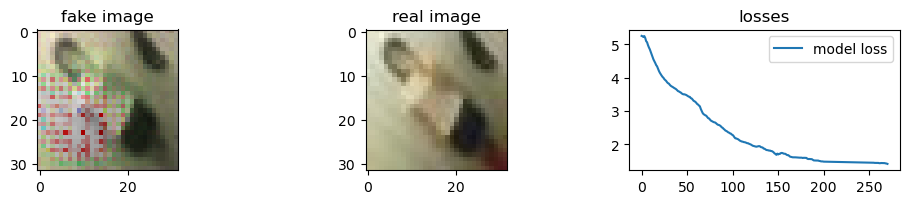

Epoch 271/1000: <=> ------- model loss = 1.4091079235076904, time = 0.0s
Epoch 272/1000: <=> ------- model loss = 1.3985419273376465, time = 0.0s
Epoch 273/1000: <=> ------- model loss = 1.3949432373046875, time = 0.0s
Epoch 274/1000: <=> ------- model loss = 1.3857157230377197, time = 0.0s
Epoch 275/1000: <=> ------- model loss = 1.3780057430267334, time = 0.0s

Validation loss = 0


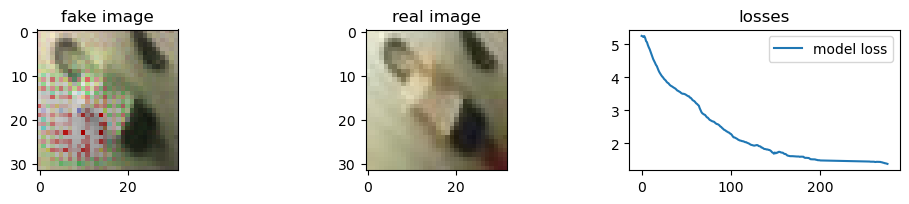

Epoch 276/1000: <=> ------- model loss = 1.3777092695236206, time = 0.0s
Epoch 277/1000: <=> ------- model loss = 1.3732823133468628, time = 0.0s
Epoch 278/1000: <=> ------- model loss = 1.373061180114746, time = 0.0s
Epoch 279/1000: <=> ------- model loss = 1.3677153587341309, time = 0.0s
Epoch 280/1000: <=> ------- model loss = 1.364832878112793, time = 0.0s

Validation loss = 0


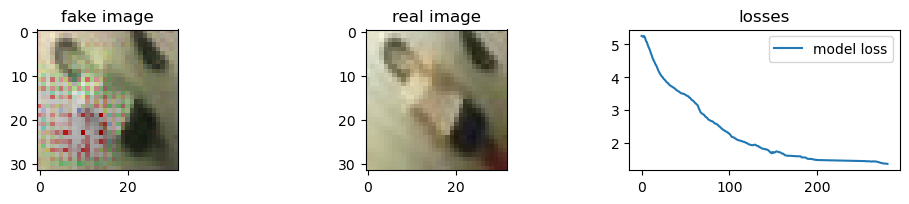

Epoch 281/1000: <=> ------- model loss = 1.3608355522155762, time = 0.0s
Epoch 282/1000: <=> ------- model loss = 1.3606557846069336, time = 0.0s
Epoch 283/1000: <=> ------- model loss = 1.3579579591751099, time = 0.0s
Epoch 284/1000: <=> ------- model loss = 1.3551955223083496, time = 0.0s
Epoch 285/1000: <=> ------- model loss = 1.3513298034667969, time = 0.0s

Validation loss = 0


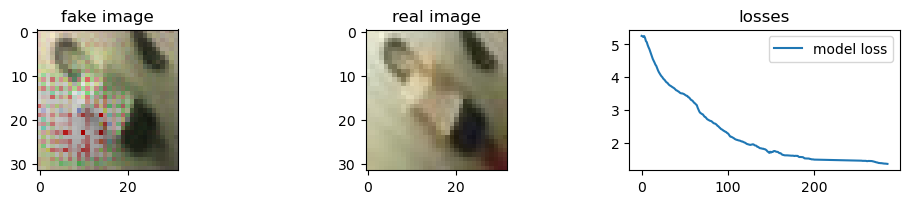

Epoch 286/1000: <=> ------- model loss = 1.3511136770248413, time = 0.0s
Epoch 287/1000: <=> ------- model loss = 1.3509283065795898, time = 0.0s
Epoch 288/1000: <=> ------- model loss = 1.3483855724334717, time = 0.0s
Epoch 289/1000: <=> ------- model loss = 1.348196029663086, time = 0.0s
Epoch 290/1000: <=> ------- model loss = 1.3480236530303955, time = 0.0s

Validation loss = 0


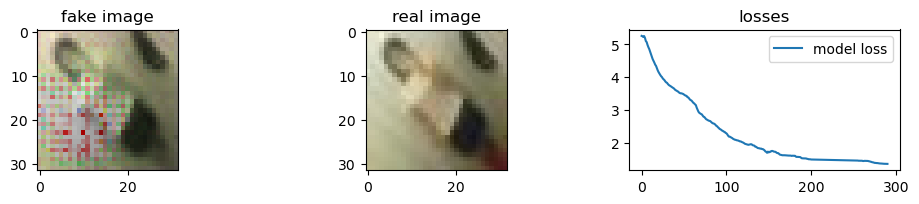

Epoch 291/1000: <=> ------- model loss = 1.34786057472229, time = 0.0s
Epoch 292/1000: <=> ------- model loss = 1.3477058410644531, time = 0.0s
Epoch 293/1000: <=> ------- model loss = 1.344773530960083, time = 0.0s
Epoch 294/1000: <=> ------- model loss = 1.336246132850647, time = 0.0s
Epoch 295/1000: <=> ------- model loss = 1.335667610168457, time = 0.0s

Validation loss = 0


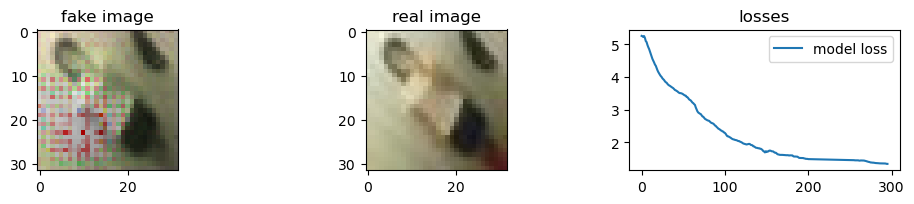

Epoch 296/1000: <=> ------- model loss = 1.335575819015503, time = 0.0s
Epoch 297/1000: <=> ------- model loss = 1.3304529190063477, time = 0.0s
Epoch 298/1000: <=> ------- model loss = 1.3303816318511963, time = 0.0s
Epoch 299/1000: <=> ------- model loss = 1.330336093902588, time = 0.0s
Epoch 300/1000: <=> ------- model loss = 1.3302870988845825, time = 0.0s

Validation loss = 0


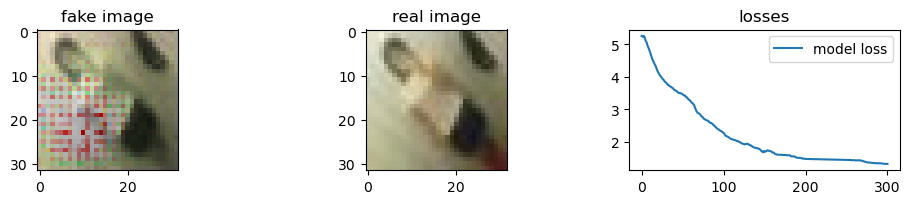

Epoch 301/1000: <=> ------- model loss = 1.3301891088485718, time = 0.0s
Epoch 302/1000: <=> ------- model loss = 1.33004891872406, time = 0.0s
Epoch 303/1000: <=> ------- model loss = 1.3299041986465454, time = 0.0s
Epoch 304/1000: <=> ------- model loss = 1.3297560214996338, time = 0.0s
Epoch 305/1000: <=> ------- model loss = 1.329606056213379, time = 0.0s

Validation loss = 0


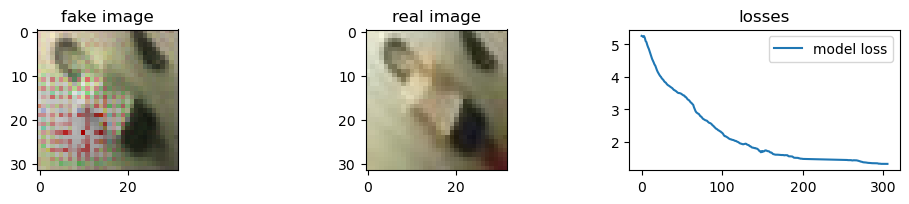

Epoch 306/1000: <=> ------- model loss = 1.3294587135314941, time = 0.0s
Epoch 307/1000: <=> ------- model loss = 1.3293092250823975, time = 0.0s
Epoch 308/1000: <=> ------- model loss = 1.3291535377502441, time = 0.0s
Epoch 309/1000: <=> ------- model loss = 1.3289984464645386, time = 0.0s
Epoch 310/1000: <=> ------- model loss = 1.3288582563400269, time = 0.0s

Validation loss = 0


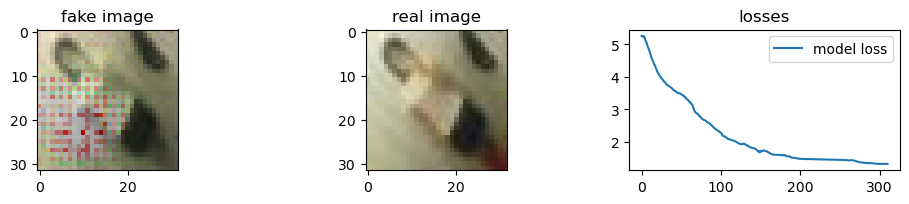

Epoch 311/1000: <=> ------- model loss = 1.3287227153778076, time = 0.0s
Epoch 312/1000: <=> ------- model loss = 1.3285950422286987, time = 0.0s
Epoch 313/1000: <=> ------- model loss = 1.3284683227539062, time = 0.0s
Epoch 314/1000: <=> ------- model loss = 1.3283421993255615, time = 0.0s
Epoch 315/1000: <=> ------- model loss = 1.3282216787338257, time = 0.0s

Validation loss = 0


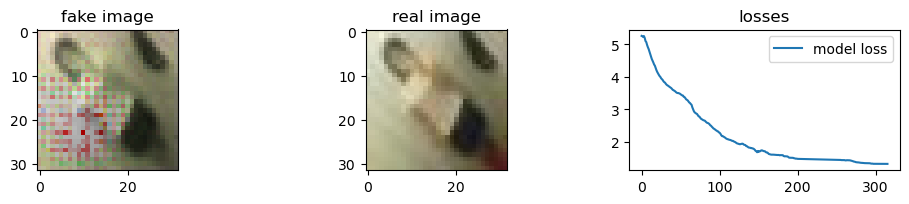

Epoch 316/1000: <=> ------- model loss = 1.3251328468322754, time = 0.0s
Epoch 317/1000: <=> ------- model loss = 1.3249704837799072, time = 0.0s
Epoch 318/1000: <=> ------- model loss = 1.3248515129089355, time = 0.0s
Epoch 319/1000: <=> ------- model loss = 1.3247363567352295, time = 0.0s
Epoch 320/1000: <=> ------- model loss = 1.3246209621429443, time = 0.0s

Validation loss = 0


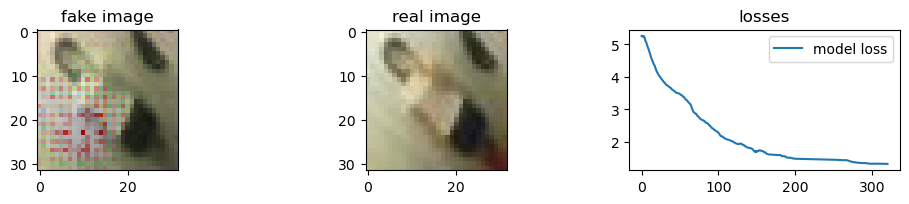

Epoch 321/1000: <=> ------- model loss = 1.324517011642456, time = 0.0s
Epoch 322/1000: <=> ------- model loss = 1.3244123458862305, time = 0.0s
Epoch 323/1000: <=> ------- model loss = 1.3243151903152466, time = 0.0s
Epoch 324/1000: <=> ------- model loss = 1.3242199420928955, time = 0.0s
Epoch 325/1000: <=> ------- model loss = 1.324124813079834, time = 0.0s

Validation loss = 0


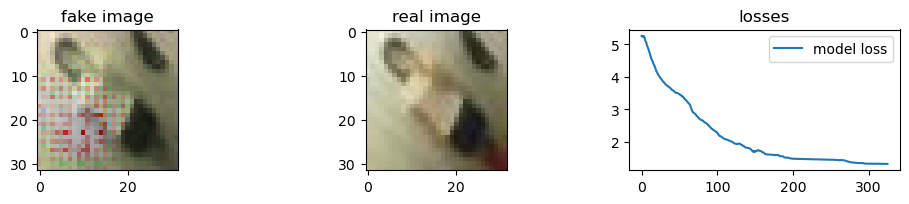

Epoch 326/1000: <=> ------- model loss = 1.3240387439727783, time = 0.0s
Epoch 327/1000: <=> ------- model loss = 1.3239467144012451, time = 0.0s
Epoch 328/1000: <=> ------- model loss = 1.3238499164581299, time = 0.0s
Epoch 329/1000: <=> ------- model loss = 1.3237504959106445, time = 0.0s
Epoch 330/1000: <=> ------- model loss = 1.3181334733963013, time = 0.0s

Validation loss = 0


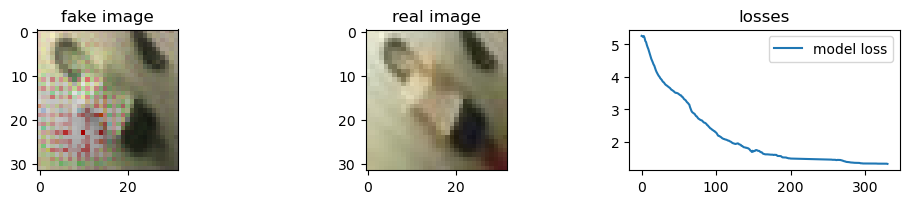

Epoch 331/1000: <=> ------- model loss = 1.30300772190094, time = 0.0s
Epoch 332/1000: <=> ------- model loss = 1.3004599809646606, time = 0.0s
Epoch 333/1000: <=> ------- model loss = 1.3005346059799194, time = 0.0s
Epoch 334/1000: <=> ------- model loss = 1.3004279136657715, time = 0.0s
Epoch 335/1000: <=> ------- model loss = 1.3002724647521973, time = 0.0s

Validation loss = 0


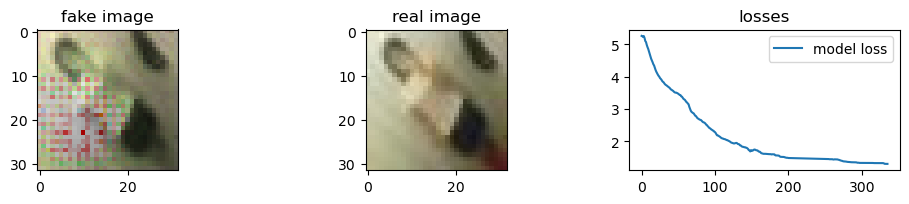

Epoch 336/1000: <=> ------- model loss = 1.3000775575637817, time = 0.0s
Epoch 337/1000: <=> ------- model loss = 1.2925975322723389, time = 0.0s
Epoch 338/1000: <=> ------- model loss = 1.2922205924987793, time = 0.0s
Epoch 339/1000: <=> ------- model loss = 1.287268877029419, time = 0.0s
Epoch 340/1000: <=> ------- model loss = 1.2869341373443604, time = 0.0s

Validation loss = 0


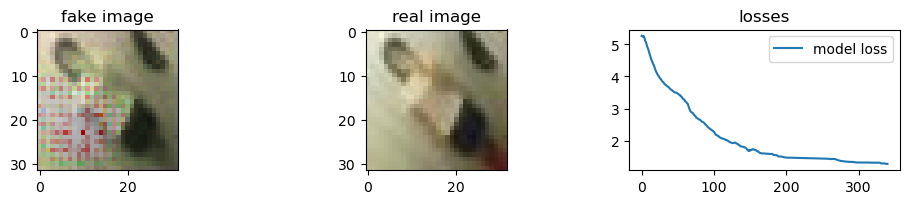

Epoch 341/1000: <=> ------- model loss = 1.2797173261642456, time = 0.0s
Epoch 342/1000: <=> ------- model loss = 1.2794485092163086, time = 0.0s
Epoch 343/1000: <=> ------- model loss = 1.279223918914795, time = 0.0s
Epoch 344/1000: <=> ------- model loss = 1.2790671586990356, time = 0.0s
Epoch 345/1000: <=> ------- model loss = 1.2789210081100464, time = 0.0s

Validation loss = 0


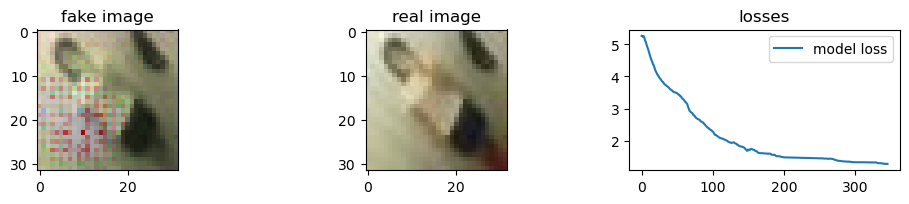

Epoch 346/1000: <=> ------- model loss = 1.2788169384002686, time = 0.0s
Epoch 347/1000: <=> ------- model loss = 1.2786539793014526, time = 0.0s
Epoch 348/1000: <=> ------- model loss = 1.2785531282424927, time = 0.0s
Epoch 349/1000: <=> ------- model loss = 1.2784310579299927, time = 0.0s
Epoch 350/1000: <=> ------- model loss = 1.273961067199707, time = 0.0s

Validation loss = 0


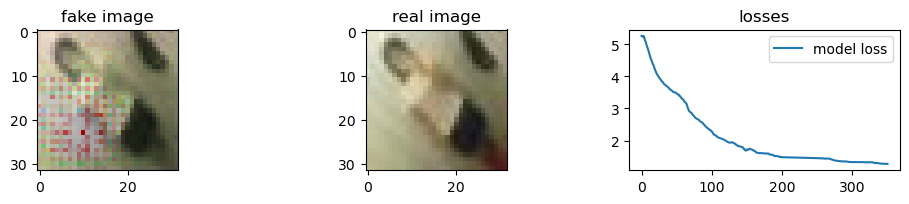

Epoch 351/1000: <=> ------- model loss = 1.2623330354690552, time = 0.0s
Epoch 352/1000: <=> ------- model loss = 1.2540819644927979, time = 0.0s
Epoch 353/1000: <=> ------- model loss = 1.2539030313491821, time = 0.0s
Epoch 354/1000: <=> ------- model loss = 1.2385751008987427, time = 0.0s
Epoch 355/1000: <=> ------- model loss = 1.2381930351257324, time = 0.0s

Validation loss = 0


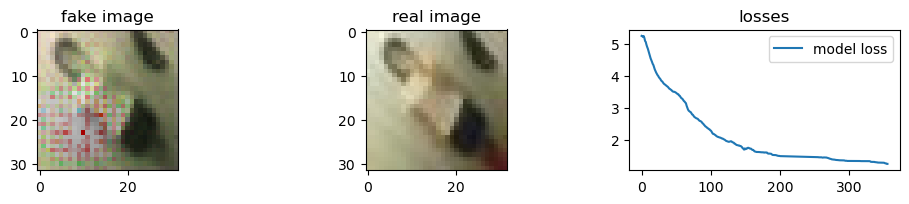

Epoch 356/1000: <=> ------- model loss = 1.234238624572754, time = 0.0s
Epoch 357/1000: <=> ------- model loss = 1.2275662422180176, time = 0.0s
Epoch 358/1000: <=> ------- model loss = 1.2052319049835205, time = 0.0s
Epoch 359/1000: <=> ------- model loss = 1.1936490535736084, time = 0.0s
Epoch 360/1000: <=> ------- model loss = 1.193881630897522, time = 0.0s

Validation loss = 0


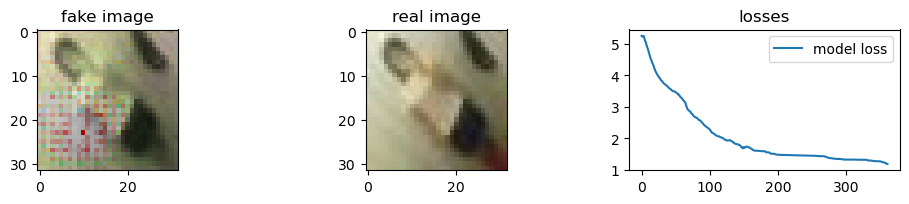

Epoch 361/1000: <=> ------- model loss = 1.1939648389816284, time = 0.0s
Epoch 362/1000: <=> ------- model loss = 1.1940009593963623, time = 0.0s
Epoch 363/1000: <=> ------- model loss = 1.1885924339294434, time = 0.0s
Epoch 364/1000: <=> ------- model loss = 1.1808385848999023, time = 0.0s
Epoch 365/1000: <=> ------- model loss = 1.1802607774734497, time = 0.0s

Validation loss = 0


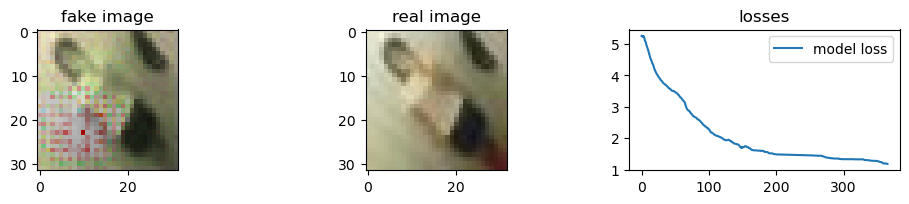

Epoch 366/1000: <=> ------- model loss = 1.1798144578933716, time = 0.0s
Epoch 367/1000: <=> ------- model loss = 1.175507664680481, time = 0.0s
Epoch 368/1000: <=> ------- model loss = 1.172220230102539, time = 0.0s
Epoch 369/1000: <=> ------- model loss = 1.171994924545288, time = 0.0s
Epoch 370/1000: <=> ------- model loss = 1.1686246395111084, time = 0.0s

Validation loss = 0


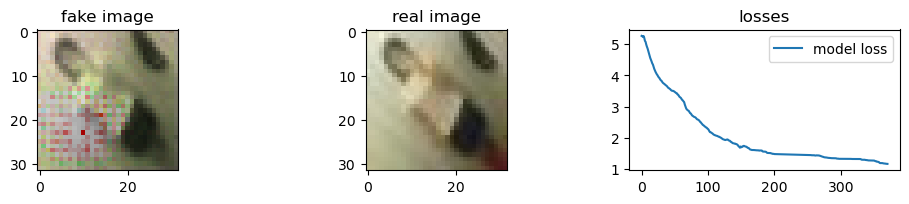

Epoch 371/1000: <=> ------- model loss = 1.1684646606445312, time = 0.0s
Epoch 372/1000: <=> ------- model loss = 1.1683158874511719, time = 0.0s
Epoch 373/1000: <=> ------- model loss = 1.1652228832244873, time = 0.0s
Epoch 374/1000: <=> ------- model loss = 1.1618099212646484, time = 0.0s
Epoch 375/1000: <=> ------- model loss = 1.1615577936172485, time = 0.0s

Validation loss = 0


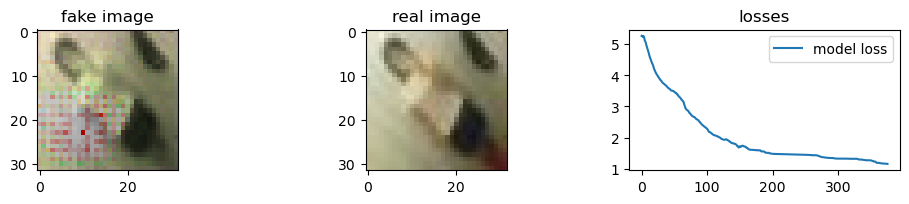

Epoch 376/1000: <=> ------- model loss = 1.1614363193511963, time = 0.0s
Epoch 377/1000: <=> ------- model loss = 1.1613680124282837, time = 0.0s
Epoch 378/1000: <=> ------- model loss = 1.1612493991851807, time = 0.0s
Epoch 379/1000: <=> ------- model loss = 1.161123275756836, time = 0.0s
Epoch 380/1000: <=> ------- model loss = 1.161001443862915, time = 0.0s

Validation loss = 0


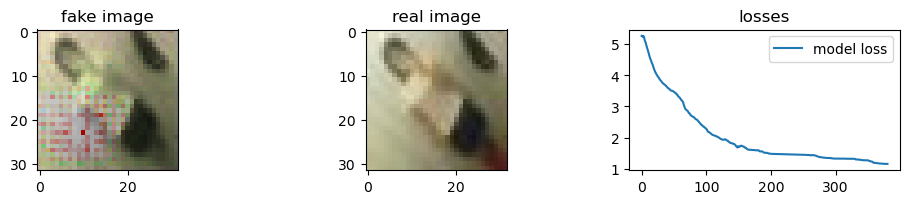

Epoch 381/1000: <=> ------- model loss = 1.1608794927597046, time = 0.0s
Epoch 382/1000: <=> ------- model loss = 1.1607913970947266, time = 0.0s
Epoch 383/1000: <=> ------- model loss = 1.1607335805892944, time = 0.0s
Epoch 384/1000: <=> ------- model loss = 1.1606788635253906, time = 0.0s
Epoch 385/1000: <=> ------- model loss = 1.160605788230896, time = 0.0s

Validation loss = 0


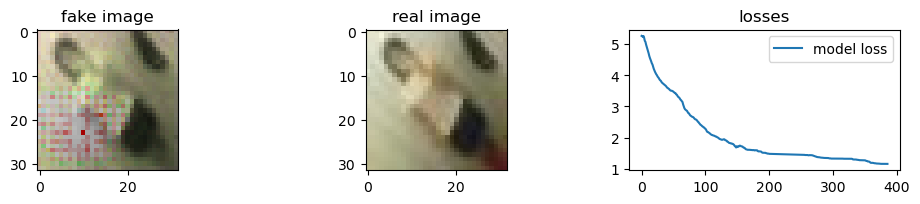

Epoch 386/1000: <=> ------- model loss = 1.160529613494873, time = 0.0s
Epoch 387/1000: <=> ------- model loss = 1.1604665517807007, time = 0.0s
Epoch 388/1000: <=> ------- model loss = 1.1604028940200806, time = 0.0s
Epoch 389/1000: <=> ------- model loss = 1.1603569984436035, time = 0.0s
Epoch 390/1000: <=> ------- model loss = 1.1602853536605835, time = 0.0s

Validation loss = 0


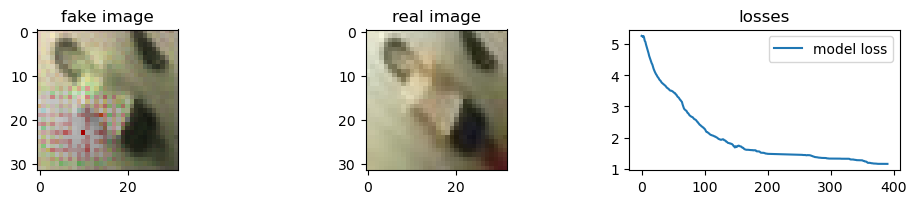

Epoch 391/1000: <=> ------- model loss = 1.1602120399475098, time = 0.0s
Epoch 392/1000: <=> ------- model loss = 1.1601498126983643, time = 0.0s
Epoch 393/1000: <=> ------- model loss = 1.1600886583328247, time = 0.0s
Epoch 394/1000: <=> ------- model loss = 1.1600208282470703, time = 0.0s
Epoch 395/1000: <=> ------- model loss = 1.1599708795547485, time = 0.0s

Validation loss = 0


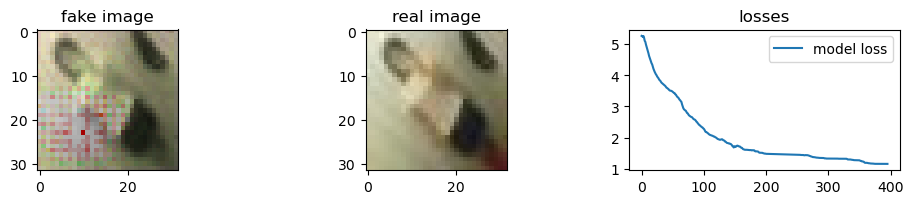

Epoch 396/1000: <=> ------- model loss = 1.1598901748657227, time = 0.0s
Epoch 397/1000: <=> ------- model loss = 1.15984046459198, time = 0.0s
Epoch 398/1000: <=> ------- model loss = 1.159782886505127, time = 0.0s
Epoch 399/1000: <=> ------- model loss = 1.1597201824188232, time = 0.0s
Epoch 400/1000: <=> ------- model loss = 1.159660816192627, time = 0.0s

Validation loss = 0


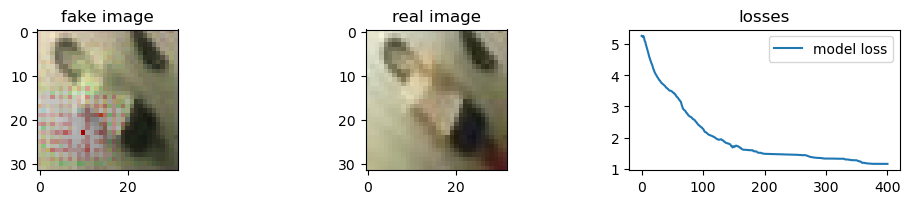

Epoch 401/1000: <=> ------- model loss = 1.159611463546753, time = 0.0s
Epoch 402/1000: <=> ------- model loss = 1.1595399379730225, time = 0.0s
Epoch 403/1000: <=> ------- model loss = 1.1594924926757812, time = 0.0s
Epoch 404/1000: <=> ------- model loss = 1.159440040588379, time = 0.0s
Epoch 405/1000: <=> ------- model loss = 1.1593855619430542, time = 0.0s

Validation loss = 0


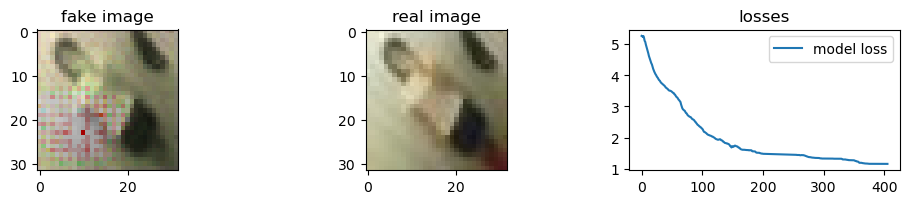

Epoch 406/1000: <=> ------- model loss = 1.1593289375305176, time = 0.0s
Epoch 407/1000: <=> ------- model loss = 1.1592745780944824, time = 0.0s
Epoch 408/1000: <=> ------- model loss = 1.15921950340271, time = 0.0s
Epoch 409/1000: <=> ------- model loss = 1.1591708660125732, time = 0.0s
Epoch 410/1000: <=> ------- model loss = 1.1591147184371948, time = 0.0s

Validation loss = 0


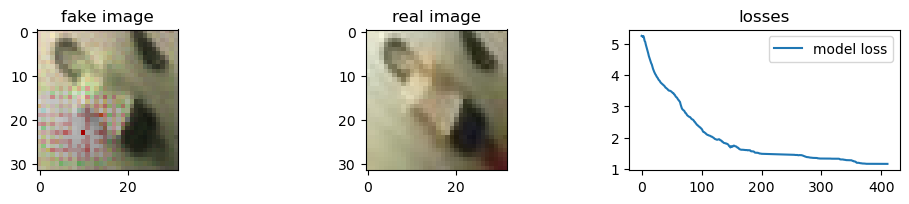

Epoch 411/1000: <=> ------- model loss = 1.1590580940246582, time = 0.0s
Epoch 412/1000: <=> ------- model loss = 1.159005880355835, time = 0.0s
Epoch 413/1000: <=> ------- model loss = 1.1589610576629639, time = 0.0s
Epoch 414/1000: <=> ------- model loss = 1.1589205265045166, time = 0.0s
Epoch 415/1000: <=> ------- model loss = 1.1588633060455322, time = 0.0s

Validation loss = 0


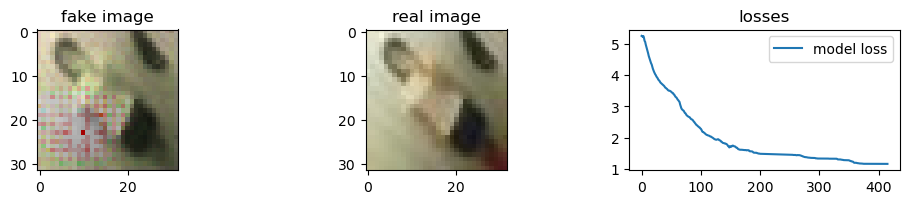

Epoch 416/1000: <=> ------- model loss = 1.1588168144226074, time = 0.0s
Epoch 417/1000: <=> ------- model loss = 1.1587660312652588, time = 0.0s
Epoch 418/1000: <=> ------- model loss = 1.1587181091308594, time = 0.0s
Epoch 419/1000: <=> ------- model loss = 1.1586723327636719, time = 0.0s
Epoch 420/1000: <=> ------- model loss = 1.158637285232544, time = 0.0s

Validation loss = 0


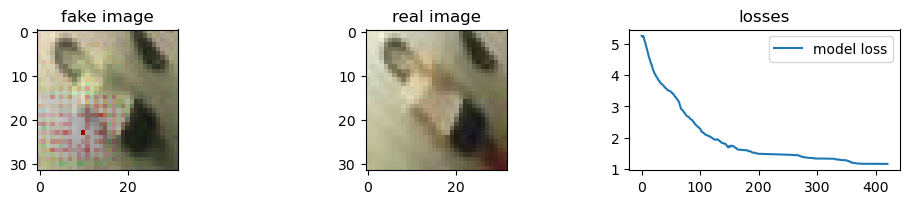

Epoch 421/1000: <=> ------- model loss = 1.1585886478424072, time = 0.0s
Epoch 422/1000: <=> ------- model loss = 1.1585437059402466, time = 0.0s
Epoch 423/1000: <=> ------- model loss = 1.1585030555725098, time = 0.0s
Epoch 424/1000: <=> ------- model loss = 1.1584513187408447, time = 0.0s
Epoch 425/1000: <=> ------- model loss = 1.1584084033966064, time = 0.0s

Validation loss = 0


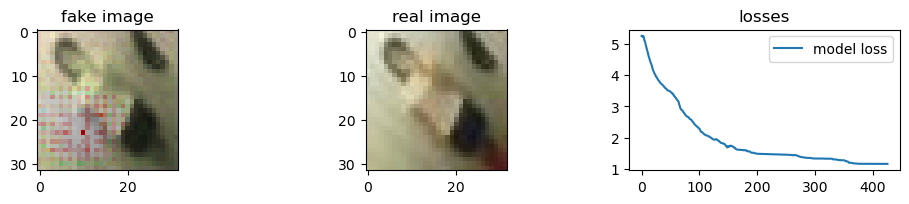

Epoch 426/1000: <=> ------- model loss = 1.1583551168441772, time = 0.0s
Epoch 427/1000: <=> ------- model loss = 1.158315658569336, time = 0.0s
Epoch 428/1000: <=> ------- model loss = 1.1582705974578857, time = 0.0s
Epoch 429/1000: <=> ------- model loss = 1.158259630203247, time = 0.0s
Epoch 430/1000: <=> ------- model loss = 1.1582587957382202, time = 0.0s

Validation loss = 0


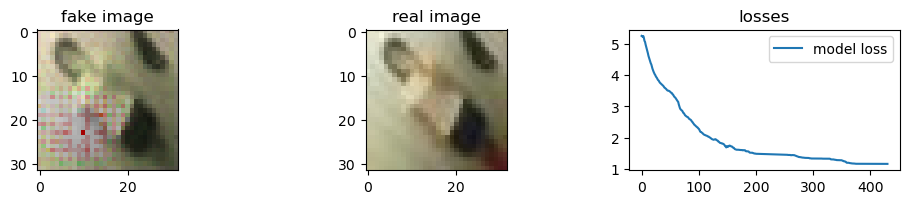

Epoch 431/1000: <=> ------- model loss = 1.1582317352294922, time = 0.0s
Epoch 432/1000: <=> ------- model loss = 1.1581652164459229, time = 0.0s
Epoch 433/1000: <=> ------- model loss = 1.1580857038497925, time = 0.0s
Epoch 434/1000: <=> ------- model loss = 1.158034324645996, time = 0.0s
Epoch 435/1000: <=> ------- model loss = 1.1579985618591309, time = 0.0s

Validation loss = 0


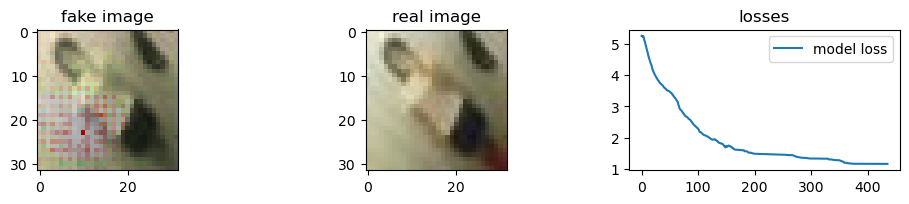

Epoch 436/1000: <=> ------- model loss = 1.1579244136810303, time = 0.0s
Epoch 437/1000: <=> ------- model loss = 1.1578863859176636, time = 0.0s
Epoch 438/1000: <=> ------- model loss = 1.1578381061553955, time = 0.0s
Epoch 439/1000: <=> ------- model loss = 1.1577751636505127, time = 0.0s
Epoch 440/1000: <=> ------- model loss = 1.1577404737472534, time = 0.0s

Validation loss = 0


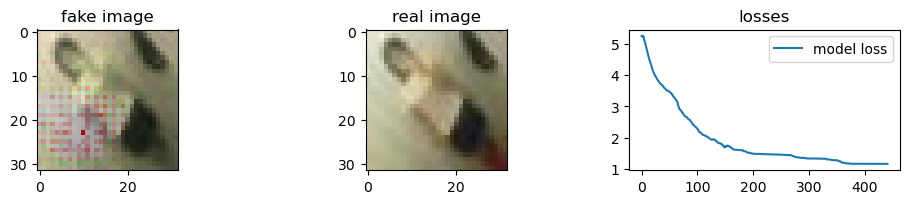

Epoch 441/1000: <=> ------- model loss = 1.1576921939849854, time = 0.0s
Epoch 442/1000: <=> ------- model loss = 1.1576476097106934, time = 0.0s
Epoch 443/1000: <=> ------- model loss = 1.157609462738037, time = 0.0s
Epoch 444/1000: <=> ------- model loss = 1.1575666666030884, time = 0.0s
Epoch 445/1000: <=> ------- model loss = 1.1575196981430054, time = 0.0s

Validation loss = 0


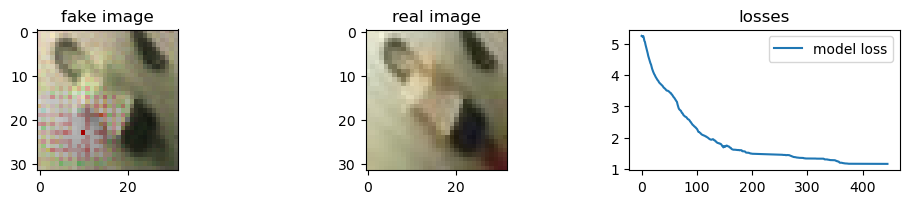

Epoch 446/1000: <=> ------- model loss = 1.157476782798767, time = 0.0s
Epoch 447/1000: <=> ------- model loss = 1.1574578285217285, time = 0.0s
Epoch 448/1000: <=> ------- model loss = 1.153754711151123, time = 0.0s
Epoch 449/1000: <=> ------- model loss = 1.1470860242843628, time = 0.0s
Epoch 450/1000: <=> ------- model loss = 1.1560603380203247, time = 0.0s

Validation loss = 0


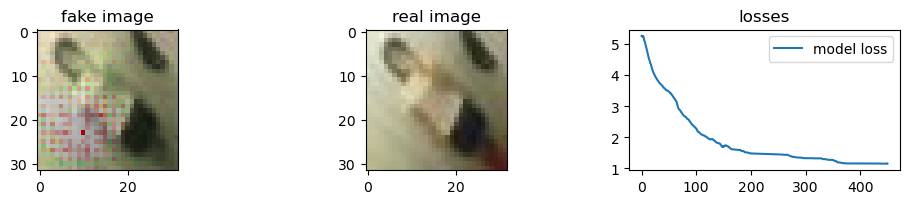

Epoch 451/1000: <=> ------- model loss = 1.1486318111419678, time = 0.0s
Epoch 452/1000: <=> ------- model loss = 1.14476478099823, time = 0.0s
Epoch 453/1000: <=> ------- model loss = 1.1411503553390503, time = 0.0s
Epoch 454/1000: <=> ------- model loss = 1.1413936614990234, time = 0.0s
Epoch 455/1000: <=> ------- model loss = 1.1354520320892334, time = 0.0s

Validation loss = 0


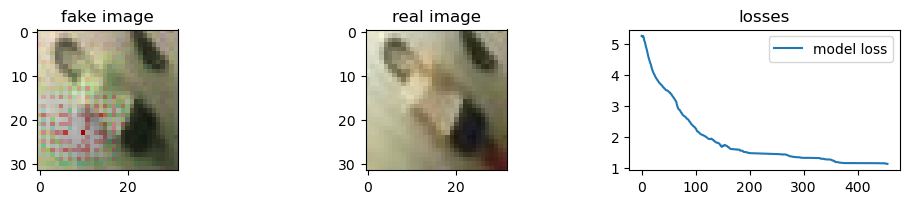

Epoch 456/1000: <=> ------- model loss = 1.1354339122772217, time = 0.0s
Epoch 457/1000: <=> ------- model loss = 1.132613182067871, time = 0.0s
Epoch 458/1000: <=> ------- model loss = 1.1253879070281982, time = 0.0s
Epoch 459/1000: <=> ------- model loss = 1.1193630695343018, time = 0.0s
Epoch 460/1000: <=> ------- model loss = 1.1191303730010986, time = 0.0s

Validation loss = 0


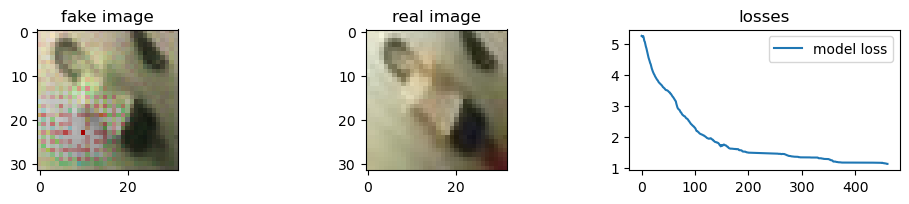

Epoch 461/1000: <=> ------- model loss = 1.1154448986053467, time = 0.0s
Epoch 462/1000: <=> ------- model loss = 1.108402132987976, time = 0.0s
Epoch 463/1000: <=> ------- model loss = 1.097278356552124, time = 0.0s
Epoch 464/1000: <=> ------- model loss = 1.0946495532989502, time = 0.0s
Epoch 465/1000: <=> ------- model loss = 1.091103434562683, time = 0.0s

Validation loss = 0


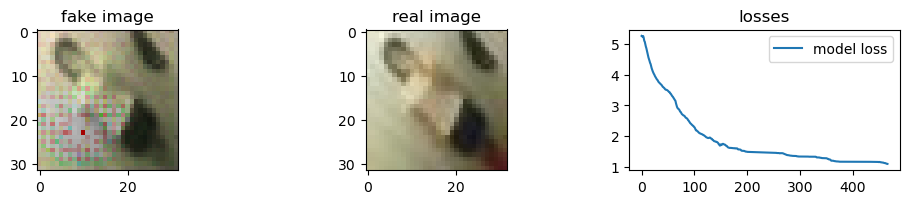

Epoch 466/1000: <=> ------- model loss = 1.0911307334899902, time = 0.0s
Epoch 467/1000: <=> ------- model loss = 1.0840775966644287, time = 0.0s
Epoch 468/1000: <=> ------- model loss = 1.0708938837051392, time = 0.0s
Epoch 469/1000: <=> ------- model loss = 1.0705572366714478, time = 0.0s
Epoch 470/1000: <=> ------- model loss = 1.0705150365829468, time = 0.0s

Validation loss = 0


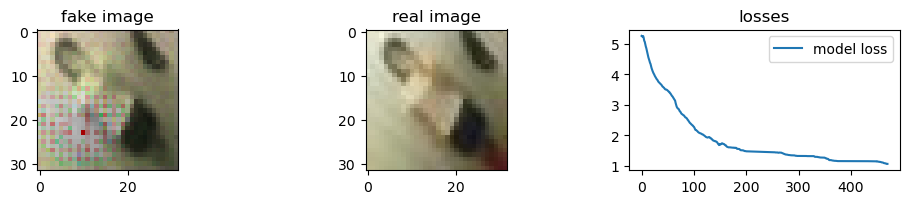

Epoch 471/1000: <=> ------- model loss = 1.0676090717315674, time = 0.0s
Epoch 472/1000: <=> ------- model loss = 1.0644515752792358, time = 0.0s
Epoch 473/1000: <=> ------- model loss = 1.0642915964126587, time = 0.0s
Epoch 474/1000: <=> ------- model loss = 1.0641463994979858, time = 0.0s
Epoch 475/1000: <=> ------- model loss = 1.0639674663543701, time = 0.0s

Validation loss = 0


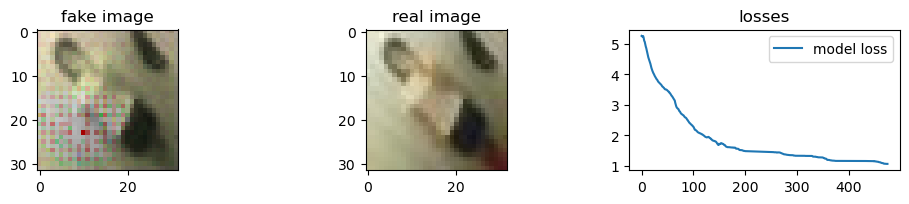

Epoch 476/1000: <=> ------- model loss = 1.0637545585632324, time = 0.0s
Epoch 477/1000: <=> ------- model loss = 1.0634971857070923, time = 0.0s
Epoch 478/1000: <=> ------- model loss = 1.0632588863372803, time = 0.0s
Epoch 479/1000: <=> ------- model loss = 1.062964916229248, time = 0.0s
Epoch 480/1000: <=> ------- model loss = 1.0627143383026123, time = 0.0s

Validation loss = 0


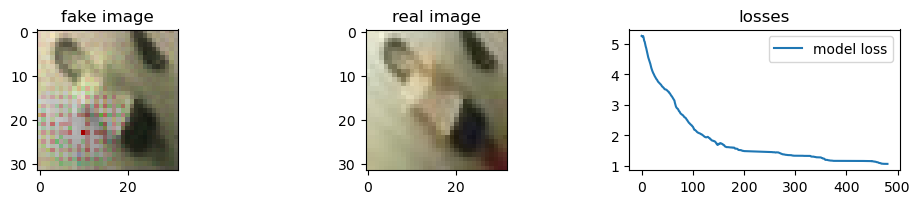

Epoch 481/1000: <=> ------- model loss = 1.0584462881088257, time = 0.0s
Epoch 482/1000: <=> ------- model loss = 1.0580883026123047, time = 0.0s
Epoch 483/1000: <=> ------- model loss = 1.0578913688659668, time = 0.0s
Epoch 484/1000: <=> ------- model loss = 1.060286283493042, time = 0.0s
Epoch 485/1000: <=> ------- model loss = 1.057574987411499, time = 0.0s

Validation loss = 0


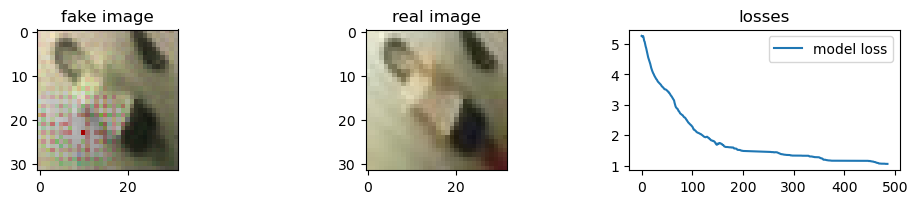

Epoch 486/1000: <=> ------- model loss = 1.0573949813842773, time = 0.0s
Epoch 487/1000: <=> ------- model loss = 1.0516605377197266, time = 0.0s
Epoch 488/1000: <=> ------- model loss = 1.05144202709198, time = 0.0s
Epoch 489/1000: <=> ------- model loss = 1.0476562976837158, time = 0.0s
Epoch 490/1000: <=> ------- model loss = 1.0433557033538818, time = 0.0s

Validation loss = 0


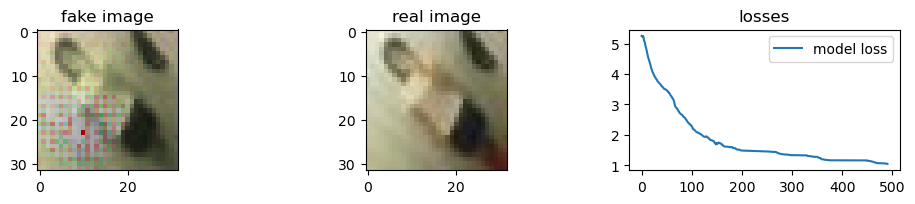

Epoch 491/1000: <=> ------- model loss = 1.043962001800537, time = 0.0s
Epoch 492/1000: <=> ------- model loss = 1.0403125286102295, time = 0.0s
Epoch 493/1000: <=> ------- model loss = 1.0403966903686523, time = 0.0s
Epoch 494/1000: <=> ------- model loss = 1.0353562831878662, time = 0.0s
Epoch 495/1000: <=> ------- model loss = 1.0310084819793701, time = 0.0s

Validation loss = 0


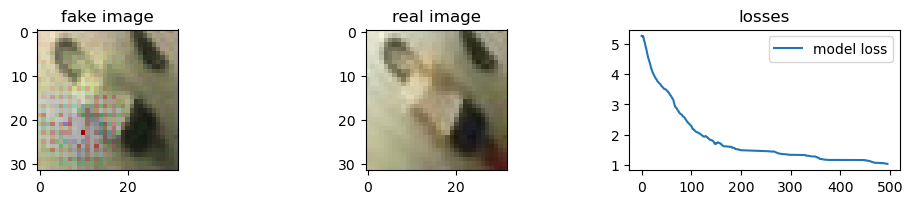

Epoch 496/1000: <=> ------- model loss = 1.0275288820266724, time = 0.0s
Epoch 497/1000: <=> ------- model loss = 1.0270721912384033, time = 0.0s
Epoch 498/1000: <=> ------- model loss = 1.026716947555542, time = 0.0s
Epoch 499/1000: <=> ------- model loss = 1.026548981666565, time = 0.0s
Epoch 500/1000: <=> ------- model loss = 1.0261785984039307, time = 0.0s

Validation loss = 0


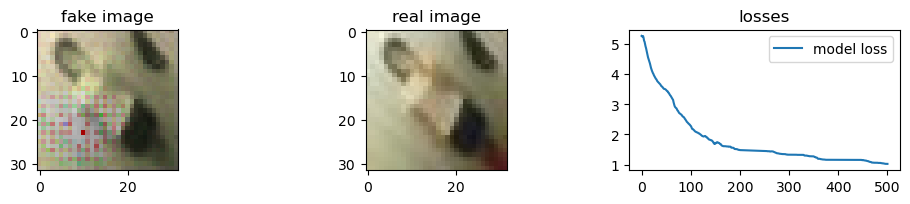

Epoch 501/1000: <=> ------- model loss = 1.025875449180603, time = 0.0s
Epoch 502/1000: <=> ------- model loss = 1.0256178379058838, time = 0.0s
Epoch 503/1000: <=> ------- model loss = 1.025399923324585, time = 0.0s
Epoch 504/1000: <=> ------- model loss = 1.025199294090271, time = 0.0s
Epoch 505/1000: <=> ------- model loss = 1.0201271772384644, time = 0.0s

Validation loss = 0


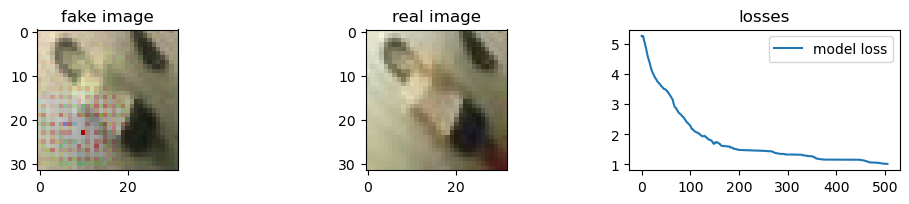

Epoch 506/1000: <=> ------- model loss = 1.0160549879074097, time = 0.0s
Epoch 507/1000: <=> ------- model loss = 1.0159035921096802, time = 0.0s
Epoch 508/1000: <=> ------- model loss = 1.015929937362671, time = 0.0s
Epoch 509/1000: <=> ------- model loss = 1.0159125328063965, time = 0.0s
Epoch 510/1000: <=> ------- model loss = 1.0158525705337524, time = 0.0s

Validation loss = 0


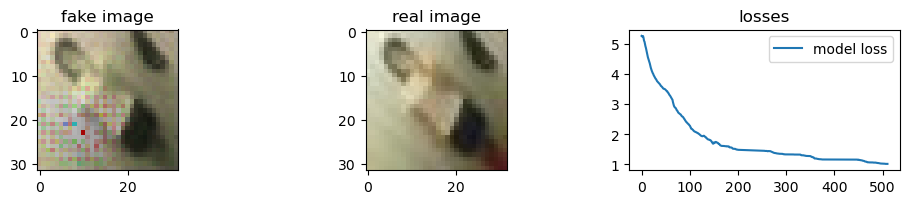

Epoch 511/1000: <=> ------- model loss = 1.0102968215942383, time = 0.0s
Epoch 512/1000: <=> ------- model loss = 1.002835988998413, time = 0.0s
Epoch 513/1000: <=> ------- model loss = 1.0028806924819946, time = 0.0s
Epoch 514/1000: <=> ------- model loss = 1.002884864807129, time = 0.0s
Epoch 515/1000: <=> ------- model loss = 1.0028049945831299, time = 0.0s

Validation loss = 0


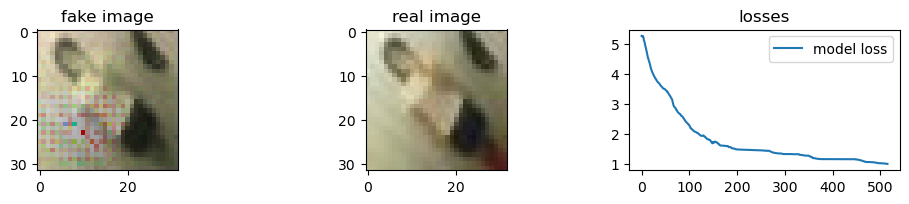

Epoch 516/1000: <=> ------- model loss = 1.0026872158050537, time = 0.0s
Epoch 517/1000: <=> ------- model loss = 0.9999452829360962, time = 0.0s
Epoch 518/1000: <=> ------- model loss = 0.9996424913406372, time = 0.0s
Epoch 519/1000: <=> ------- model loss = 0.9995622038841248, time = 0.0s
Epoch 520/1000: <=> ------- model loss = 0.9993983507156372, time = 0.0s

Validation loss = 0


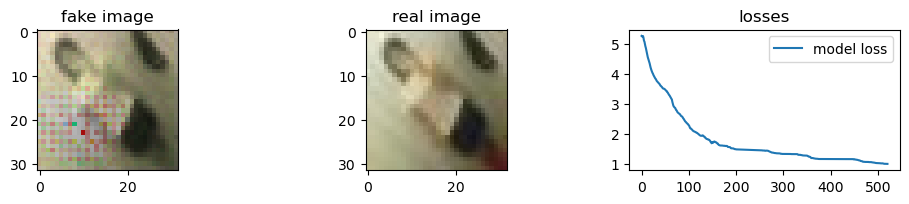

Epoch 521/1000: <=> ------- model loss = 0.9992851614952087, time = 0.0s
Epoch 522/1000: <=> ------- model loss = 0.999143660068512, time = 0.0s
Epoch 523/1000: <=> ------- model loss = 0.9990097284317017, time = 0.0s
Epoch 524/1000: <=> ------- model loss = 0.9988836646080017, time = 0.0s
Epoch 525/1000: <=> ------- model loss = 0.9987848997116089, time = 0.0s

Validation loss = 0


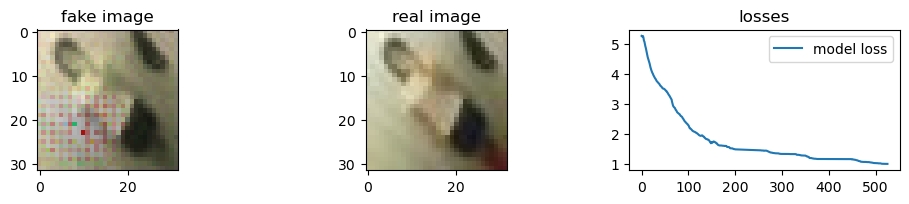

Epoch 526/1000: <=> ------- model loss = 0.9986695051193237, time = 0.0s
Epoch 527/1000: <=> ------- model loss = 0.998576283454895, time = 0.0s
Epoch 528/1000: <=> ------- model loss = 0.9984563589096069, time = 0.0s
Epoch 529/1000: <=> ------- model loss = 0.9983581900596619, time = 0.0s
Epoch 530/1000: <=> ------- model loss = 0.9982687830924988, time = 0.0s

Validation loss = 0


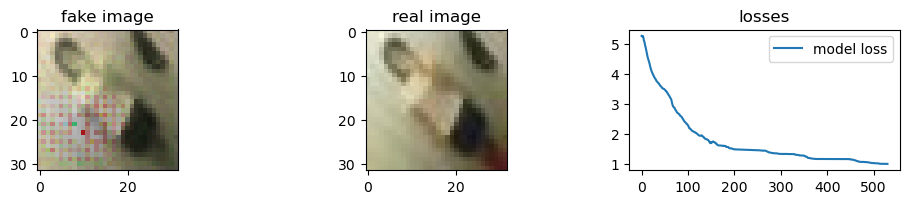

Epoch 531/1000: <=> ------- model loss = 0.9981710314750671, time = 0.0s
Epoch 532/1000: <=> ------- model loss = 0.9981076717376709, time = 0.0s
Epoch 533/1000: <=> ------- model loss = 0.9943756461143494, time = 0.0s
Epoch 534/1000: <=> ------- model loss = 0.9906617999076843, time = 0.0s
Epoch 535/1000: <=> ------- model loss = 0.9905253052711487, time = 0.0s

Validation loss = 0


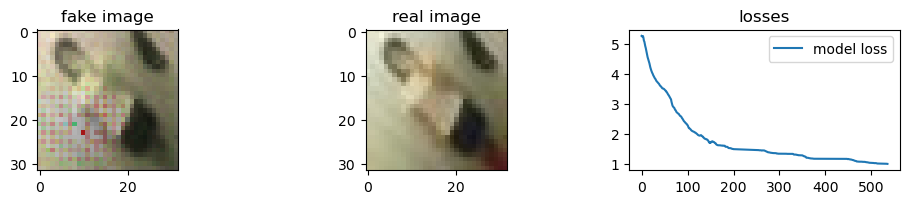

Epoch 536/1000: <=> ------- model loss = 0.9906792044639587, time = 0.0s
Epoch 537/1000: <=> ------- model loss = 0.9871035814285278, time = 0.0s
Epoch 538/1000: <=> ------- model loss = 0.9784965515136719, time = 0.0s
Epoch 539/1000: <=> ------- model loss = 0.9700425267219543, time = 0.0s
Epoch 540/1000: <=> ------- model loss = 0.9698101878166199, time = 0.0s

Validation loss = 0


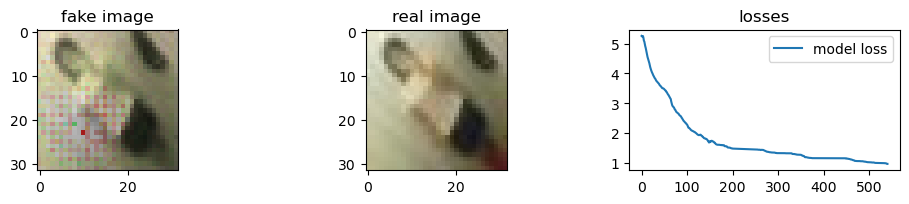

Epoch 541/1000: <=> ------- model loss = 0.9660782814025879, time = 0.0s
Epoch 542/1000: <=> ------- model loss = 0.9659295678138733, time = 0.0s
Epoch 543/1000: <=> ------- model loss = 0.9626226425170898, time = 0.0s
Epoch 544/1000: <=> ------- model loss = 0.9625289440155029, time = 0.0s
Epoch 545/1000: <=> ------- model loss = 0.9623719453811646, time = 0.0s

Validation loss = 0


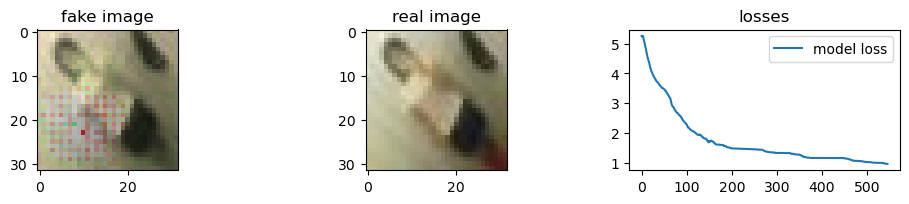

Epoch 546/1000: <=> ------- model loss = 0.9622030854225159, time = 0.0s
Epoch 547/1000: <=> ------- model loss = 0.9580221772193909, time = 0.0s
Epoch 548/1000: <=> ------- model loss = 0.9473053812980652, time = 0.0s
Epoch 549/1000: <=> ------- model loss = 0.9593111276626587, time = 0.0s
Epoch 550/1000: <=> ------- model loss = 1.009148359298706, time = 0.0s

Validation loss = 0


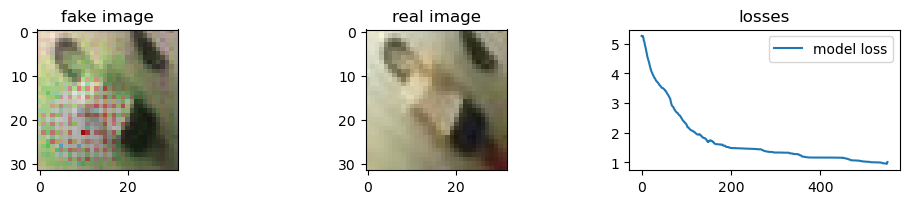

Epoch 551/1000: <=> ------- model loss = 1.013549566268921, time = 0.0s
Epoch 552/1000: <=> ------- model loss = 0.9906244874000549, time = 0.0s
Epoch 553/1000: <=> ------- model loss = 1.005501627922058, time = 0.0s
Epoch 554/1000: <=> ------- model loss = 0.9910716414451599, time = 0.0s
Epoch 555/1000: <=> ------- model loss = 0.9850616455078125, time = 0.0s

Validation loss = 0


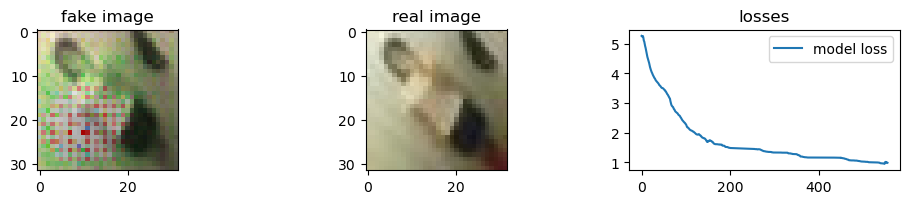

Epoch 556/1000: <=> ------- model loss = 0.9706017971038818, time = 0.0s
Epoch 557/1000: <=> ------- model loss = 0.946800172328949, time = 0.0s
Epoch 558/1000: <=> ------- model loss = 0.9431530237197876, time = 0.0s
Epoch 559/1000: <=> ------- model loss = 0.9409425258636475, time = 0.0s
Epoch 560/1000: <=> ------- model loss = 0.9476754665374756, time = 0.0s

Validation loss = 0


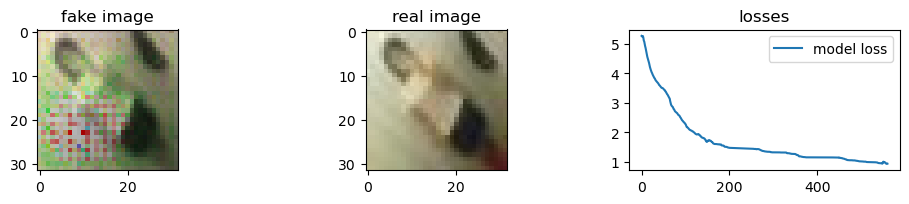

Epoch 561/1000: <=> ------- model loss = 0.9392209053039551, time = 0.0s
Epoch 562/1000: <=> ------- model loss = 0.933424711227417, time = 0.0s
Epoch 563/1000: <=> ------- model loss = 0.9230542778968811, time = 0.0s
Epoch 564/1000: <=> ------- model loss = 0.9132211804389954, time = 0.0s
Epoch 565/1000: <=> ------- model loss = 0.9056437015533447, time = 0.0s

Validation loss = 0


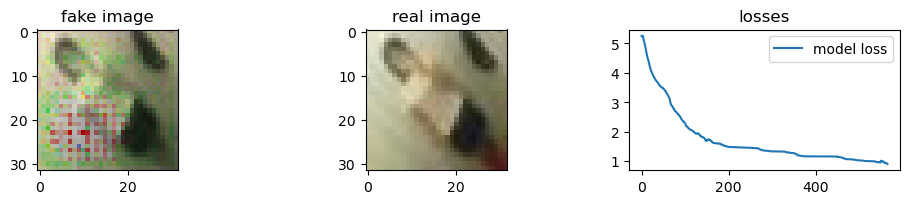

Epoch 566/1000: <=> ------- model loss = 0.8955097794532776, time = 0.0s
Epoch 567/1000: <=> ------- model loss = 0.9002822637557983, time = 0.0s
Epoch 568/1000: <=> ------- model loss = 0.9029970765113831, time = 0.0s
Epoch 569/1000: <=> ------- model loss = 0.8987195491790771, time = 0.0s
Epoch 570/1000: <=> ------- model loss = 0.8852353692054749, time = 0.0s

Validation loss = 0


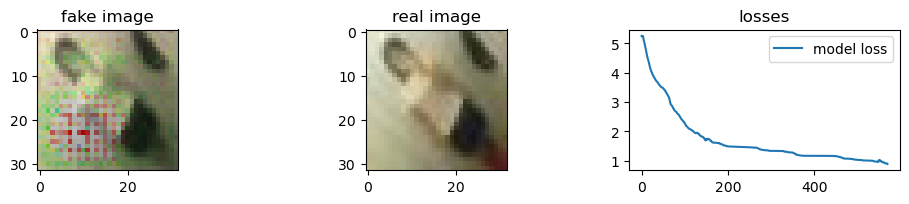

Epoch 571/1000: <=> ------- model loss = 0.8820100426673889, time = 0.0s
Epoch 572/1000: <=> ------- model loss = 0.8787184953689575, time = 0.0s
Epoch 573/1000: <=> ------- model loss = 0.8642638921737671, time = 0.0s
Epoch 574/1000: <=> ------- model loss = 0.8634803295135498, time = 0.0s
Epoch 575/1000: <=> ------- model loss = 0.8540846109390259, time = 0.0s

Validation loss = 0


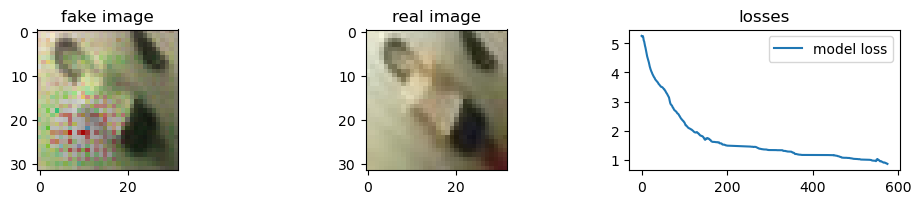

Epoch 576/1000: <=> ------- model loss = 0.8535609245300293, time = 0.0s
Epoch 577/1000: <=> ------- model loss = 0.8489898443222046, time = 0.0s
Epoch 578/1000: <=> ------- model loss = 0.8484735488891602, time = 0.0s
Epoch 579/1000: <=> ------- model loss = 0.8479426503181458, time = 0.0s
Epoch 580/1000: <=> ------- model loss = 0.8436981439590454, time = 0.0s

Validation loss = 0


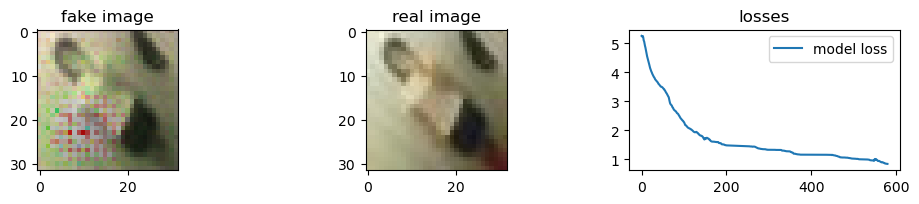

Epoch 581/1000: <=> ------- model loss = 0.8430484533309937, time = 0.0s
Epoch 582/1000: <=> ------- model loss = 0.8387401103973389, time = 0.0s
Epoch 583/1000: <=> ------- model loss = 0.8411679267883301, time = 0.0s
Epoch 584/1000: <=> ------- model loss = 0.8341044187545776, time = 0.0s
Epoch 585/1000: <=> ------- model loss = 0.8302216529846191, time = 0.0s

Validation loss = 0


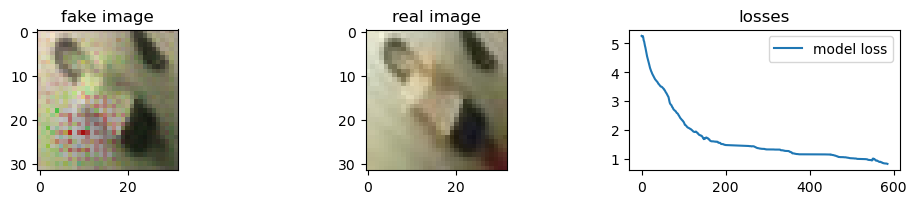

Epoch 586/1000: <=> ------- model loss = 0.8297996520996094, time = 0.0s
Epoch 587/1000: <=> ------- model loss = 0.8293607234954834, time = 0.0s
Epoch 588/1000: <=> ------- model loss = 0.8290740251541138, time = 0.0s
Epoch 589/1000: <=> ------- model loss = 0.8288792371749878, time = 0.0s
Epoch 590/1000: <=> ------- model loss = 0.8286362886428833, time = 0.0s

Validation loss = 0


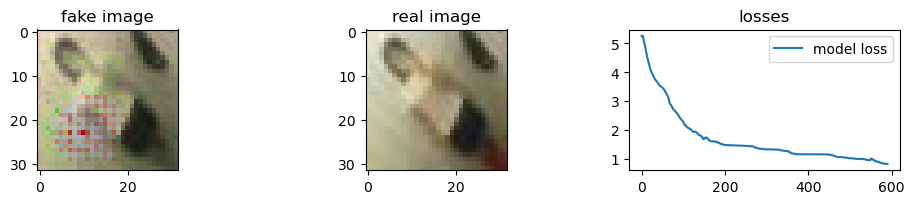

Epoch 591/1000: <=> ------- model loss = 0.8284146785736084, time = 0.0s
Epoch 592/1000: <=> ------- model loss = 0.8282362222671509, time = 0.0s
Epoch 593/1000: <=> ------- model loss = 0.8280855417251587, time = 0.0s
Epoch 594/1000: <=> ------- model loss = 0.8279414772987366, time = 0.0s
Epoch 595/1000: <=> ------- model loss = 0.8277945518493652, time = 0.0s

Validation loss = 0


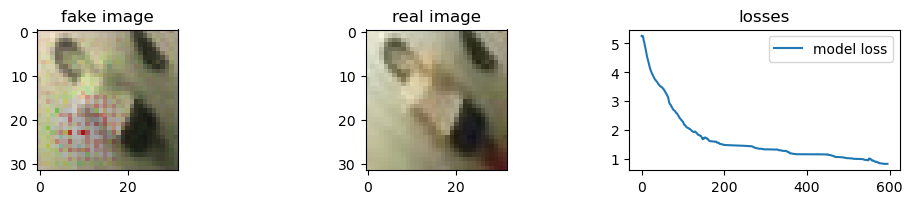

Epoch 596/1000: <=> ------- model loss = 0.8276588916778564, time = 0.0s
Epoch 597/1000: <=> ------- model loss = 0.827527642250061, time = 0.0s
Epoch 598/1000: <=> ------- model loss = 0.827400267124176, time = 0.0s
Epoch 599/1000: <=> ------- model loss = 0.8272919654846191, time = 0.0s
Epoch 600/1000: <=> ------- model loss = 0.8271760940551758, time = 0.0s

Validation loss = 0


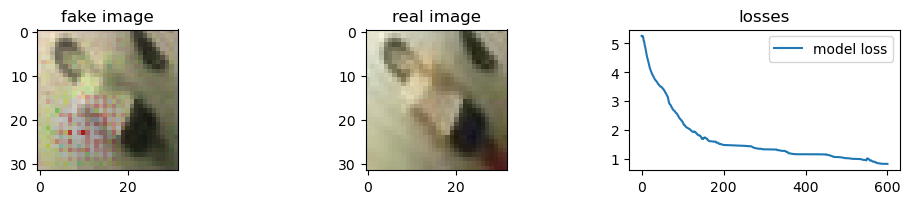

Epoch 601/1000: <=> ------- model loss = 0.8270548582077026, time = 0.0s
Epoch 602/1000: <=> ------- model loss = 0.8269348740577698, time = 0.0s
Epoch 603/1000: <=> ------- model loss = 0.8268150091171265, time = 0.0s
Epoch 604/1000: <=> ------- model loss = 0.8221272826194763, time = 0.0s
Epoch 605/1000: <=> ------- model loss = 0.8218826055526733, time = 0.0s

Validation loss = 0


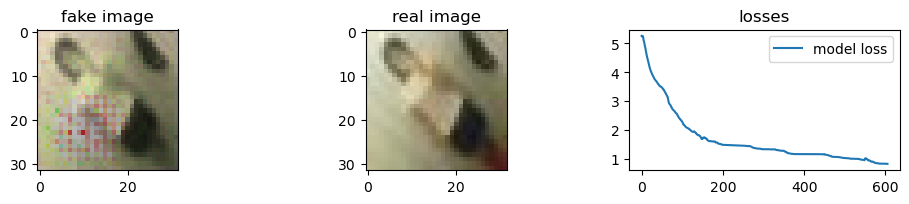

Epoch 606/1000: <=> ------- model loss = 0.8178093433380127, time = 0.0s
Epoch 607/1000: <=> ------- model loss = 0.8176648616790771, time = 0.0s
Epoch 608/1000: <=> ------- model loss = 0.8175517320632935, time = 0.0s
Epoch 609/1000: <=> ------- model loss = 0.8174592852592468, time = 0.0s
Epoch 610/1000: <=> ------- model loss = 0.8173704743385315, time = 0.0s

Validation loss = 0


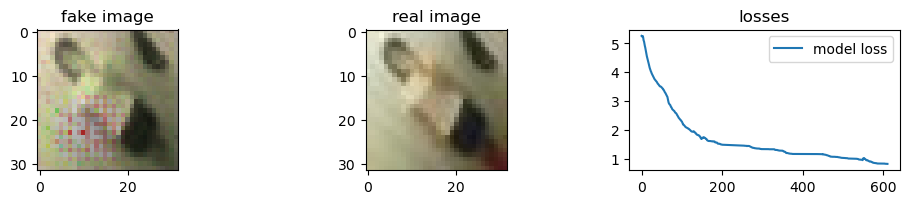

Epoch 611/1000: <=> ------- model loss = 0.817269504070282, time = 0.0s
Epoch 612/1000: <=> ------- model loss = 0.8171753883361816, time = 0.0s
Epoch 613/1000: <=> ------- model loss = 0.8170757293701172, time = 0.0s
Epoch 614/1000: <=> ------- model loss = 0.8169794082641602, time = 0.0s
Epoch 615/1000: <=> ------- model loss = 0.8168920874595642, time = 0.0s

Validation loss = 0


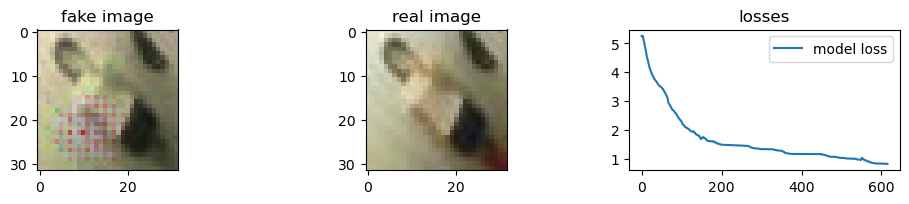

Epoch 616/1000: <=> ------- model loss = 0.81680828332901, time = 0.0s
Epoch 617/1000: <=> ------- model loss = 0.8167259693145752, time = 0.0s
Epoch 618/1000: <=> ------- model loss = 0.8166459798812866, time = 0.0s
Epoch 619/1000: <=> ------- model loss = 0.8165642023086548, time = 0.0s
Epoch 620/1000: <=> ------- model loss = 0.8164991140365601, time = 0.0s

Validation loss = 0


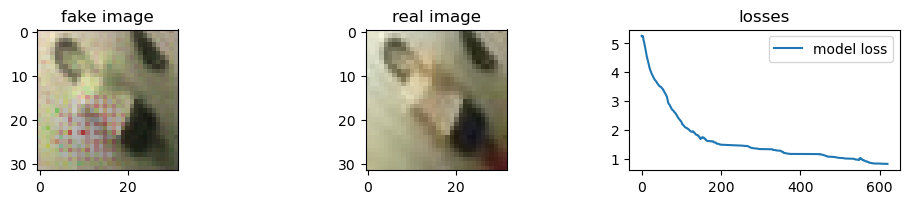

Epoch 621/1000: <=> ------- model loss = 0.8164332509040833, time = 0.0s
Epoch 622/1000: <=> ------- model loss = 0.8163505792617798, time = 0.0s
Epoch 623/1000: <=> ------- model loss = 0.8162869215011597, time = 0.0s
Epoch 624/1000: <=> ------- model loss = 0.8162177801132202, time = 0.0s
Epoch 625/1000: <=> ------- model loss = 0.8161580562591553, time = 0.0s

Validation loss = 0


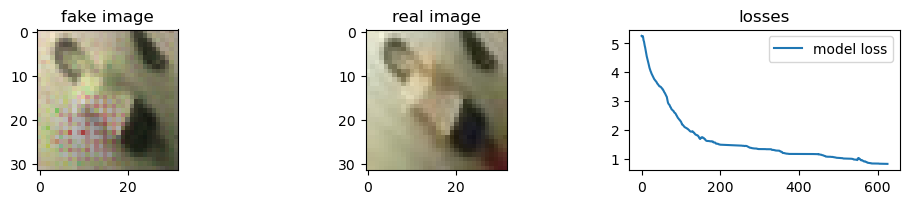

Epoch 626/1000: <=> ------- model loss = 0.8160929679870605, time = 0.0s
Epoch 627/1000: <=> ------- model loss = 0.8160246014595032, time = 0.0s
Epoch 628/1000: <=> ------- model loss = 0.8159629702568054, time = 0.0s
Epoch 629/1000: <=> ------- model loss = 0.8159167766571045, time = 0.0s
Epoch 630/1000: <=> ------- model loss = 0.8158754706382751, time = 0.0s

Validation loss = 0


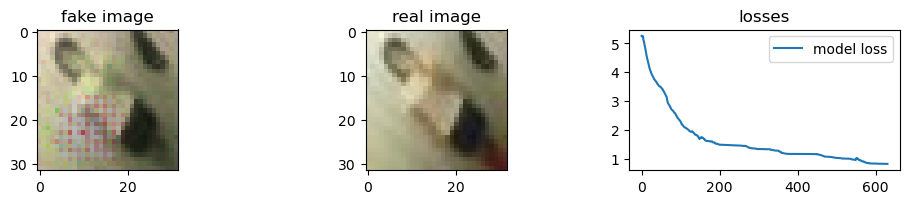

Epoch 631/1000: <=> ------- model loss = 0.815858781337738, time = 0.0s
Epoch 632/1000: <=> ------- model loss = 0.8157765865325928, time = 0.0s
Epoch 633/1000: <=> ------- model loss = 0.8157397508621216, time = 0.0s
Epoch 634/1000: <=> ------- model loss = 0.8157011270523071, time = 0.0s
Epoch 635/1000: <=> ------- model loss = 0.8157270550727844, time = 0.0s

Validation loss = 0


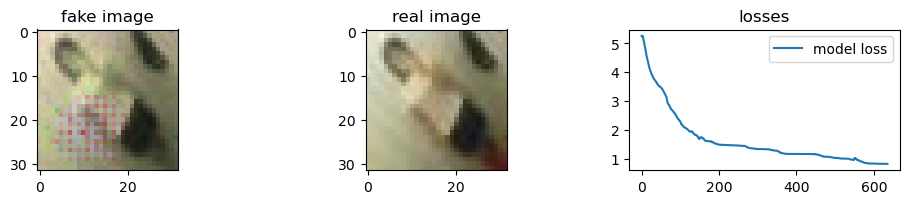

Epoch 636/1000: <=> ------- model loss = 0.8156538009643555, time = 0.0s
Epoch 637/1000: <=> ------- model loss = 0.8157104253768921, time = 0.0s
Epoch 638/1000: <=> ------- model loss = 0.8155871629714966, time = 0.0s
Epoch 639/1000: <=> ------- model loss = 0.8155705332756042, time = 0.0s
Epoch 640/1000: <=> ------- model loss = 0.8155568838119507, time = 0.0s

Validation loss = 0


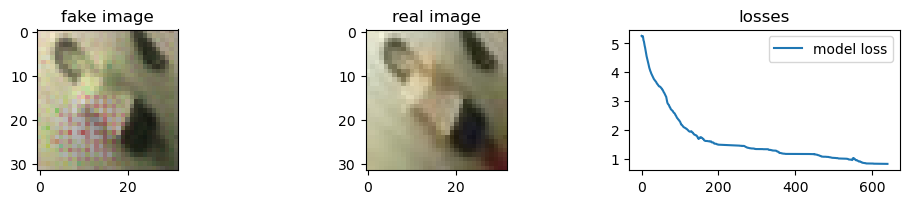

Epoch 641/1000: <=> ------- model loss = 0.8155032396316528, time = 0.0s
Epoch 642/1000: <=> ------- model loss = 0.8154361248016357, time = 0.0s
Epoch 643/1000: <=> ------- model loss = 0.815402090549469, time = 0.0s
Epoch 644/1000: <=> ------- model loss = 0.815292239189148, time = 0.0s
Epoch 645/1000: <=> ------- model loss = 0.8152161836624146, time = 0.0s

Validation loss = 0


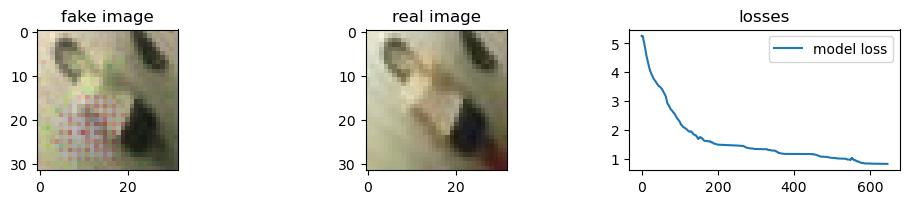

Epoch 646/1000: <=> ------- model loss = 0.8151610493659973, time = 0.0s
Epoch 647/1000: <=> ------- model loss = 0.8150806427001953, time = 0.0s
Epoch 648/1000: <=> ------- model loss = 0.8150334358215332, time = 0.0s
Epoch 649/1000: <=> ------- model loss = 0.81500643491745, time = 0.0s
Epoch 650/1000: <=> ------- model loss = 0.814949631690979, time = 0.0s

Validation loss = 0


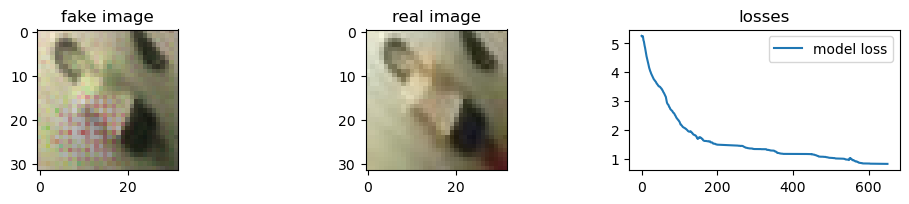

Epoch 651/1000: <=> ------- model loss = 0.8148944973945618, time = 0.0s
Epoch 652/1000: <=> ------- model loss = 0.8148691058158875, time = 0.0s
Epoch 653/1000: <=> ------- model loss = 0.814793586730957, time = 0.0s
Epoch 654/1000: <=> ------- model loss = 0.8147735595703125, time = 0.0s
Epoch 655/1000: <=> ------- model loss = 0.8147244453430176, time = 0.0s

Validation loss = 0


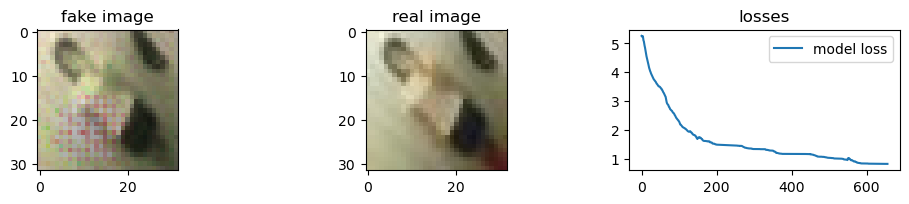

Epoch 656/1000: <=> ------- model loss = 0.8098325133323669, time = 0.0s
Epoch 657/1000: <=> ------- model loss = 0.810356616973877, time = 0.0s
Epoch 658/1000: <=> ------- model loss = 0.8328538537025452, time = 0.0s
Epoch 659/1000: <=> ------- model loss = 0.8339788317680359, time = 0.0s
Epoch 660/1000: <=> ------- model loss = 1.517831802368164, time = 0.0s

Validation loss = 0


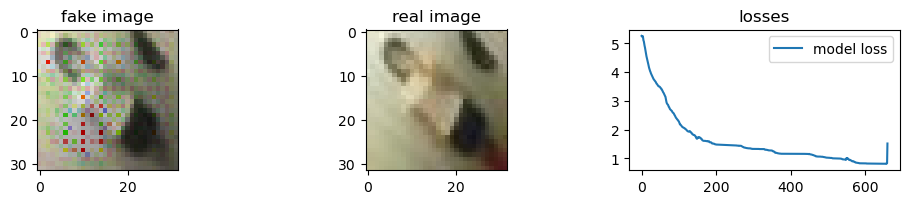

Epoch 661/1000: <=> ------- model loss = 1.8034803867340088, time = 0.0s
Epoch 662/1000: <=> ------- model loss = 1.9469478130340576, time = 0.0s
Epoch 663/1000: <=> ------- model loss = 1.9233673810958862, time = 0.0s
Epoch 664/1000: <=> ------- model loss = 1.743992567062378, time = 0.0s
Epoch 665/1000: <=> ------- model loss = 1.6617108583450317, time = 0.0s

Validation loss = 0


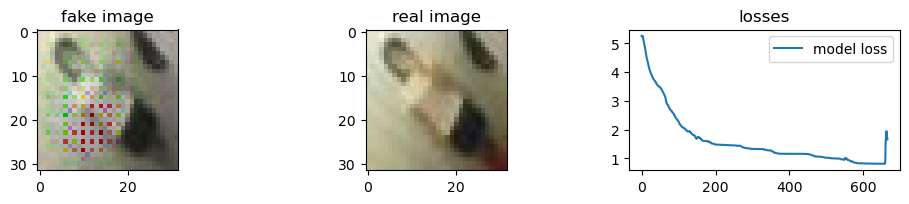

Epoch 666/1000: <=> ------- model loss = 1.5887271165847778, time = 0.0s
Epoch 667/1000: <=> ------- model loss = 1.5433505773544312, time = 0.0s
Epoch 668/1000: <=> ------- model loss = 1.4823248386383057, time = 0.0s
Epoch 669/1000: <=> ------- model loss = 1.4393558502197266, time = 0.0s
Epoch 670/1000: <=> ------- model loss = 1.4097754955291748, time = 0.0s

Validation loss = 0


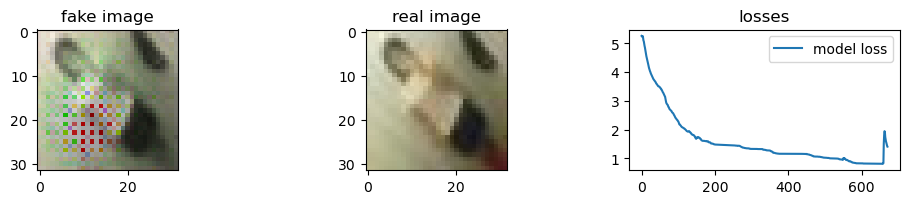

Epoch 671/1000: <=> ------- model loss = 1.3756130933761597, time = 0.0s
Epoch 672/1000: <=> ------- model loss = 1.3405303955078125, time = 0.0s
Epoch 673/1000: <=> ------- model loss = 1.3239538669586182, time = 0.0s
Epoch 674/1000: <=> ------- model loss = 1.3078696727752686, time = 0.0s
Epoch 675/1000: <=> ------- model loss = 1.2865220308303833, time = 0.0s

Validation loss = 0


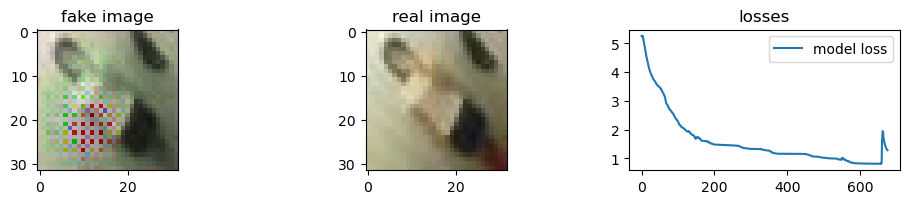

Epoch 676/1000: <=> ------- model loss = 1.255867838859558, time = 0.0s
Epoch 677/1000: <=> ------- model loss = 1.2060763835906982, time = 0.0s
Epoch 678/1000: <=> ------- model loss = 1.1900122165679932, time = 0.0s
Epoch 679/1000: <=> ------- model loss = 1.1740243434906006, time = 0.0s
Epoch 680/1000: <=> ------- model loss = 1.1493961811065674, time = 0.0s

Validation loss = 0


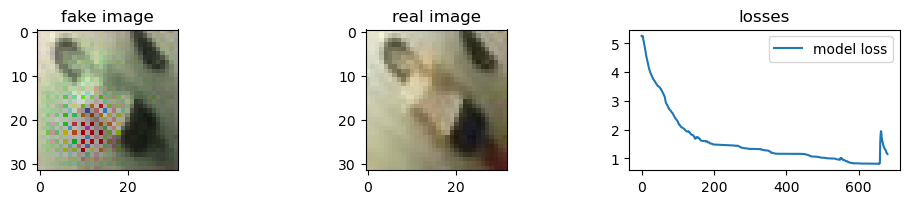

Epoch 681/1000: <=> ------- model loss = 1.120957612991333, time = 0.0s
Epoch 682/1000: <=> ------- model loss = 1.113156795501709, time = 0.0s
Epoch 683/1000: <=> ------- model loss = 1.1077244281768799, time = 0.0s
Epoch 684/1000: <=> ------- model loss = 1.0978801250457764, time = 0.0s
Epoch 685/1000: <=> ------- model loss = 1.0877817869186401, time = 0.0s

Validation loss = 0


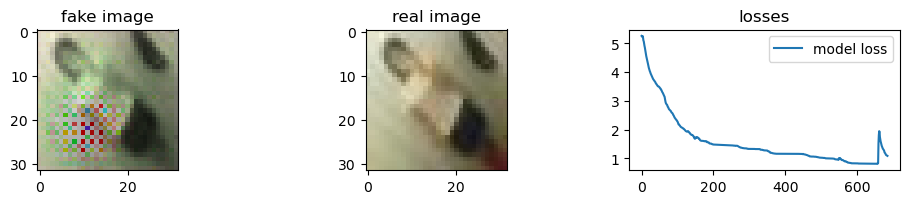

Epoch 686/1000: <=> ------- model loss = 1.0743458271026611, time = 0.0s
Epoch 687/1000: <=> ------- model loss = 1.0712878704071045, time = 0.0s
Epoch 688/1000: <=> ------- model loss = 1.063622236251831, time = 0.0s
Epoch 689/1000: <=> ------- model loss = 1.0056551694869995, time = 0.0s
Epoch 690/1000: <=> ------- model loss = 0.993370771408081, time = 0.0s

Validation loss = 0


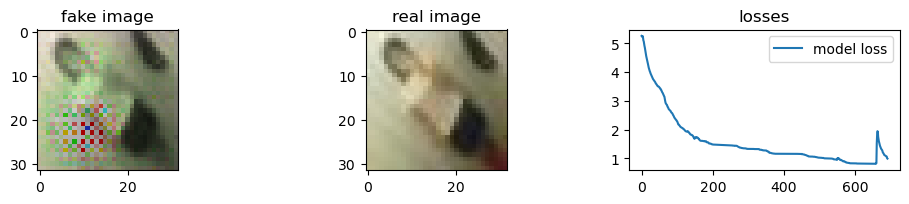

Epoch 691/1000: <=> ------- model loss = 0.9706211686134338, time = 0.0s
Epoch 692/1000: <=> ------- model loss = 0.9306284189224243, time = 0.0s
Epoch 693/1000: <=> ------- model loss = 0.8950634002685547, time = 0.0s
Epoch 694/1000: <=> ------- model loss = 0.85835200548172, time = 0.0s
Epoch 695/1000: <=> ------- model loss = 0.8083471059799194, time = 0.0s

Validation loss = 0


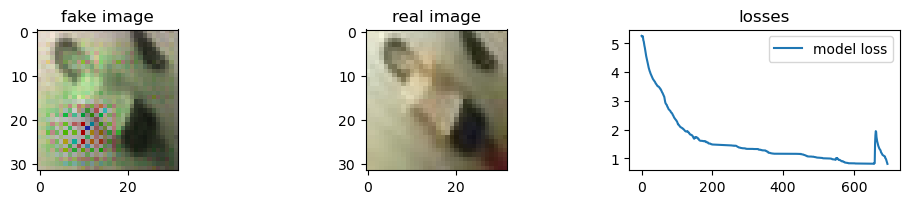

Epoch 696/1000: <=> ------- model loss = 0.7881230115890503, time = 0.0s
Epoch 697/1000: <=> ------- model loss = 0.758354663848877, time = 0.0s
Epoch 698/1000: <=> ------- model loss = 0.7508920431137085, time = 0.0s
Epoch 699/1000: <=> ------- model loss = 0.7504305839538574, time = 0.0s
Epoch 700/1000: <=> ------- model loss = 0.7463512420654297, time = 0.0s

Validation loss = 0


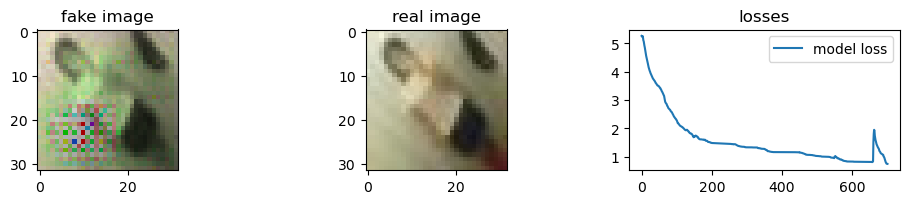

Epoch 701/1000: <=> ------- model loss = 0.7421956062316895, time = 0.0s
Epoch 702/1000: <=> ------- model loss = 0.7328749895095825, time = 0.0s
Epoch 703/1000: <=> ------- model loss = 0.7257281541824341, time = 0.0s
Epoch 704/1000: <=> ------- model loss = 0.7247557044029236, time = 0.0s
Epoch 705/1000: <=> ------- model loss = 0.7174627780914307, time = 0.0s

Validation loss = 0


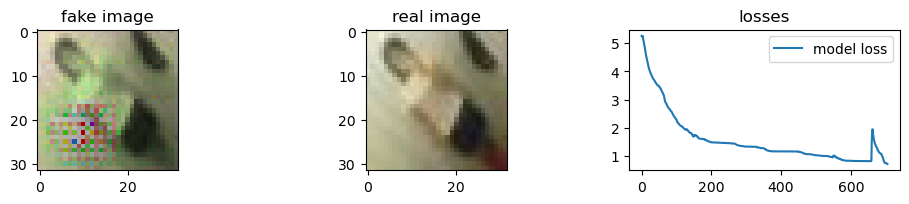

Epoch 706/1000: <=> ------- model loss = 0.7100579738616943, time = 0.0s
Epoch 707/1000: <=> ------- model loss = 0.7071342468261719, time = 0.0s
Epoch 708/1000: <=> ------- model loss = 0.7050906419754028, time = 0.0s
Epoch 709/1000: <=> ------- model loss = 0.7041676044464111, time = 0.0s
Epoch 710/1000: <=> ------- model loss = 0.7006603479385376, time = 0.0s

Validation loss = 0


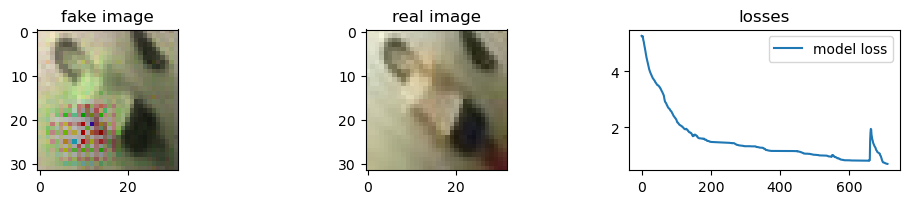

Epoch 711/1000: <=> ------- model loss = 0.6937805414199829, time = 0.0s
Epoch 712/1000: <=> ------- model loss = 0.6921557188034058, time = 0.0s
Epoch 713/1000: <=> ------- model loss = 0.6941467523574829, time = 0.0s
Epoch 714/1000: <=> ------- model loss = 0.696169376373291, time = 0.0s
Epoch 715/1000: <=> ------- model loss = 0.6957006454467773, time = 0.0s

Validation loss = 0


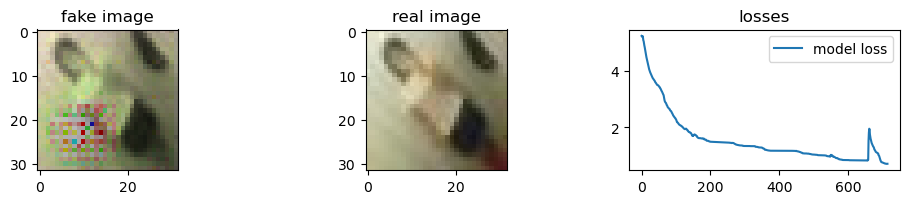

Epoch 716/1000: <=> ------- model loss = 0.6980293989181519, time = 0.0s
Epoch 717/1000: <=> ------- model loss = 0.6987833380699158, time = 0.0s
Epoch 718/1000: <=> ------- model loss = 0.7031543850898743, time = 0.0s
Epoch 719/1000: <=> ------- model loss = 0.7028206586837769, time = 0.0s
Epoch 720/1000: <=> ------- model loss = 0.6896159648895264, time = 0.0s

Validation loss = 0


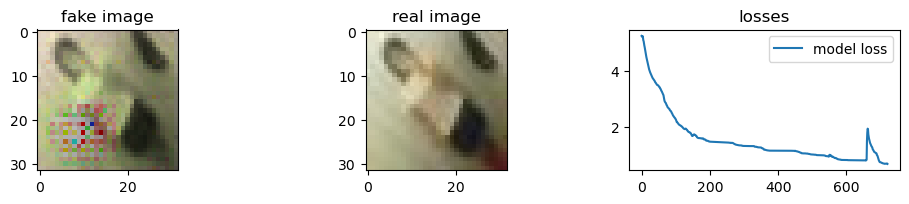

Epoch 721/1000: <=> ------- model loss = 0.6890262365341187, time = 0.0s
Epoch 722/1000: <=> ------- model loss = 0.6886658668518066, time = 0.0s
Epoch 723/1000: <=> ------- model loss = 0.6918312907218933, time = 0.0s
Epoch 724/1000: <=> ------- model loss = 0.6915432214736938, time = 0.0s
Epoch 725/1000: <=> ------- model loss = 0.6912990808486938, time = 0.0s

Validation loss = 0


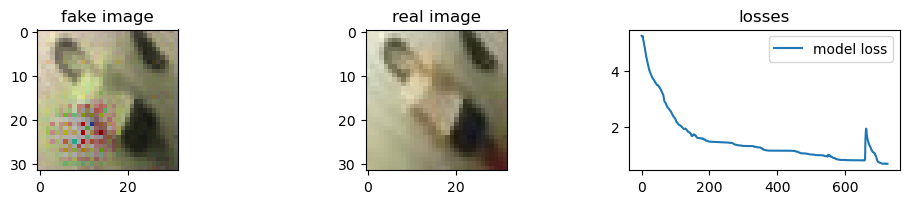

Epoch 726/1000: <=> ------- model loss = 0.691167414188385, time = 0.0s
Epoch 727/1000: <=> ------- model loss = 0.6908670663833618, time = 0.0s
Epoch 728/1000: <=> ------- model loss = 0.6906794309616089, time = 0.0s
Epoch 729/1000: <=> ------- model loss = 0.6905053853988647, time = 0.0s
Epoch 730/1000: <=> ------- model loss = 0.6903350353240967, time = 0.0s

Validation loss = 0


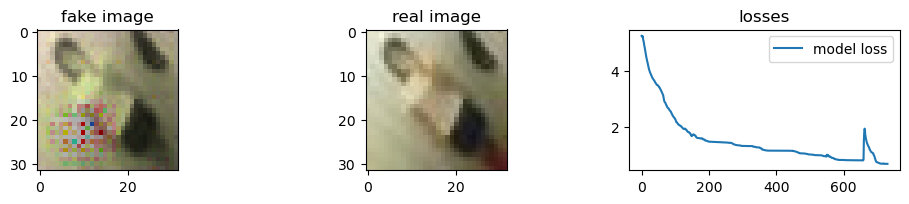

Epoch 731/1000: <=> ------- model loss = 0.6901705265045166, time = 0.0s
Epoch 732/1000: <=> ------- model loss = 0.6900126338005066, time = 0.0s
Epoch 733/1000: <=> ------- model loss = 0.6898558735847473, time = 0.0s
Epoch 734/1000: <=> ------- model loss = 0.6897022724151611, time = 0.0s
Epoch 735/1000: <=> ------- model loss = 0.6895509958267212, time = 0.0s

Validation loss = 0


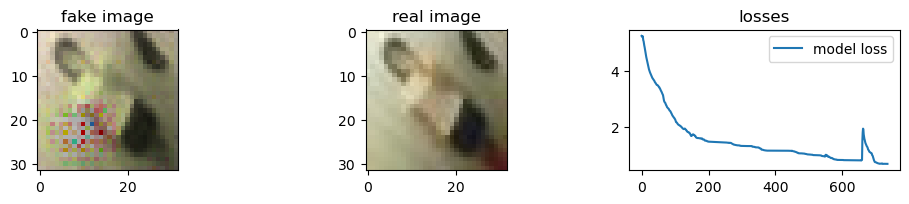

Epoch 736/1000: <=> ------- model loss = 0.6894029974937439, time = 0.0s
Epoch 737/1000: <=> ------- model loss = 0.6892534494400024, time = 0.0s
Epoch 738/1000: <=> ------- model loss = 0.6891043782234192, time = 0.0s
Epoch 739/1000: <=> ------- model loss = 0.6889584064483643, time = 0.0s
Epoch 740/1000: <=> ------- model loss = 0.6888167858123779, time = 0.0s

Validation loss = 0


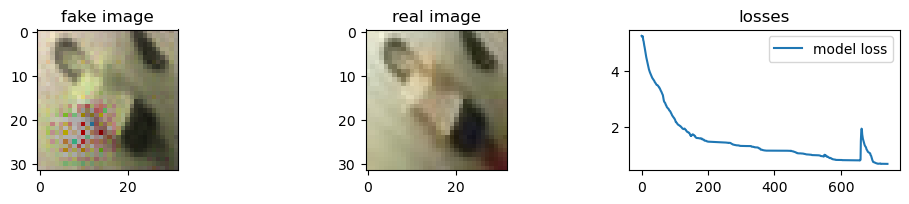

Epoch 741/1000: <=> ------- model loss = 0.6886792182922363, time = 0.0s
Epoch 742/1000: <=> ------- model loss = 0.6847885251045227, time = 0.0s
Epoch 743/1000: <=> ------- model loss = 0.6845515966415405, time = 0.0s
Epoch 744/1000: <=> ------- model loss = 0.6844156980514526, time = 0.0s
Epoch 745/1000: <=> ------- model loss = 0.6842857003211975, time = 0.0s

Validation loss = 0


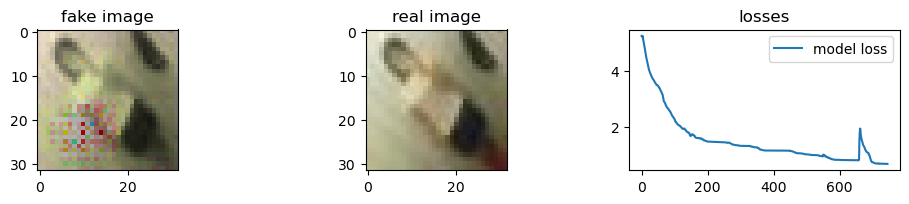

Epoch 746/1000: <=> ------- model loss = 0.6841597557067871, time = 0.0s
Epoch 747/1000: <=> ------- model loss = 0.6840411424636841, time = 0.0s
Epoch 748/1000: <=> ------- model loss = 0.6839255094528198, time = 0.0s
Epoch 749/1000: <=> ------- model loss = 0.6800487041473389, time = 0.0s
Epoch 750/1000: <=> ------- model loss = 0.6798474788665771, time = 0.0s

Validation loss = 0


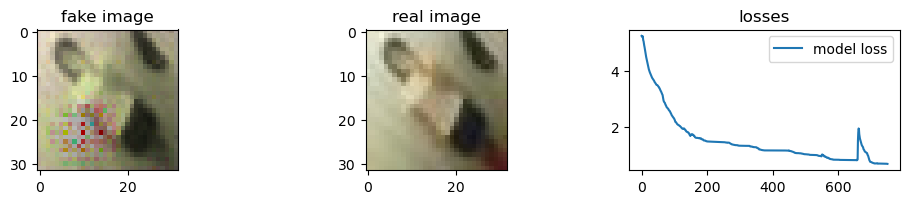

Epoch 751/1000: <=> ------- model loss = 0.6797207593917847, time = 0.0s
Epoch 752/1000: <=> ------- model loss = 0.6796061396598816, time = 0.0s
Epoch 753/1000: <=> ------- model loss = 0.6794968843460083, time = 0.0s
Epoch 754/1000: <=> ------- model loss = 0.6756645441055298, time = 0.0s
Epoch 755/1000: <=> ------- model loss = 0.6754518747329712, time = 0.0s

Validation loss = 0


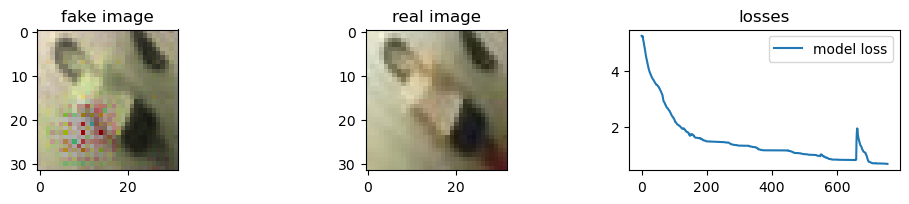

Epoch 756/1000: <=> ------- model loss = 0.6753430366516113, time = 0.0s
Epoch 757/1000: <=> ------- model loss = 0.6752289533615112, time = 0.0s
Epoch 758/1000: <=> ------- model loss = 0.6751302480697632, time = 0.0s
Epoch 759/1000: <=> ------- model loss = 0.6750380992889404, time = 0.0s
Epoch 760/1000: <=> ------- model loss = 0.6737720966339111, time = 0.0s

Validation loss = 0


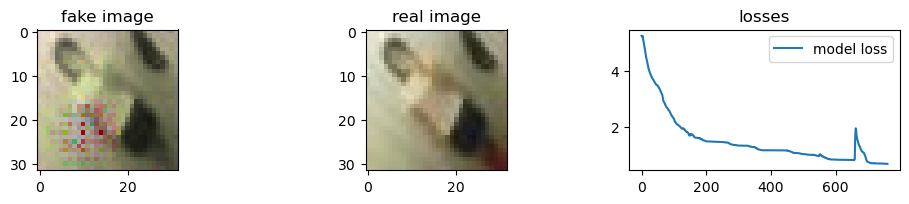

Epoch 761/1000: <=> ------- model loss = 0.6736763715744019, time = 0.0s
Epoch 762/1000: <=> ------- model loss = 0.6735938191413879, time = 0.0s
Epoch 763/1000: <=> ------- model loss = 0.6735122203826904, time = 0.0s
Epoch 764/1000: <=> ------- model loss = 0.673429012298584, time = 0.0s
Epoch 765/1000: <=> ------- model loss = 0.673344075679779, time = 0.0s

Validation loss = 0


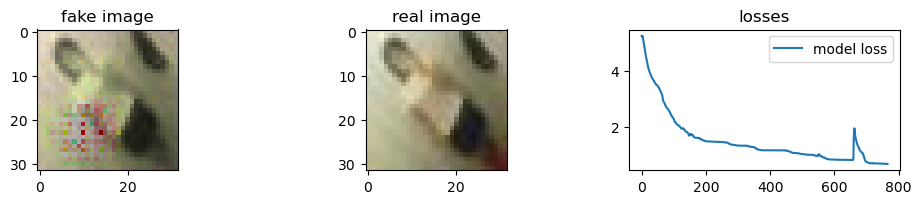

Epoch 766/1000: <=> ------- model loss = 0.673262357711792, time = 0.0s
Epoch 767/1000: <=> ------- model loss = 0.6731858253479004, time = 0.0s
Epoch 768/1000: <=> ------- model loss = 0.6687206029891968, time = 0.0s
Epoch 769/1000: <=> ------- model loss = 0.6570395231246948, time = 0.0s
Epoch 770/1000: <=> ------- model loss = 0.6519639492034912, time = 0.0s

Validation loss = 0


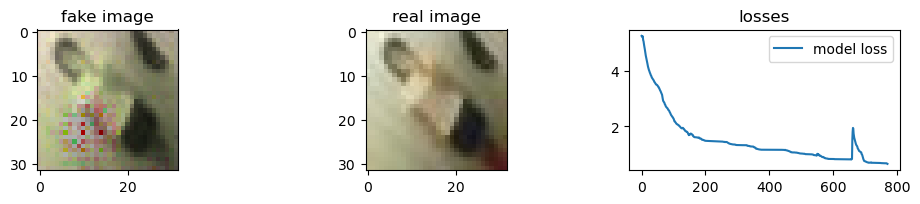

Epoch 771/1000: <=> ------- model loss = 0.6462771892547607, time = 0.0s
Epoch 772/1000: <=> ------- model loss = 0.6425009965896606, time = 0.0s
Epoch 773/1000: <=> ------- model loss = 0.6419594883918762, time = 0.0s
Epoch 774/1000: <=> ------- model loss = 0.6379261612892151, time = 0.0s
Epoch 775/1000: <=> ------- model loss = 0.633791983127594, time = 0.0s

Validation loss = 0


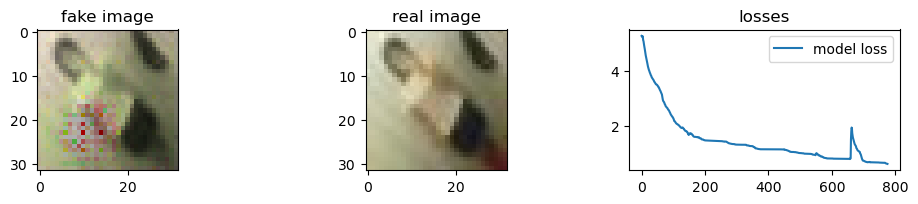

Epoch 776/1000: <=> ------- model loss = 0.6324694752693176, time = 0.0s
Epoch 777/1000: <=> ------- model loss = 0.6323258876800537, time = 0.0s
Epoch 778/1000: <=> ------- model loss = 0.6321834325790405, time = 0.0s
Epoch 779/1000: <=> ------- model loss = 0.6320781707763672, time = 0.0s
Epoch 780/1000: <=> ------- model loss = 0.631969153881073, time = 0.0s

Validation loss = 0


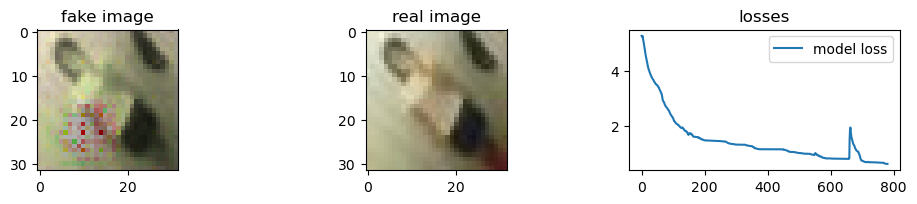

Epoch 781/1000: <=> ------- model loss = 0.6318491697311401, time = 0.0s
Epoch 782/1000: <=> ------- model loss = 0.6317349076271057, time = 0.0s
Epoch 783/1000: <=> ------- model loss = 0.6316277980804443, time = 0.0s
Epoch 784/1000: <=> ------- model loss = 0.6315271854400635, time = 0.0s
Epoch 785/1000: <=> ------- model loss = 0.6314318180084229, time = 0.0s

Validation loss = 0


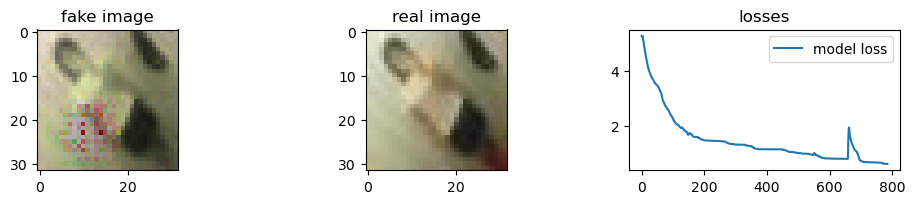

Epoch 786/1000: <=> ------- model loss = 0.6313385963439941, time = 0.0s
Epoch 787/1000: <=> ------- model loss = 0.6312599778175354, time = 0.0s
Epoch 788/1000: <=> ------- model loss = 0.6312028169631958, time = 0.0s
Epoch 789/1000: <=> ------- model loss = 0.6311335563659668, time = 0.0s
Epoch 790/1000: <=> ------- model loss = 0.6310607194900513, time = 0.0s

Validation loss = 0


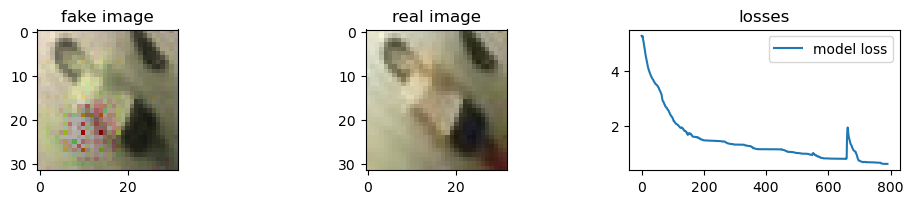

Epoch 791/1000: <=> ------- model loss = 0.630990743637085, time = 0.0s
Epoch 792/1000: <=> ------- model loss = 0.6309256553649902, time = 0.0s
Epoch 793/1000: <=> ------- model loss = 0.6308630704879761, time = 0.0s
Epoch 794/1000: <=> ------- model loss = 0.6308040618896484, time = 0.0s
Epoch 795/1000: <=> ------- model loss = 0.6307436227798462, time = 0.0s

Validation loss = 0


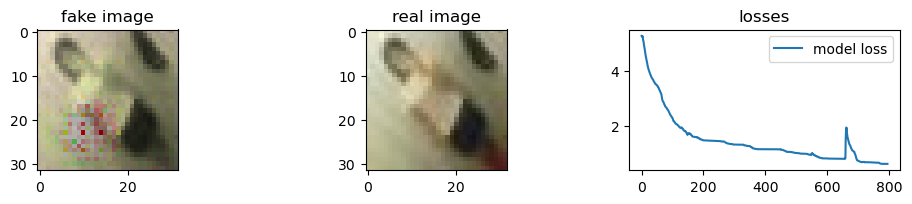

Epoch 796/1000: <=> ------- model loss = 0.6306846141815186, time = 0.0s
Epoch 797/1000: <=> ------- model loss = 0.6306292414665222, time = 0.0s
Epoch 798/1000: <=> ------- model loss = 0.6305721998214722, time = 0.0s
Epoch 799/1000: <=> ------- model loss = 0.630517840385437, time = 0.0s
Epoch 800/1000: <=> ------- model loss = 0.630467414855957, time = 0.0s

Validation loss = 0


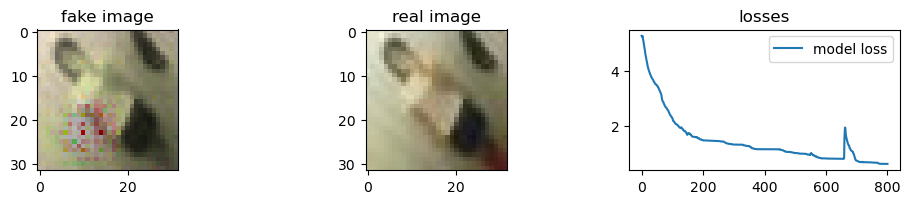

Epoch 801/1000: <=> ------- model loss = 0.6304126977920532, time = 0.0s
Epoch 802/1000: <=> ------- model loss = 0.6303545832633972, time = 0.0s
Epoch 803/1000: <=> ------- model loss = 0.6302995681762695, time = 0.0s
Epoch 804/1000: <=> ------- model loss = 0.6302454471588135, time = 0.0s
Epoch 805/1000: <=> ------- model loss = 0.6301937103271484, time = 0.0s

Validation loss = 0


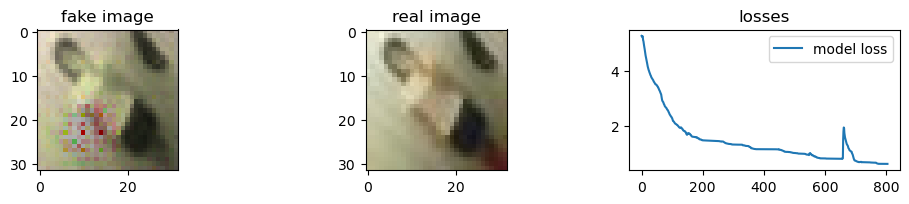

Epoch 806/1000: <=> ------- model loss = 0.6301422119140625, time = 0.0s
Epoch 807/1000: <=> ------- model loss = 0.6300907135009766, time = 0.0s
Epoch 808/1000: <=> ------- model loss = 0.6300395727157593, time = 0.0s
Epoch 809/1000: <=> ------- model loss = 0.6299899816513062, time = 0.0s
Epoch 810/1000: <=> ------- model loss = 0.6299394369125366, time = 0.0s

Validation loss = 0


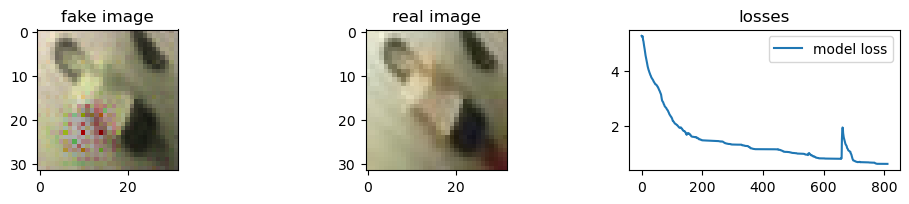

Epoch 811/1000: <=> ------- model loss = 0.6298890709877014, time = 0.0s
Epoch 812/1000: <=> ------- model loss = 0.6298363208770752, time = 0.0s
Epoch 813/1000: <=> ------- model loss = 0.6297868490219116, time = 0.0s
Epoch 814/1000: <=> ------- model loss = 0.6297358870506287, time = 0.0s
Epoch 815/1000: <=> ------- model loss = 0.6296835541725159, time = 0.0s

Validation loss = 0


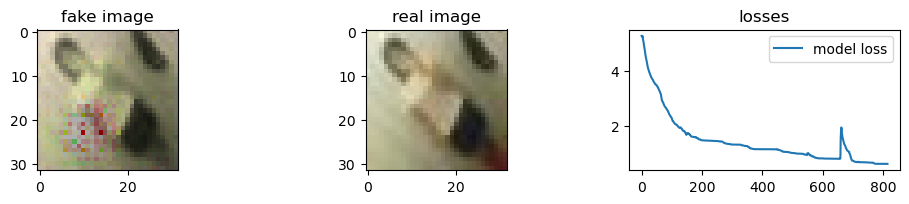

Epoch 816/1000: <=> ------- model loss = 0.6296311616897583, time = 0.0s
Epoch 817/1000: <=> ------- model loss = 0.6295781135559082, time = 0.0s
Epoch 818/1000: <=> ------- model loss = 0.6295274496078491, time = 0.0s
Epoch 819/1000: <=> ------- model loss = 0.6294760704040527, time = 0.0s
Epoch 820/1000: <=> ------- model loss = 0.6294237375259399, time = 0.0s

Validation loss = 0


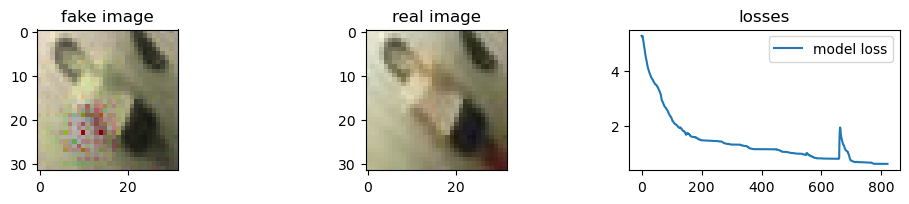

Epoch 821/1000: <=> ------- model loss = 0.6293759346008301, time = 0.0s
Epoch 822/1000: <=> ------- model loss = 0.6293259859085083, time = 0.0s
Epoch 823/1000: <=> ------- model loss = 0.6292751431465149, time = 0.0s
Epoch 824/1000: <=> ------- model loss = 0.629227876663208, time = 0.0s
Epoch 825/1000: <=> ------- model loss = 0.6291760802268982, time = 0.0s

Validation loss = 0


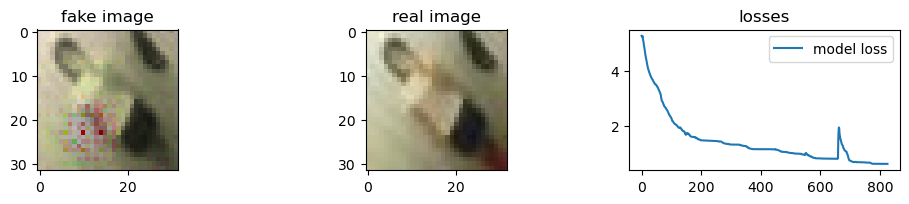

Epoch 826/1000: <=> ------- model loss = 0.6291254162788391, time = 0.0s
Epoch 827/1000: <=> ------- model loss = 0.6290774941444397, time = 0.0s
Epoch 828/1000: <=> ------- model loss = 0.6290265321731567, time = 0.0s
Epoch 829/1000: <=> ------- model loss = 0.6289774775505066, time = 0.0s
Epoch 830/1000: <=> ------- model loss = 0.6289281845092773, time = 0.0s

Validation loss = 0


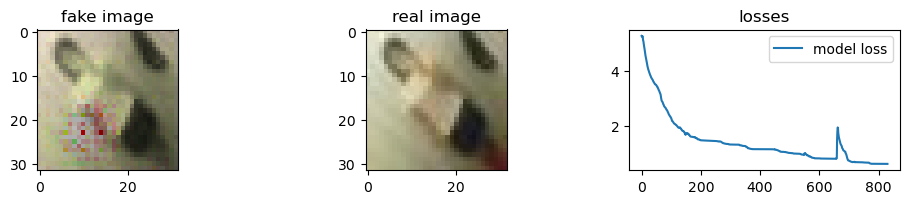

Epoch 831/1000: <=> ------- model loss = 0.6288774013519287, time = 0.0s
Epoch 832/1000: <=> ------- model loss = 0.628827691078186, time = 0.0s
Epoch 833/1000: <=> ------- model loss = 0.6287765502929688, time = 0.0s
Epoch 834/1000: <=> ------- model loss = 0.628726601600647, time = 0.0s
Epoch 835/1000: <=> ------- model loss = 0.6286767721176147, time = 0.0s

Validation loss = 0


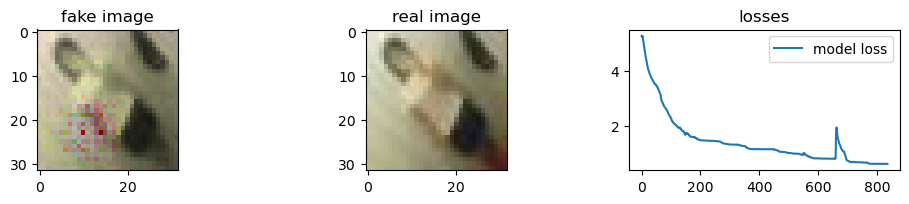

Epoch 836/1000: <=> ------- model loss = 0.6286269426345825, time = 0.0s
Epoch 837/1000: <=> ------- model loss = 0.6285780668258667, time = 0.0s
Epoch 838/1000: <=> ------- model loss = 0.6285279989242554, time = 0.0s
Epoch 839/1000: <=> ------- model loss = 0.6284786462783813, time = 0.0s
Epoch 840/1000: <=> ------- model loss = 0.6284306645393372, time = 0.0s

Validation loss = 0


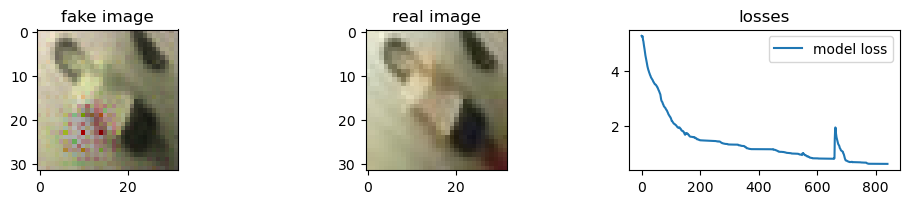

Epoch 841/1000: <=> ------- model loss = 0.6283793449401855, time = 0.0s
Epoch 842/1000: <=> ------- model loss = 0.6283286809921265, time = 0.0s
Epoch 843/1000: <=> ------- model loss = 0.6282784342765808, time = 0.0s
Epoch 844/1000: <=> ------- model loss = 0.6282241940498352, time = 0.0s
Epoch 845/1000: <=> ------- model loss = 0.6220425963401794, time = 0.0s

Validation loss = 0


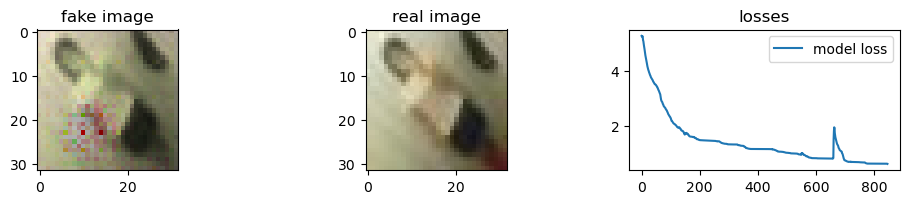

Epoch 846/1000: <=> ------- model loss = 0.6240691542625427, time = 0.0s
Epoch 847/1000: <=> ------- model loss = 0.6191660761833191, time = 0.0s
Epoch 848/1000: <=> ------- model loss = 0.6192131042480469, time = 0.0s
Epoch 849/1000: <=> ------- model loss = 0.6191693544387817, time = 0.0s
Epoch 850/1000: <=> ------- model loss = 0.6190493106842041, time = 0.0s

Validation loss = 0


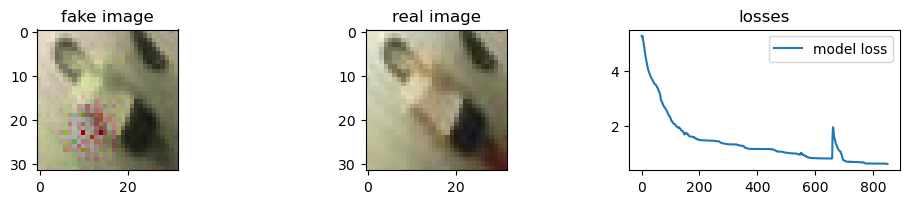

Epoch 851/1000: <=> ------- model loss = 0.6189472675323486, time = 0.0s
Epoch 852/1000: <=> ------- model loss = 0.6188756227493286, time = 0.0s
Epoch 853/1000: <=> ------- model loss = 0.6195539832115173, time = 0.0s
Epoch 854/1000: <=> ------- model loss = 0.6187908053398132, time = 0.0s
Epoch 855/1000: <=> ------- model loss = 0.6188036203384399, time = 0.0s

Validation loss = 0


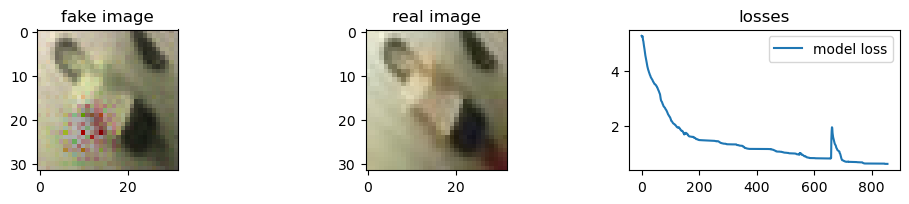

Epoch 856/1000: <=> ------- model loss = 0.6187260150909424, time = 0.0s
Epoch 857/1000: <=> ------- model loss = 0.6186519861221313, time = 0.0s
Epoch 858/1000: <=> ------- model loss = 0.6185616254806519, time = 0.0s
Epoch 859/1000: <=> ------- model loss = 0.6184825897216797, time = 0.0s
Epoch 860/1000: <=> ------- model loss = 0.6191872358322144, time = 0.0s

Validation loss = 0


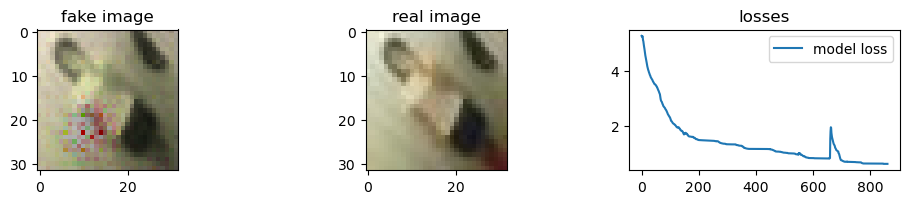

Epoch 861/1000: <=> ------- model loss = 0.6183497905731201, time = 0.0s
Epoch 862/1000: <=> ------- model loss = 0.6182883977890015, time = 0.0s
Epoch 863/1000: <=> ------- model loss = 0.6182488203048706, time = 0.0s
Epoch 864/1000: <=> ------- model loss = 0.6181710362434387, time = 0.0s
Epoch 865/1000: <=> ------- model loss = 0.618074893951416, time = 0.0s

Validation loss = 0


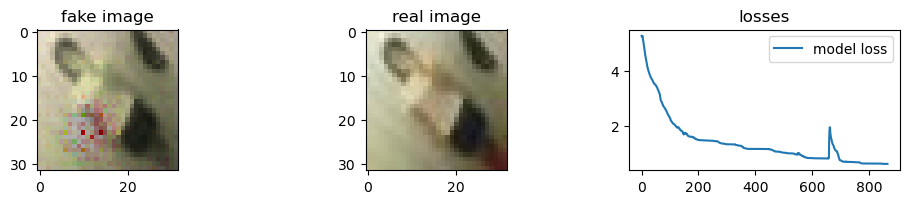

Epoch 866/1000: <=> ------- model loss = 0.6179997324943542, time = 0.0s
Epoch 867/1000: <=> ------- model loss = 0.617965817451477, time = 0.0s
Epoch 868/1000: <=> ------- model loss = 0.6179412603378296, time = 0.0s
Epoch 869/1000: <=> ------- model loss = 0.6179623007774353, time = 0.0s
Epoch 870/1000: <=> ------- model loss = 0.6178921461105347, time = 0.0s

Validation loss = 0


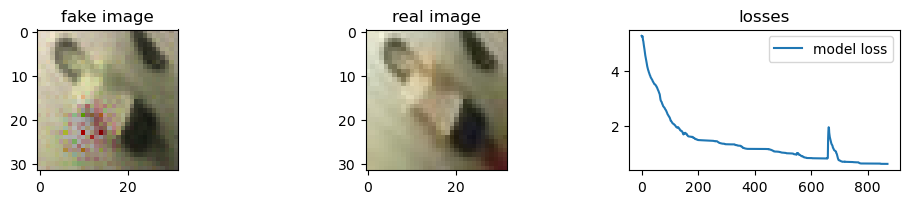

Epoch 871/1000: <=> ------- model loss = 0.6177510619163513, time = 0.0s
Epoch 872/1000: <=> ------- model loss = 0.6148273348808289, time = 0.0s
Epoch 873/1000: <=> ------- model loss = 0.6176341772079468, time = 0.0s
Epoch 874/1000: <=> ------- model loss = 0.6187687516212463, time = 0.0s
Epoch 875/1000: <=> ------- model loss = 0.6146155595779419, time = 0.0s

Validation loss = 0


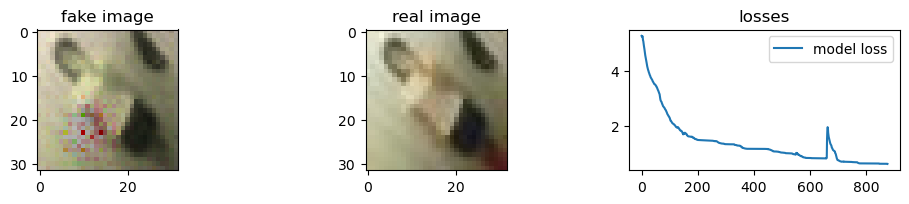

Epoch 876/1000: <=> ------- model loss = 0.614582896232605, time = 0.0s
Epoch 877/1000: <=> ------- model loss = 0.6145256757736206, time = 0.0s
Epoch 878/1000: <=> ------- model loss = 0.6118924617767334, time = 0.0s
Epoch 879/1000: <=> ------- model loss = 0.6117660999298096, time = 0.0s
Epoch 880/1000: <=> ------- model loss = 0.6117385625839233, time = 0.0s

Validation loss = 0


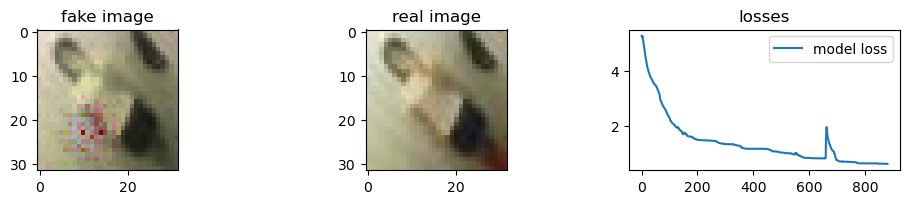

Epoch 881/1000: <=> ------- model loss = 0.6098624467849731, time = 0.0s
Epoch 882/1000: <=> ------- model loss = 0.6231111884117126, time = 0.0s
Epoch 883/1000: <=> ------- model loss = 0.6102074384689331, time = 0.0s
Epoch 884/1000: <=> ------- model loss = 0.6102227568626404, time = 0.0s
Epoch 885/1000: <=> ------- model loss = 0.6100528240203857, time = 0.0s

Validation loss = 0


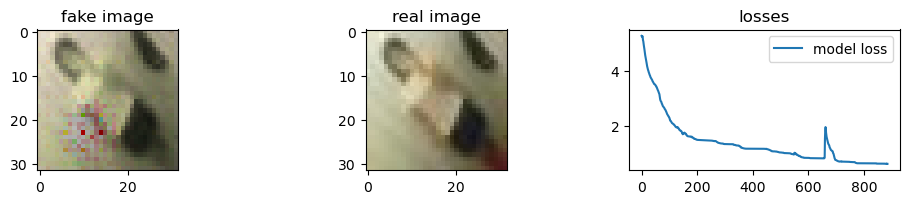

Epoch 886/1000: <=> ------- model loss = 0.6098461151123047, time = 0.0s
Epoch 887/1000: <=> ------- model loss = 0.6097090244293213, time = 0.0s
Epoch 888/1000: <=> ------- model loss = 0.6095618009567261, time = 0.0s
Epoch 889/1000: <=> ------- model loss = 0.6101585626602173, time = 0.0s
Epoch 890/1000: <=> ------- model loss = 0.6125070452690125, time = 0.0s

Validation loss = 0


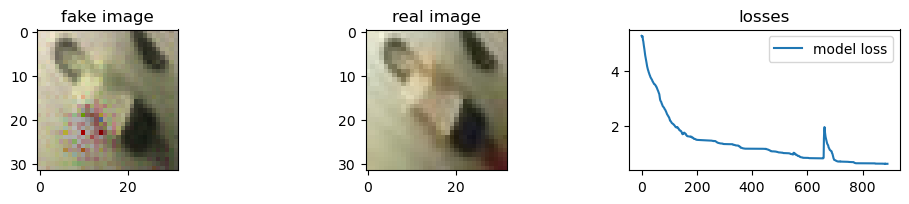

Epoch 891/1000: <=> ------- model loss = 0.6132289171218872, time = 0.0s
Epoch 892/1000: <=> ------- model loss = 0.613156259059906, time = 0.0s
Epoch 893/1000: <=> ------- model loss = 0.6122386455535889, time = 0.0s
Epoch 894/1000: <=> ------- model loss = 0.6096847653388977, time = 0.0s
Epoch 895/1000: <=> ------- model loss = 0.6089046001434326, time = 0.0s

Validation loss = 0


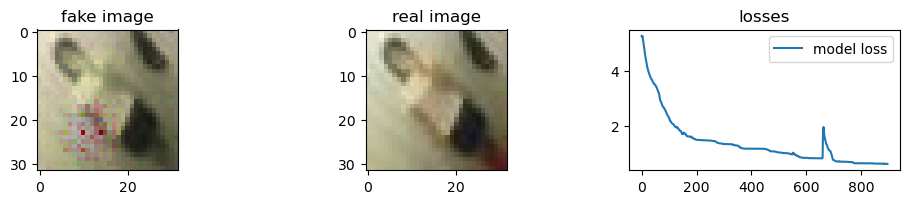

Epoch 896/1000: <=> ------- model loss = 0.6088796257972717, time = 0.0s
Epoch 897/1000: <=> ------- model loss = 0.6088058948516846, time = 0.0s
Epoch 898/1000: <=> ------- model loss = 0.6087068915367126, time = 0.0s
Epoch 899/1000: <=> ------- model loss = 0.6059871912002563, time = 0.0s
Epoch 900/1000: <=> ------- model loss = 0.6640372276306152, time = 0.0s

Validation loss = 0


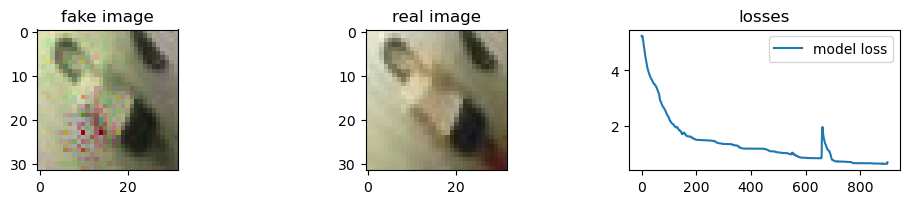

Epoch 901/1000: <=> ------- model loss = 0.6096364259719849, time = 0.0s
Epoch 902/1000: <=> ------- model loss = 0.6467069983482361, time = 0.0s
Epoch 903/1000: <=> ------- model loss = 0.631446123123169, time = 0.0s
Epoch 904/1000: <=> ------- model loss = 0.6136124134063721, time = 0.0s
Epoch 905/1000: <=> ------- model loss = 0.5961689352989197, time = 0.0s

Validation loss = 0


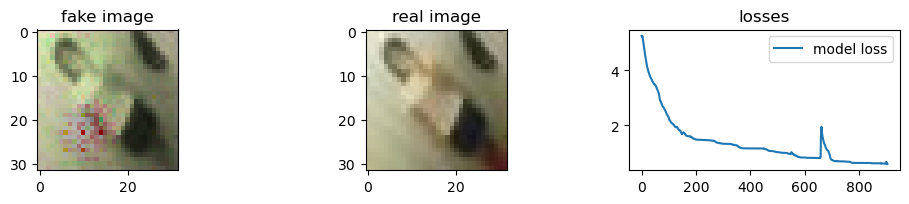

Epoch 906/1000: <=> ------- model loss = 0.5933175086975098, time = 0.0s
Epoch 907/1000: <=> ------- model loss = 0.5930348038673401, time = 0.0s
Epoch 908/1000: <=> ------- model loss = 0.5928004384040833, time = 0.0s
Epoch 909/1000: <=> ------- model loss = 0.5925500988960266, time = 0.0s
Epoch 910/1000: <=> ------- model loss = 0.5922550559043884, time = 0.0s

Validation loss = 0


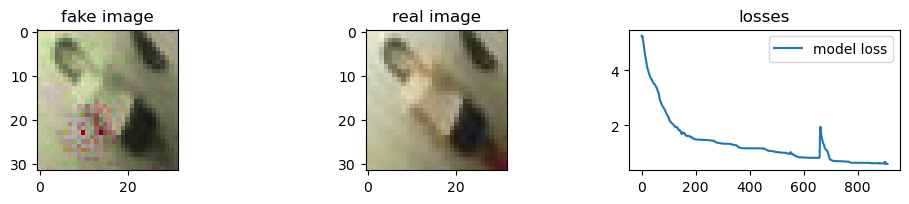

Epoch 911/1000: <=> ------- model loss = 0.5919366478919983, time = 0.0s
Epoch 912/1000: <=> ------- model loss = 0.5915862917900085, time = 0.0s
Epoch 913/1000: <=> ------- model loss = 0.5912697315216064, time = 0.0s
Epoch 914/1000: <=> ------- model loss = 0.59098219871521, time = 0.0s
Epoch 915/1000: <=> ------- model loss = 0.5875099301338196, time = 0.0s

Validation loss = 0


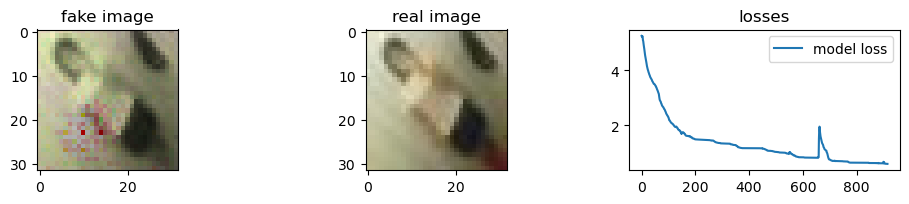

Epoch 916/1000: <=> ------- model loss = 0.5845074653625488, time = 0.0s
Epoch 917/1000: <=> ------- model loss = 0.5802595615386963, time = 0.0s
Epoch 918/1000: <=> ------- model loss = 0.5799446105957031, time = 0.0s
Epoch 919/1000: <=> ------- model loss = 0.5797522068023682, time = 0.0s
Epoch 920/1000: <=> ------- model loss = 0.579571008682251, time = 0.0s

Validation loss = 0


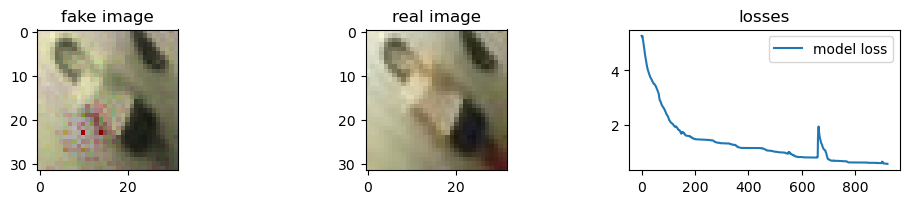

Epoch 921/1000: <=> ------- model loss = 0.579371452331543, time = 0.0s
Epoch 922/1000: <=> ------- model loss = 0.5791646242141724, time = 0.0s
Epoch 923/1000: <=> ------- model loss = 0.5789791941642761, time = 0.0s
Epoch 924/1000: <=> ------- model loss = 0.5788307785987854, time = 0.0s
Epoch 925/1000: <=> ------- model loss = 0.5786936283111572, time = 0.0s

Validation loss = 0


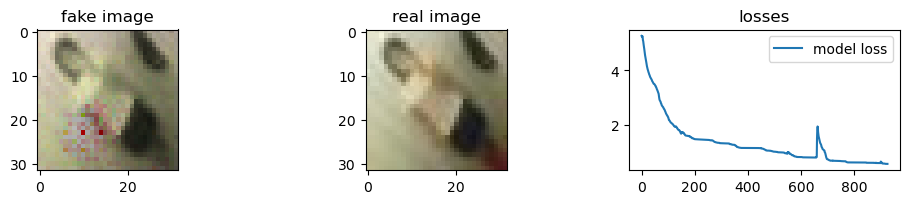

Epoch 926/1000: <=> ------- model loss = 0.5785448551177979, time = 0.0s
Epoch 927/1000: <=> ------- model loss = 0.5783868432044983, time = 0.0s
Epoch 928/1000: <=> ------- model loss = 0.578241229057312, time = 0.0s
Epoch 929/1000: <=> ------- model loss = 0.5781182050704956, time = 0.0s
Epoch 930/1000: <=> ------- model loss = 0.5779973268508911, time = 0.0s

Validation loss = 0


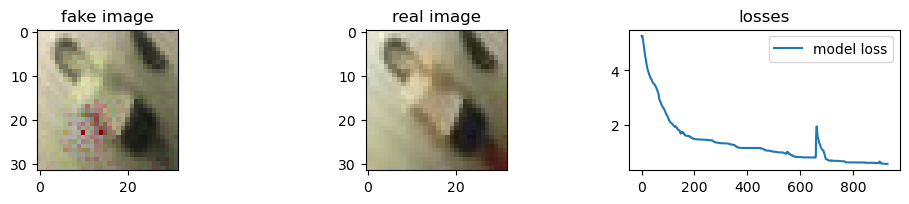

Epoch 931/1000: <=> ------- model loss = 0.5778947472572327, time = 0.0s
Epoch 932/1000: <=> ------- model loss = 0.5777853727340698, time = 0.0s
Epoch 933/1000: <=> ------- model loss = 0.5776796340942383, time = 0.0s
Epoch 934/1000: <=> ------- model loss = 0.5747101902961731, time = 0.0s
Epoch 935/1000: <=> ------- model loss = 0.5745171308517456, time = 0.0s

Validation loss = 0


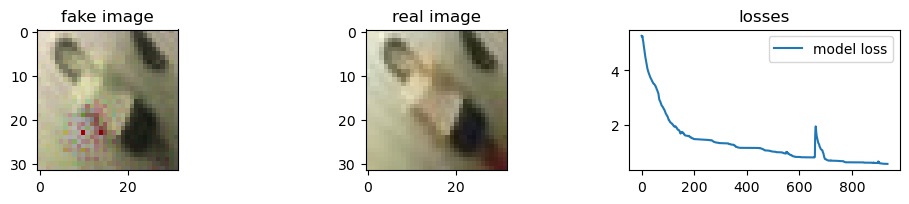

Epoch 936/1000: <=> ------- model loss = 0.5744872093200684, time = 0.0s
Epoch 937/1000: <=> ------- model loss = 0.5744423866271973, time = 0.0s
Epoch 938/1000: <=> ------- model loss = 0.5743659734725952, time = 0.0s
Epoch 939/1000: <=> ------- model loss = 0.5742806196212769, time = 0.0s
Epoch 940/1000: <=> ------- model loss = 0.5742064714431763, time = 0.0s

Validation loss = 0


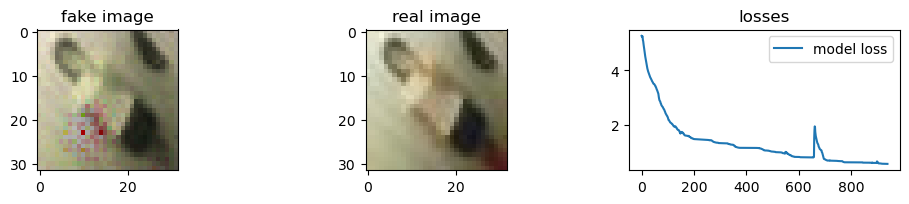

Epoch 941/1000: <=> ------- model loss = 0.5741130709648132, time = 0.0s
Epoch 942/1000: <=> ------- model loss = 0.5740209221839905, time = 0.0s
Epoch 943/1000: <=> ------- model loss = 0.5739489793777466, time = 0.0s
Epoch 944/1000: <=> ------- model loss = 0.5738409757614136, time = 0.0s
Epoch 945/1000: <=> ------- model loss = 0.5737457275390625, time = 0.0s

Validation loss = 0


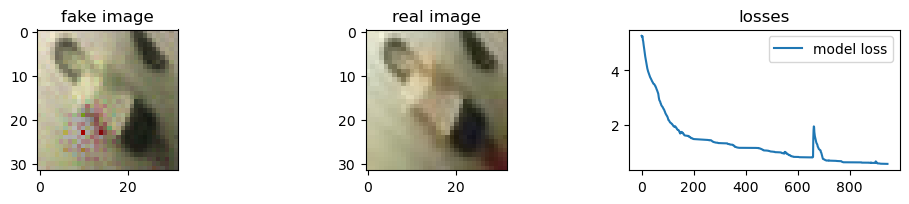

Epoch 946/1000: <=> ------- model loss = 0.573654055595398, time = 0.0s
Epoch 947/1000: <=> ------- model loss = 0.5735652446746826, time = 0.0s
Epoch 948/1000: <=> ------- model loss = 0.5734863877296448, time = 0.0s
Epoch 949/1000: <=> ------- model loss = 0.5734054446220398, time = 0.0s
Epoch 950/1000: <=> ------- model loss = 0.5733342170715332, time = 0.0s

Validation loss = 0


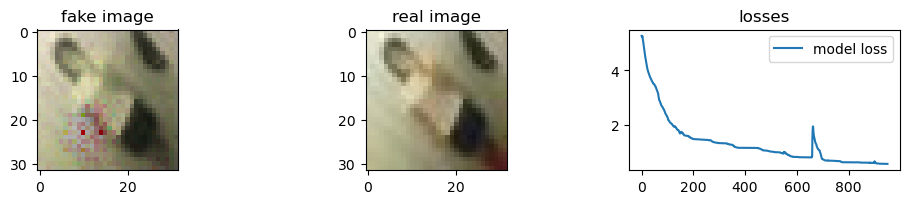

Epoch 951/1000: <=> ------- model loss = 0.5732512474060059, time = 0.0s
Epoch 952/1000: <=> ------- model loss = 0.5731610059738159, time = 0.0s
Epoch 953/1000: <=> ------- model loss = 0.5730729103088379, time = 0.0s
Epoch 954/1000: <=> ------- model loss = 0.5729891657829285, time = 0.0s
Epoch 955/1000: <=> ------- model loss = 0.572905421257019, time = 0.0s

Validation loss = 0


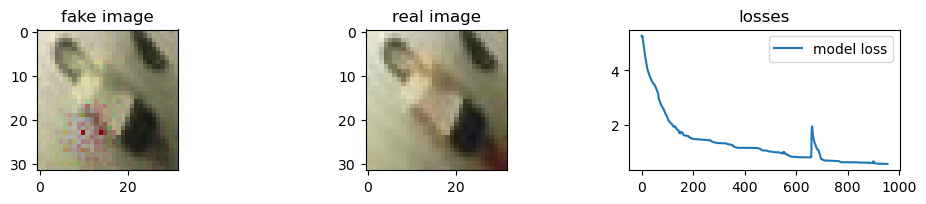

Epoch 956/1000: <=> ------- model loss = 0.5728222131729126, time = 0.0s
Epoch 957/1000: <=> ------- model loss = 0.5727342367172241, time = 0.0s
Epoch 958/1000: <=> ------- model loss = 0.5726585984230042, time = 0.0s
Epoch 959/1000: <=> ------- model loss = 0.5726691484451294, time = 0.0s
Epoch 960/1000: <=> ------- model loss = 0.5725564956665039, time = 0.0s

Validation loss = 0


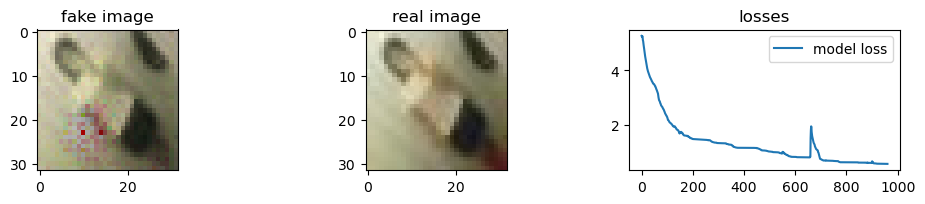

Epoch 961/1000: <=> ------- model loss = 0.5724648833274841, time = 0.0s
Epoch 962/1000: <=> ------- model loss = 0.5733702182769775, time = 0.0s
Epoch 963/1000: <=> ------- model loss = 0.5735844373703003, time = 0.0s
Epoch 964/1000: <=> ------- model loss = 0.5734675526618958, time = 0.0s
Epoch 965/1000: <=> ------- model loss = 0.573261022567749, time = 0.0s

Validation loss = 0


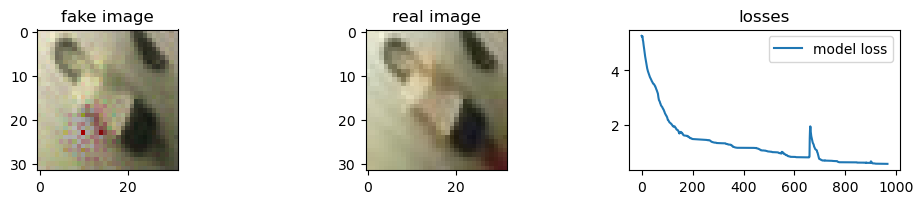

Epoch 966/1000: <=> ------- model loss = 0.5729669332504272, time = 0.0s
Epoch 967/1000: <=> ------- model loss = 0.5726993083953857, time = 0.0s
Epoch 968/1000: <=> ------- model loss = 0.572380006313324, time = 0.0s
Epoch 969/1000: <=> ------- model loss = 0.5721315145492554, time = 0.0s
Epoch 970/1000: <=> ------- model loss = 0.5719912052154541, time = 0.0s

Validation loss = 0


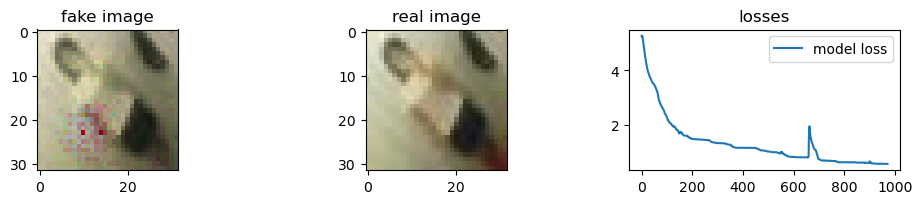

Epoch 971/1000: <=> ------- model loss = 0.5719415545463562, time = 0.0s
Epoch 972/1000: <=> ------- model loss = 0.5718860626220703, time = 0.0s
Epoch 973/1000: <=> ------- model loss = 0.5718014240264893, time = 0.0s
Epoch 974/1000: <=> ------- model loss = 0.5717244148254395, time = 0.0s
Epoch 975/1000: <=> ------- model loss = 0.5716614723205566, time = 0.0s

Validation loss = 0


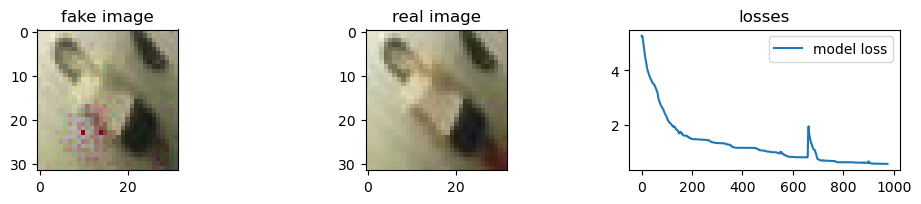

Epoch 976/1000: <=> ------- model loss = 0.571584939956665, time = 0.0s
Epoch 977/1000: <=> ------- model loss = 0.5715054273605347, time = 0.0s
Epoch 978/1000: <=> ------- model loss = 0.5714290142059326, time = 0.0s
Epoch 979/1000: <=> ------- model loss = 0.5713561773300171, time = 0.0s
Epoch 980/1000: <=> ------- model loss = 0.5712864398956299, time = 0.0s

Validation loss = 0


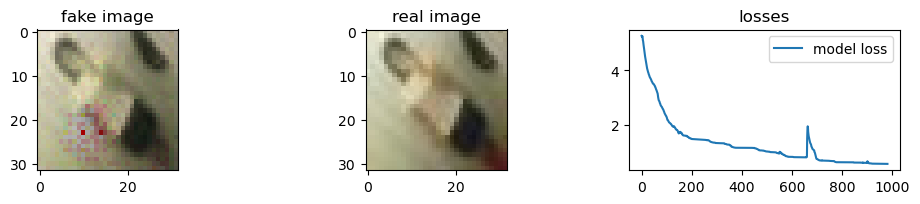

Epoch 981/1000: <=> ------- model loss = 0.5712113380432129, time = 0.0s
Epoch 982/1000: <=> ------- model loss = 0.5711334943771362, time = 0.0s
Epoch 983/1000: <=> ------- model loss = 0.5710723400115967, time = 0.0s
Epoch 984/1000: <=> ------- model loss = 0.5710017085075378, time = 0.0s
Epoch 985/1000: <=> ------- model loss = 0.5709406137466431, time = 0.0s

Validation loss = 0


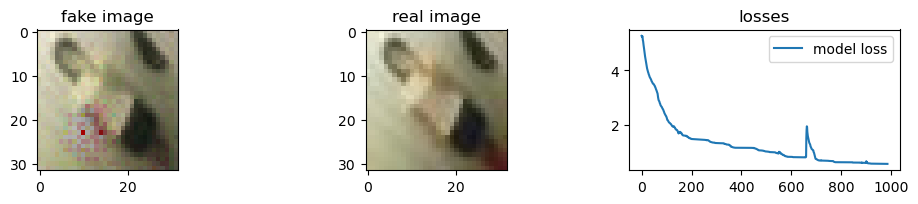

Epoch 986/1000: <=> ------- model loss = 0.5708755254745483, time = 0.0s
Epoch 987/1000: <=> ------- model loss = 0.5708423256874084, time = 0.0s
Epoch 988/1000: <=> ------- model loss = 0.5667513608932495, time = 0.0s
Epoch 989/1000: <=> ------- model loss = 0.5666681528091431, time = 0.0s
Epoch 990/1000: <=> ------- model loss = 0.5666377544403076, time = 0.0s

Validation loss = 0


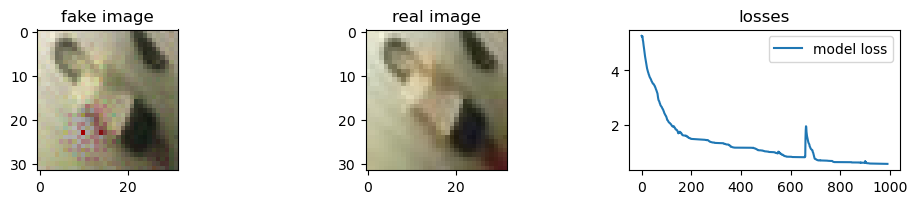

Epoch 991/1000: <=> ------- model loss = 0.5665067434310913, time = 0.0s
Epoch 992/1000: <=> ------- model loss = 0.5664844512939453, time = 0.0s
Epoch 993/1000: <=> ------- model loss = 0.5640990734100342, time = 0.0s
Epoch 994/1000: <=> ------- model loss = 0.5699102878570557, time = 0.0s
Epoch 995/1000: <=> ------- model loss = 0.5970384478569031, time = 0.0s

Validation loss = 0


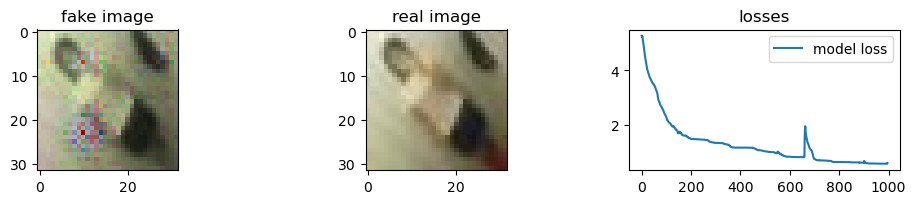

Epoch 996/1000: <=> ------- model loss = 0.7219909429550171, time = 0.0s
Epoch 997/1000: <=> ------- model loss = 0.5874143242835999, time = 0.0s
Epoch 998/1000: <=> ------- model loss = 0.5567314624786377, time = 0.0s
Epoch 999/1000: <=> ------- model loss = 0.5517188310623169, time = 0.0s


In [8]:
%matplotlib inline
loss = train_model3(model, train_loader, epochs = 1000, device = DEVICE)